## Data prep

* original_embeddings: 1854 concepts * 49 features (euclidean)
* memorability scores
* category mappings: 1324 concepts in 27 higher-level categories
* feature names
* typicality scores: average similarity of 1619 concepts within category


In [1]:
import os
import numpy as np
import pandas as pd
from scipy.io import loadmat
from scipy.linalg import orthogonal_procrustes
import statsmodels.api as sm
import scipy.stats as stats
from hyperbolicMDS.mds import HyperMDS, cart_to_polar, poincare_dist_vec
from matplotlib import colors
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import axes3d
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import re, seaborn as sns

data_dir = '../data'
output_dir = '../outputs'

In [2]:
# load original 1854*49 embeddings
original_embeddings = np.loadtxt(os.path.join(data_dir, 'spose_embedding_49d_sorted.txt'))
original_embeddings.shape

(1854, 49)

In [3]:
# load categories and memorability score of each concept
cat_mapping = pd.read_csv(os.path.join(data_dir, 'THINGS_Table.csv'))
cat_concept_mem = cat_mapping[['cr', 'smallcat', 'bigcat']].groupby('smallcat').mean()
cat_concept_mem['bigcat'] = cat_concept_mem['bigcat'].astype(int).replace(0, 99)
cat_concept_mem

cr  bigcat
smallcat                  
1         0.779739       1
2         0.798485      13
3         0.752845      18
4         0.761851      99
5         0.794466       9
...            ...     ...
1850      0.722655      99
1851      0.843158      10
1852      0.800163       1
1853      0.797468      99
1854      0.823237      10

[1854 rows x 2 columns]

In [4]:
### load category names and merge with concepts
cat = loadmat(os.path.join(data_dir,'categories.mat'))
cat_names = [item[0] for item in cat['categories'][0]]
cat_names.append('na')
cat_names = pd.DataFrame(cat_names, columns=['cat_name']).reset_index()
cat_names['index'] = cat_names['index']+1
cat_names.iloc[27] = [99, np.nan]
cat_concept_mem = cat_concept_mem.merge(cat_names, how='left', left_on='bigcat', right_on='index').drop(columns=['index'])
cat_concept_mem


cr  bigcat            cat_name
0     0.779739       1              animal
1     0.798485      13          home decor
2     0.752845      18  musical instrument
3     0.761851      99                 NaN
4     0.794466       9   electronic device
...        ...     ...                 ...
1849  0.722655      99                 NaN
1850  0.843158      10                food
1851  0.800163       1              animal
1852  0.797468      99                 NaN
1853  0.823237      10                food

[1854 rows x 3 columns]

In [5]:
### load feature names
feat_short = loadmat(os.path.join(data_dir, 'labels_short.mat'))
feat_short_names = [item[0] for item in feat_short['labels_short'][0]]
features = loadmat(os.path.join(data_dir, 'labels.mat'))
feat_name = [item[0][0] for item in features['labels']]
feat_name

['made of metal / artificial / hard',
 'food-related / eating-related / kitchen-related',
 'animal-related / organic',
 'clothing-related / fabric / covering',
 'furniture-related / household-related / artifact',
 'plant-related / green',
 'outdoors-related',
 'transportation / motorized / dynamic',
 'wood-related / brownish',
 'body part-related',
 'colorful',
 'valuable / special occasion-related',
 'electronic / technology',
 'sport-related / recreational activity-related',
 'disc-shaped / round',
 'tool-related',
 'many small things / course pattern',
 'paper-related / thin / flat / text-related',
 'fluid-related / drink-related',
 'long / thin',
 'water-related / blue',
 'powdery / fine-scale pattern',
 'red',
 'feminine (stereotypically) / decorative',
 'bathroom-related / sanitary',
 'black / noble',
 'weapon / danger-related / violence',
 'musical instrument-related / noise-related',
 'sky-related / flying-related / floating-related',
 'spherical / ellipsoid / rounded / volumin

In [6]:
### load typicality score and merge with concepts
cat_typicality = loadmat(os.path.join(data_dir, 'typicality_data27.mat'))
concept_idx = []
concept_typ = []
concept_cat = []
for cat_idx in range(27):
    concept_idx.extend(pd.DataFrame(cat_typicality['category27_ind'][0][cat_idx])[0].to_list())
    concept_typ.extend(pd.DataFrame(cat_typicality['category27_typicality_rating_normed'][cat_idx][0])[0].to_list())
    concept_cat.extend([cat_idx+1 for i in range(len(cat_typicality['category27_ind'][0][cat_idx]))])
concept_typicality_rated = pd.DataFrame({'cat': concept_cat, 'concept': concept_idx, 'typicality': concept_typ})
concept_typicality_rated['concept'] = concept_typicality_rated['concept']-1
concept_typicality_rated

cat  concept  typicality
0       1        0    4.874352
1       1       12    6.374555
2       1       15    5.342846
3       1       24    4.655669
4       1       25    5.288886
...   ...      ...         ...
1614   27     1602    7.456293
1615   27     1620    5.922099
1616   27     1684    5.219242
1617   27     1712    3.238293
1618   27     1809    4.333765

[1619 rows x 3 columns]

## 49-dim Feature Space

1. Get 49-dim feature embeddings from albatross results (.npy)
2. Get loadings of 1854 concepts in 49-dim hyperbolic feature space
3. Euclidean vs. mobius vector addition: test out different values of S
4. Get average 49-dim feature space embeddings and 1854 concept loadings through procrustes
5. Analysis: predicting memorability (euclidean vs. mobius)
    * Cartesian coordinates (x, y, z: which axis explains variances in memorability the best)
    * Polar coordinates (r, theta, rho: which angle explains the best)
    * Radius (concepts closer to the core vs. on surface are more memorable?)
    * K-Means clusters:
      - Cartesian coordinates
      - Polar coordinates
6. Analysis: with typicality (euclidean vs. mobius)
    * Calculate typicality: average similarity of each concept pair within category 
    * Predicting typicality
      - Cartesian coordinates
      - Polar coordinates 
      - Radius
    * Predicting memorability
      - Typicality (more prototypical --> more memorable?)
      - Typicality + coordinates/radius to predict memorability
        



In [7]:
# 49-dim feature space embeddings
feature_embeddings = np.load(os.path.join(data_dir, 'membatross_embeddings.npy'))
feature_embeddings.shape

(49, 3, 500)

1. `feature_embeddings`: output of ALBATROSS, embbeddings of 49 features that represent where 49 features locate in the 3D hyperbolic space. 
2. By multiplying `original_embeddings` (representations of 1854 concepts in 49-dim euclidean feature space) with `feature_embeddings`, we got `concept_in_feat_coord` that contains the loadings of 1854 concepts in hyperbolic space.
3. Instead of euclidean matrix multiplication (sum of loading * each feature vector), we used einstein scalar multiplication and mobius gyrovetor addition to transform 1854 concepts loadings from 49 feature dimensional space to 3d hyperbolic space. By doing this, loadings on each feature vector were multiplied and added in hyperbolic way, where the parameter S controlled the maximum length of vector (max radius of hyperbolic space).

In [8]:
### normalize embeddings and transform concept embeddings to loadings in hyperbolic feature space
concept_in_feat_coord = []
normalized_embeddings = (original_embeddings.T/np.sqrt((original_embeddings**2).sum(axis=1))).T
for layer in range(feature_embeddings.shape[-1]):
    concept_in_feat_coord.append(normalized_embeddings@feature_embeddings[:,:,layer])
np.array(concept_in_feat_coord).shape

(500, 1854, 3)

Orthogonal procrustes looped through each layer and rotated them so that all layers closely mapped. 

In [9]:
### procrustes of concept loadings in hyperbolic feature space
concept_in_feat_reference = concept_in_feat_coord[0]
concept_in_feat_output = [concept_in_feat_reference]
for i in range(1, len(concept_in_feat_coord)):
    R, scale = orthogonal_procrustes(concept_in_feat_coord[i], concept_in_feat_reference)
    concept_in_feat_output.append(concept_in_feat_coord[i]@R)
concept_in_feat_reference

array([[ -8.50796008,   4.06421417, -14.14677464],
       [-27.49406584,   8.97765114,   9.93112566],
       [-22.53874525,  25.13829916,  12.92493627],
       ...,
       [-16.87663121,  12.38163867, -10.87102044],
       [ -5.62744744,   8.8857026 ,  12.50605139],
       [-14.71606581,   2.88349557,  -7.40970974]])

In [10]:
### procrustes of feature embeddings
feature_embed_reference = feature_embeddings[:,:,0]
feature_embed_output = [feature_embed_reference]
for i in range(1, feature_embeddings.shape[-1]):
    R, scale = orthogonal_procrustes(feature_embeddings[:,:,i], feature_embed_reference)
    feature_embed_output.append(feature_embeddings[:,:,i]@R)

In [11]:
### average across 500 layers
mean_concept_in_feat = np.array(concept_in_feat_output).mean(axis=0)
mean_feature_embed = np.array(feature_embed_output).mean(0)

In [12]:
### merge concept loadings with category and memorability
mean_concept_in_feat_cat = pd.DataFrame(mean_concept_in_feat).reset_index().merge(cat_concept_mem, how='left', left_on='index', right_index=True)
mean_concept_in_feat_cat_na = mean_concept_in_feat_cat.dropna()
mean_concept_in_feat_cat_na

index          0          1         2        cr  bigcat  \
0         0  -8.362256   5.447828 -8.557188  0.779739       1   
1         1 -26.123590  12.240625  0.518939  0.798485      13   
2         2 -24.385152  14.180849  0.693800  0.752845      18   
4         4 -20.330699  11.947785 -4.992442  0.794466       9   
5         5 -24.493047  16.661652 -4.482670  0.806000      12   
...     ...        ...        ...       ...       ...     ...   
1847   1847 -18.208906   9.885611  3.776987  0.803129      24   
1848   1848 -19.281246   4.272460 -1.785376  0.765881      10   
1850   1850 -19.551059   2.813812 -2.150868  0.843158      10   
1851   1851 -14.748351   9.486465 -8.609210  0.800163       1   
1853   1853 -18.651758   5.749045 -4.932768  0.823237      10   

                cat_name  
0                 animal  
1             home decor  
2     musical instrument  
4      electronic device  
5              furniture  
...                  ...  
1847                 toy  
1848                food  
1850                food  
1851              animal  
1853                food  

[1324 rows x 7 columns]

<IPython.core.display.Javascript object>


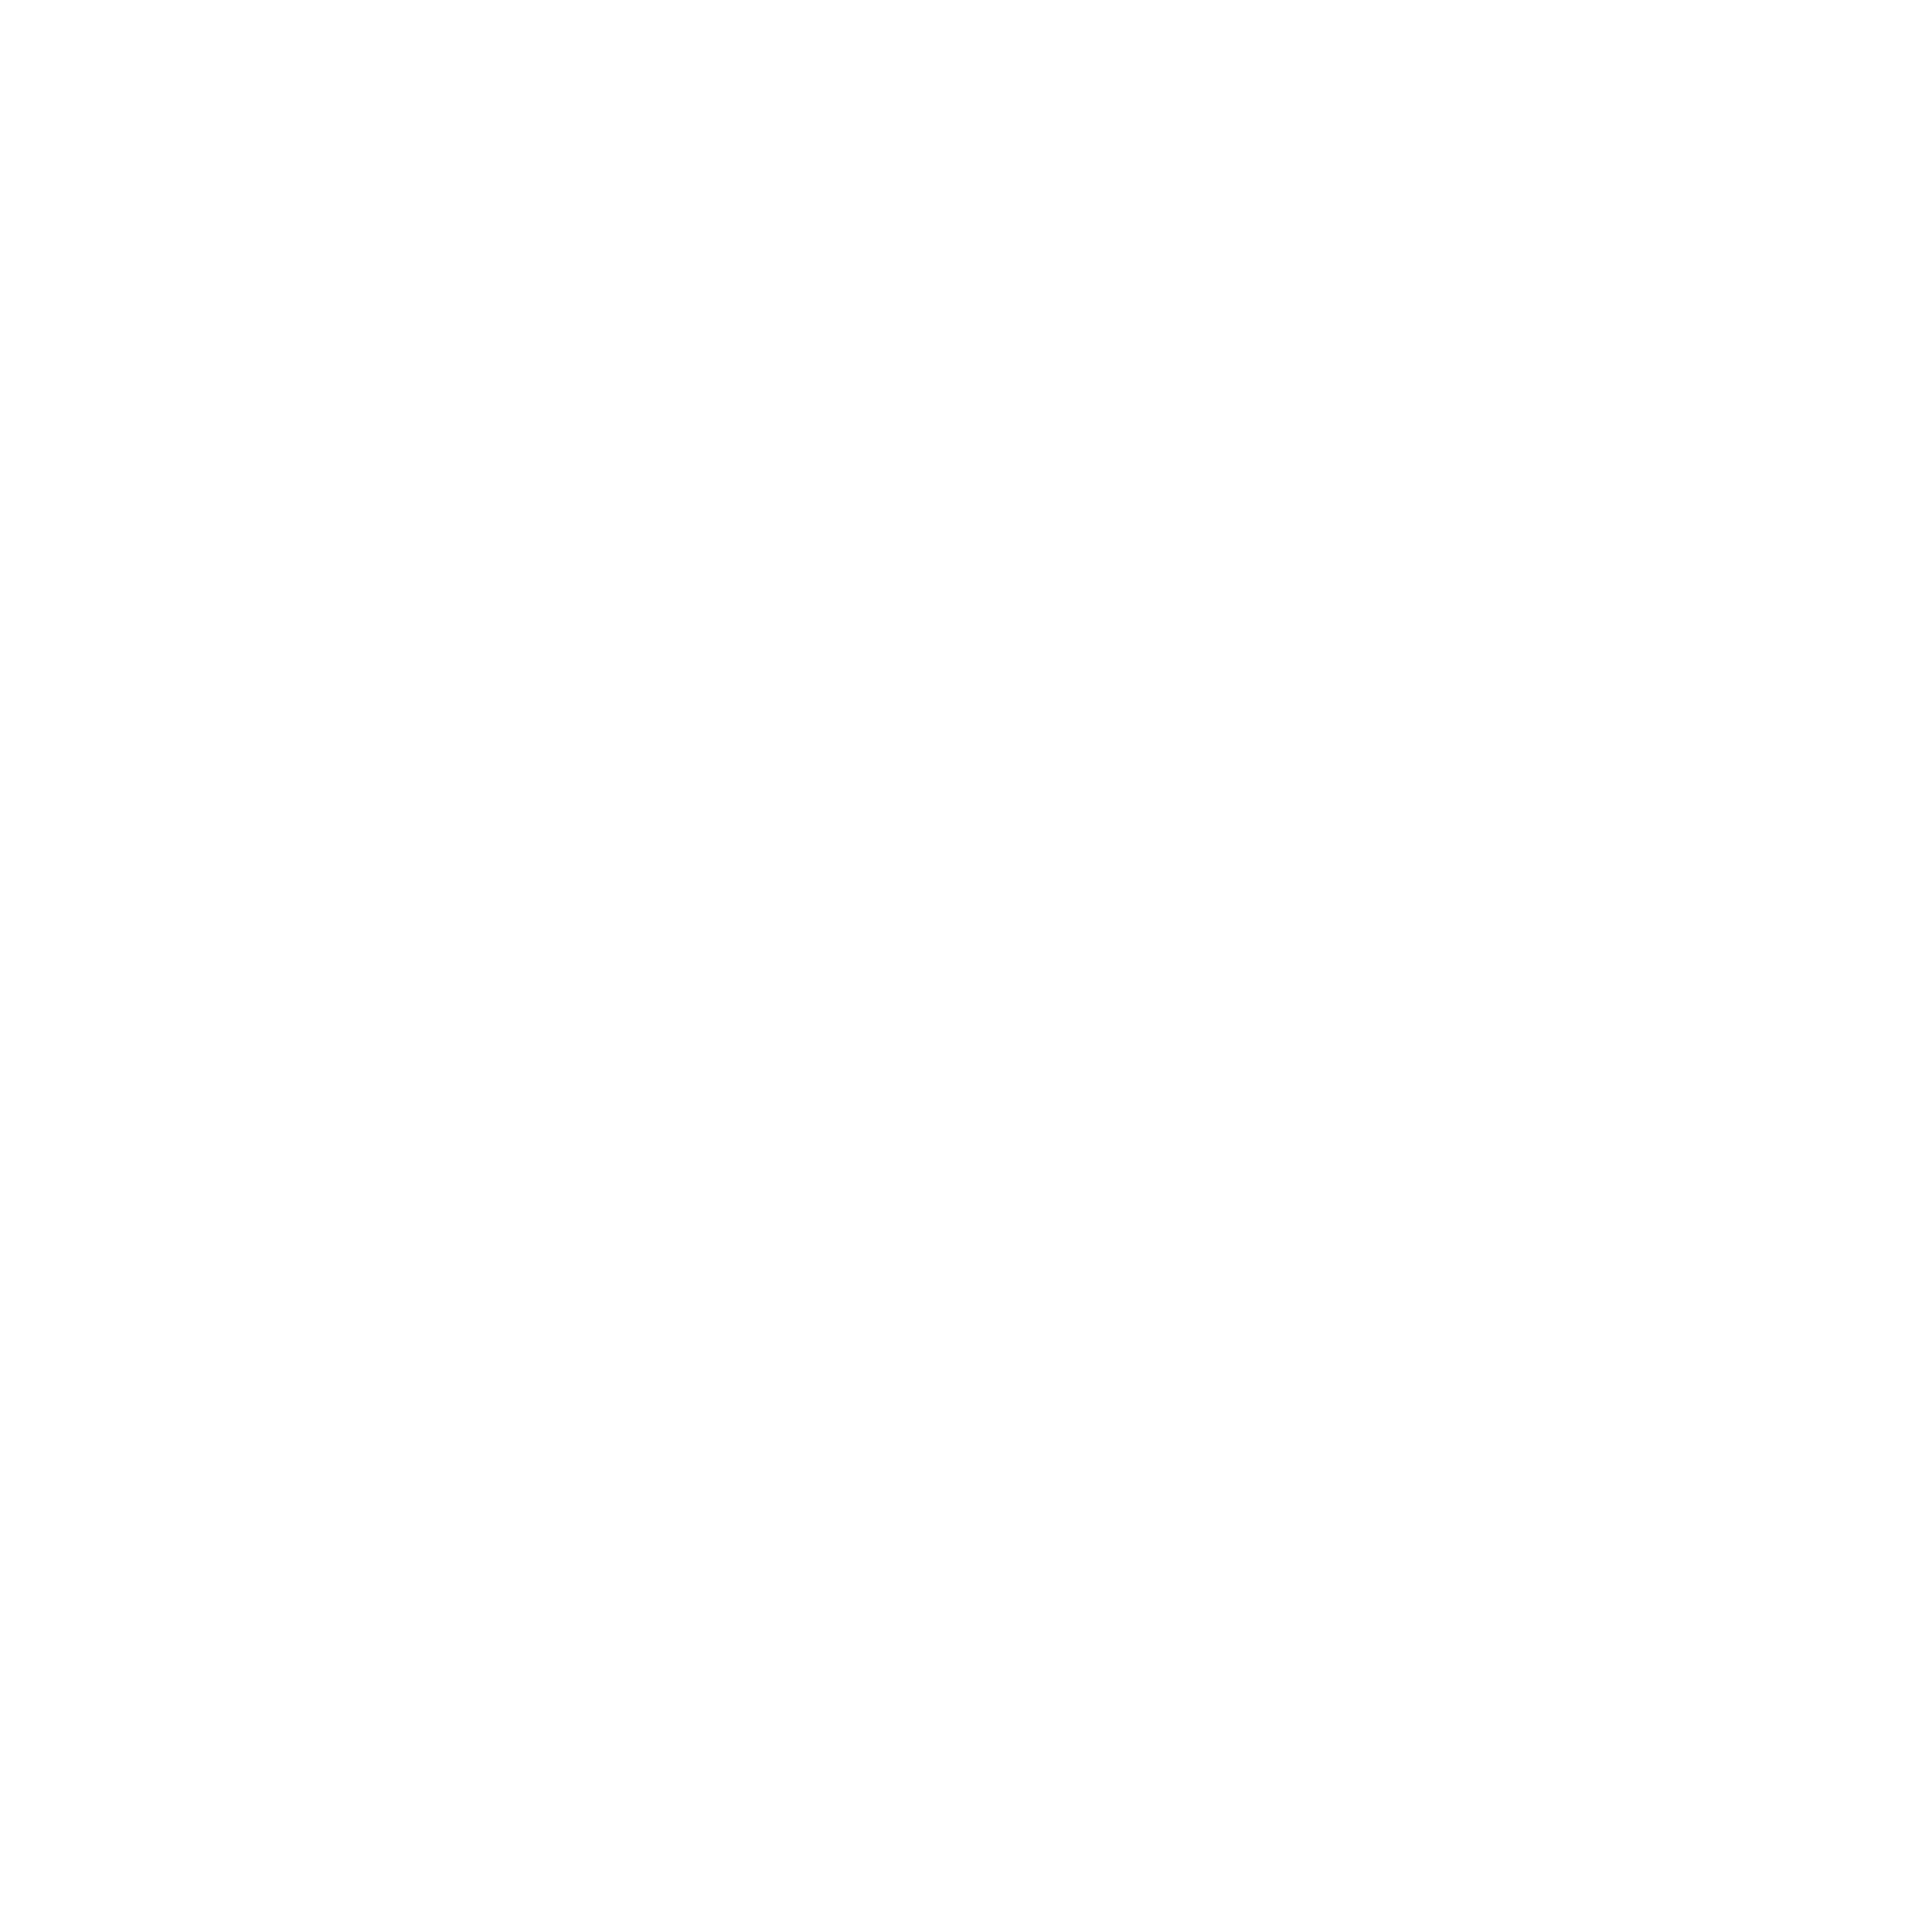

In [13]:
from matplotlib import animation
%matplotlib notebook

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')

# ax.axes.set_xlim3d(left=-30, right=20) 
# ax.axes.set_ylim3d(bottom=-30, top=20) 
# ax.axes.set_zlim3d(bottom=-30, top=20) 
concept_cat = ax.scatter(mean_concept_in_feat_cat_na[0], mean_concept_in_feat_cat_na[1], mean_concept_in_feat_cat_na[2], alpha=0.6) 

ax.scatter(mean_feature_embed.T[0], mean_feature_embed.T[1], mean_feature_embed.T[2], color='red')


def animate(frame):
    ax.view_init(60, frame)
    plt.pause(.0001)
    return fig

anim = animation.FuncAnimation(fig, animate, frames=50, interval=.1, repeat=True)
anim.save('../outputs/feat_concept_rotate.gif', writer='pillow')


plt.show()

<IPython.core.display.Javascript object>


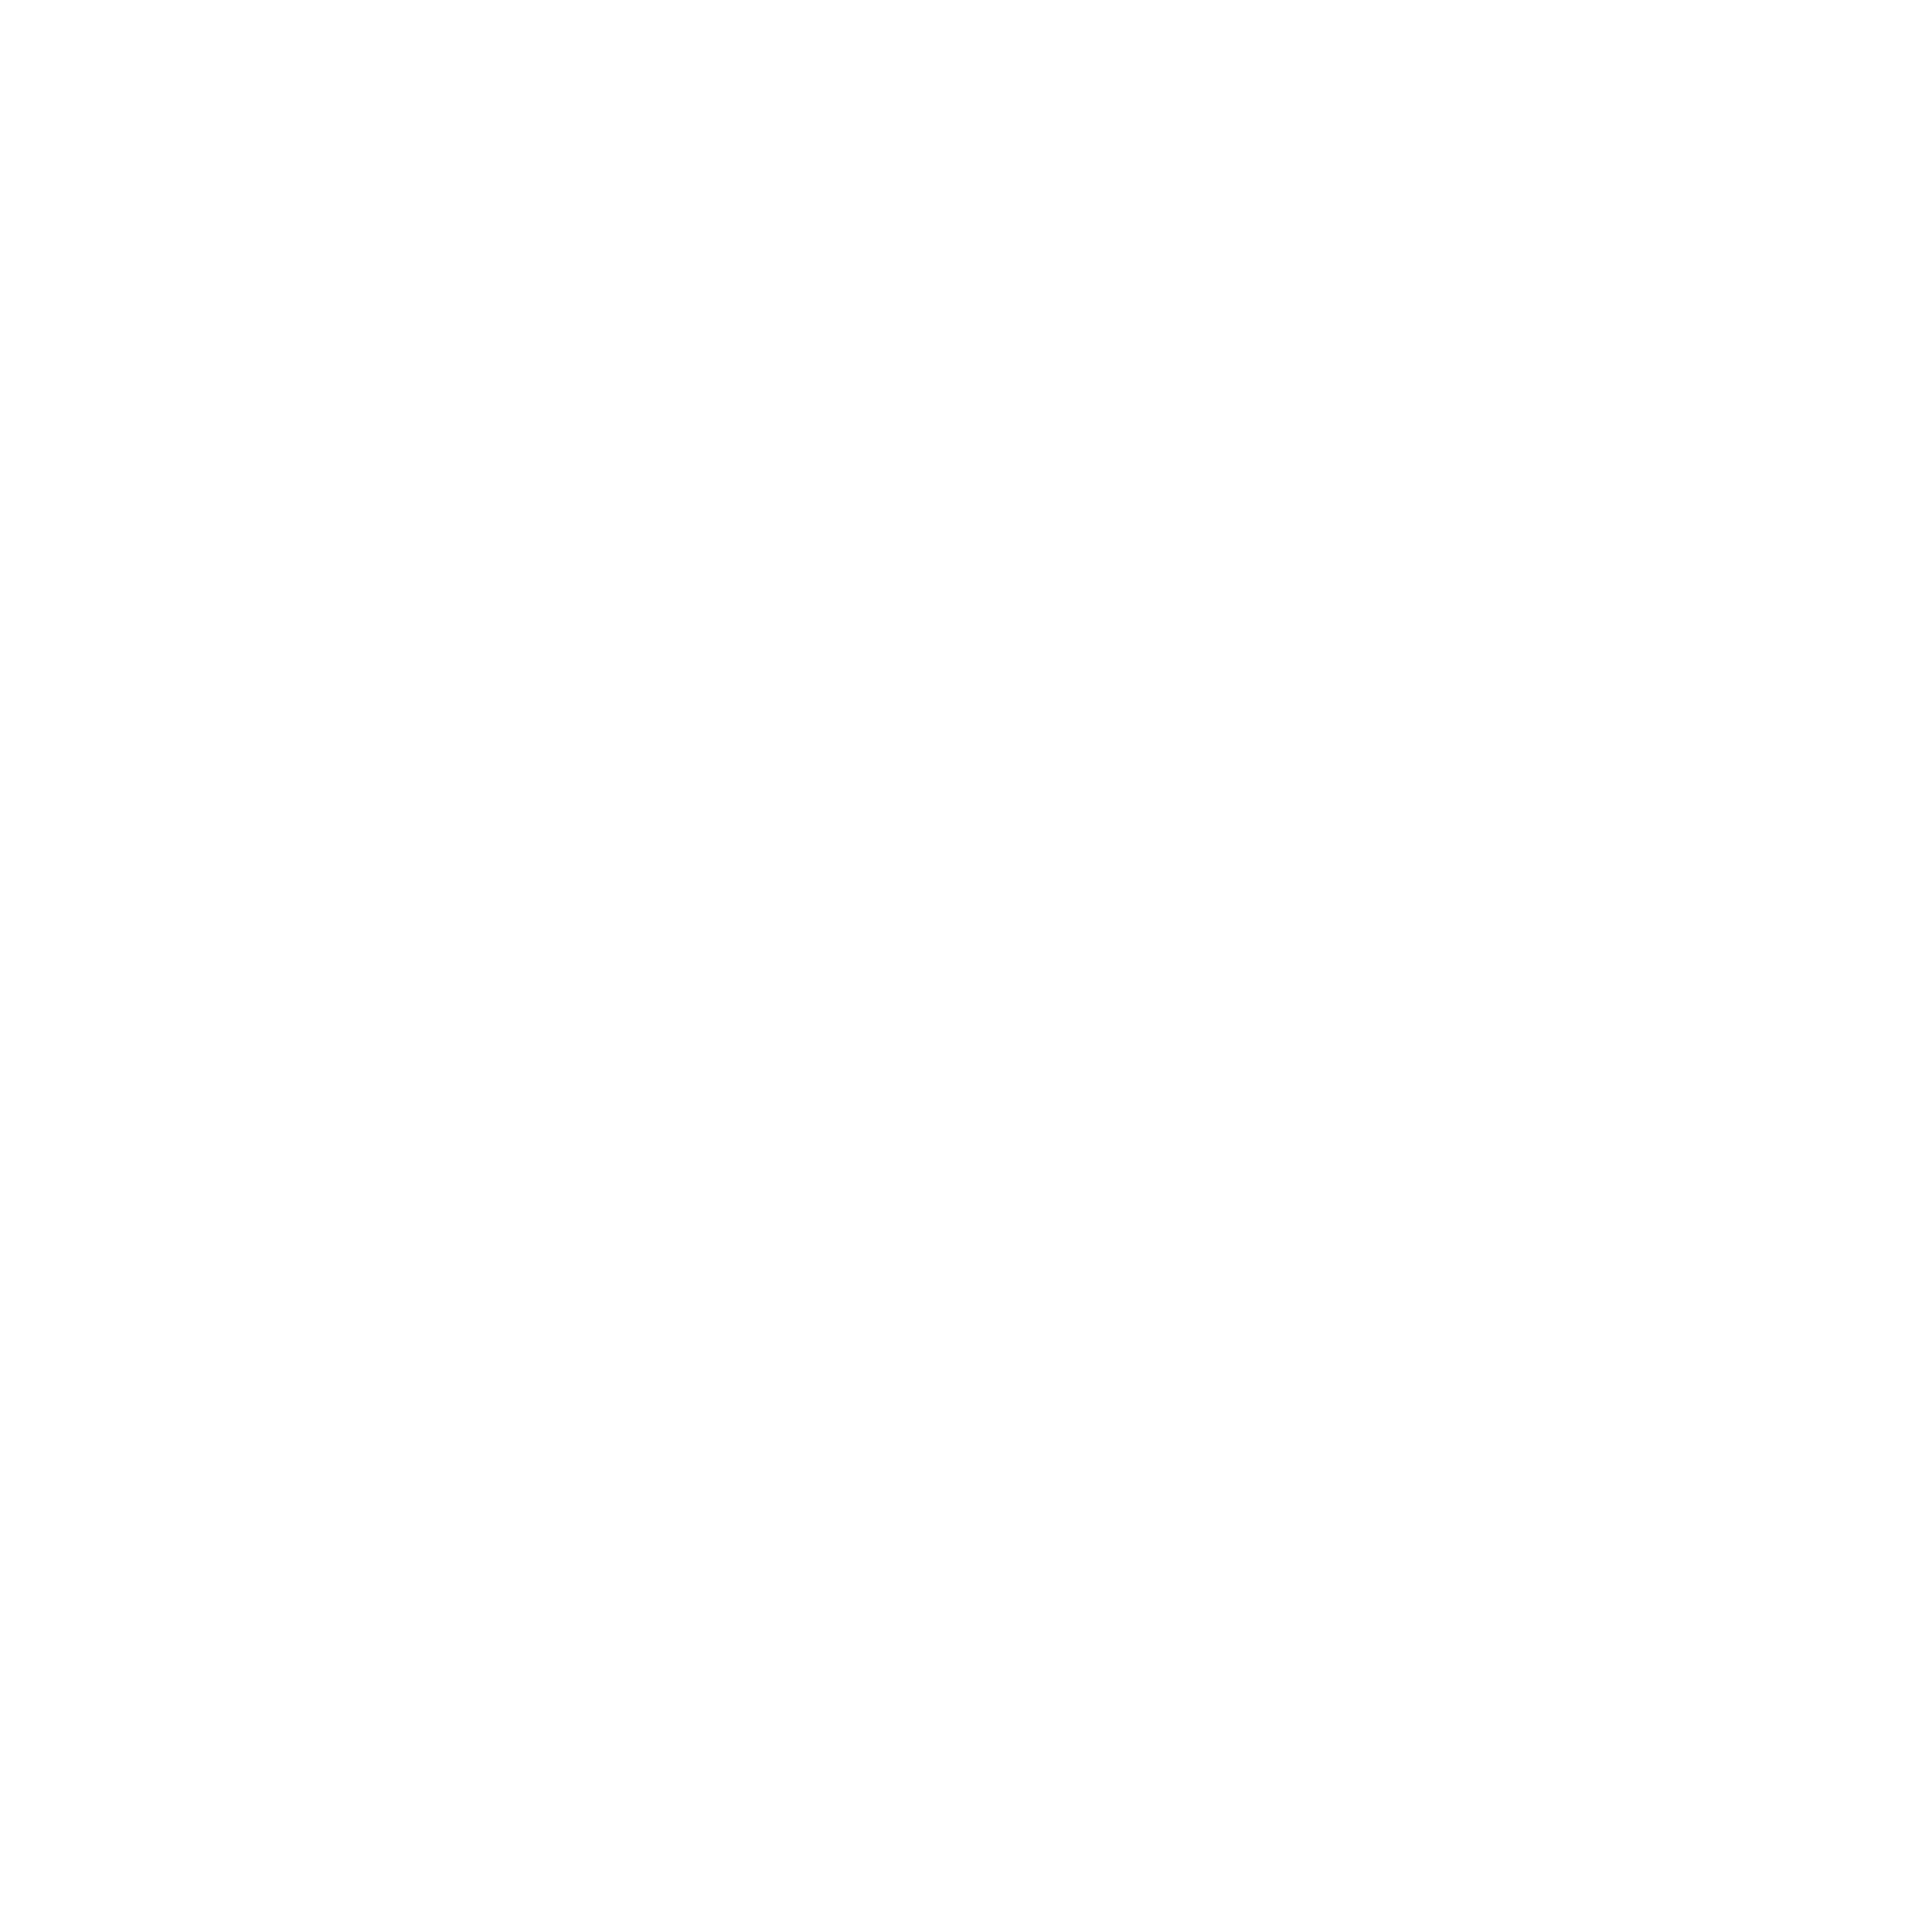

In [14]:
from matplotlib import animation
%matplotlib notebook

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')

u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)

x = 21 * np.outer(np.cos(u), np.sin(v))
y = 21 * np.outer(np.sin(u), np.sin(v))
z = 21 * np.outer(np.ones(np.size(u)), np.cos(v))

def update(i):
    if i == 0:
        ax.clear()
        ax.plot_surface(x, y, z,  rstride=4, cstride=4, linewidth=0, alpha=0.1)
        ax.quiver(0,0,0,21,0,0,arrow_length_ratio=0.01, color='b')
        ax.text(15,0,1,'r=21',size=15, color='b')
    elif i == 1:
        ax.scatter(mean_feature_embed.T[0], mean_feature_embed.T[1], mean_feature_embed.T[2], color='red')
    else:
        ax.scatter(mean_concept_in_feat_cat_na[0], mean_concept_in_feat_cat_na[1], mean_concept_in_feat_cat_na[2])
    ax.axes.set_xlim3d(left=-30, right=20) 
    ax.axes.set_ylim3d(bottom=-30, top=20) 
    ax.axes.set_zlim3d(bottom=-30, top=20) 

ani = animation.FuncAnimation(fig, update, frames=3, interval=1000)
ani.save('../outputs/sphere_feat_concept.gif', writer='pillow')

plt.show()

<IPython.core.display.Javascript object>


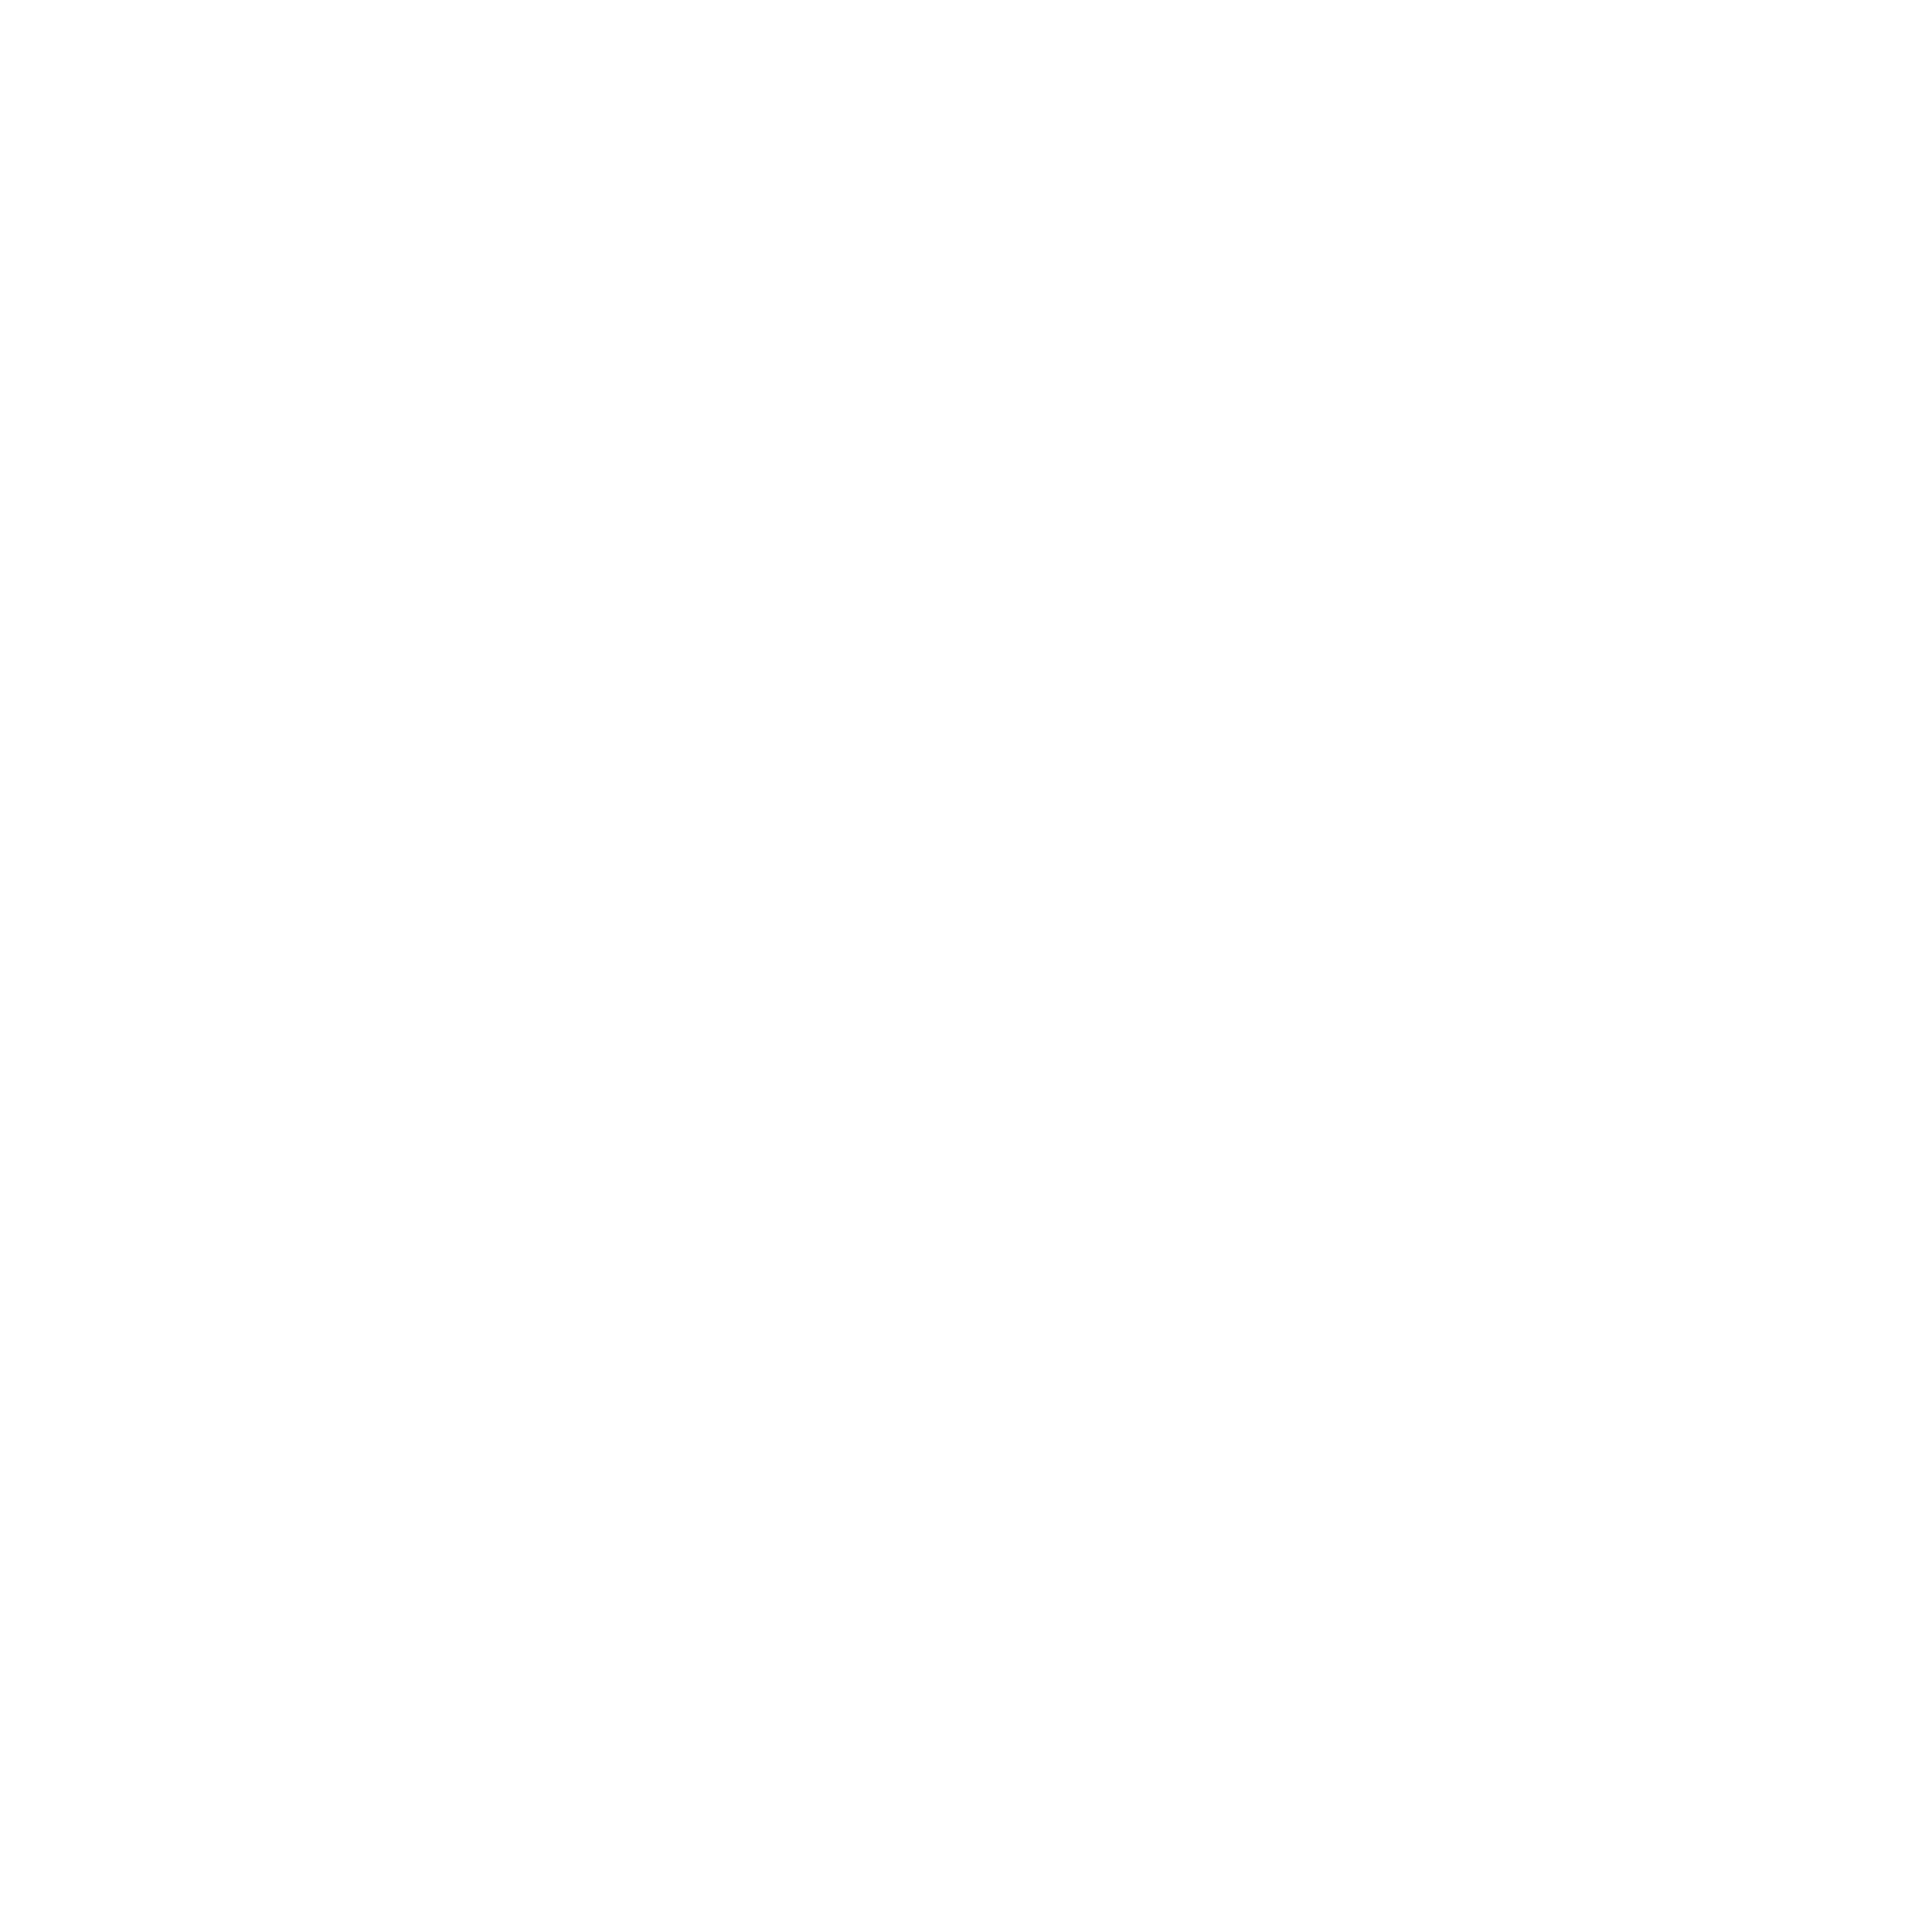

In [15]:
# (original_embeddings@feature_embeddings[:,:,0])[0]
### original_embeddings[0]*feature_embeddings[:,:,0]
from matplotlib import animation
%matplotlib notebook

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')

positions = []
temp = [0,0,0]
for col in range(len(original_embeddings[0])):
    positions.append(temp + np.array([original_embeddings[0][col]*feature_embeddings[col,0,0], original_embeddings[0][col]*feature_embeddings[col,1,0], original_embeddings[0][col]*feature_embeddings[col,2,0]]))
    temp = positions[-1]

def update(i):
    ax.clear()
    ax.scatter(positions[i][0], positions[i][1], positions[i][2], c='b')
    ax.text(positions[i][0], positions[i][1], positions[i][2], i+1)
    ax.scatter(mean_feature_embed[i][0], mean_feature_embed[i][1], mean_feature_embed[i][2], color='purple')
    ax.scatter(mean_feature_embed.T[0], mean_feature_embed.T[1], mean_feature_embed.T[2], color='red', alpha=0.4)
    ax.axes.set_xlim3d(left=-30, right=20) 
    ax.axes.set_ylim3d(bottom=-30, top=20) 
    ax.axes.set_zlim3d(bottom=-30, top=20) 

ani = animation.FuncAnimation(fig, update, frames=49, interval=200)
ani.save('../outputs/lin_comb_concept.gif', writer='pillow')

    
plt.show()

### Analysis: coordinates vs. memorability

#### Cartesian coordinates
Cartesian coordinates of concepts explained 9.8% of variance in memorability, where x axis is most influential in memorability, while memorability decreased as coordinates going positively along y and z axes. 

In [16]:
### linreg: cartesian coordinates and z-score memorability
# normalized: R^2 = 0.098, adjusted = 0.096
# mobius: R^2 = 0.072, adjusted = 0.06
# mobius (S=48): R^2 = 0.117
import statsmodels.api as sm
import scipy.stats as stats

zscore_mem = stats.zscore(mean_concept_in_feat_cat['cr'])
mean_concept_constant = sm.add_constant(mean_concept_in_feat_cat[[0,1,2]], prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.098
Model:                            OLS   Adj. R-squared:                  0.096
Method:                 Least Squares   F-statistic:                     66.84
Date:                Thu, 03 Nov 2022   Prob (F-statistic):           4.92e-41
Time:                        14:01:54   Log-Likelihood:                -2535.3
No. Observations:                1854   AIC:                             5079.
Df Residuals:                    1850   BIC:                             5101.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.0785      0.006     13.998      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [17]:
### create a new table to store all regression results
results_index = ['rsquared', 'rsquared_adj', 'coef', 'pvalues', 'AIC', 'BIC', 'F-statistic', 'F-stats-prob', 'Log-Likelihood']
results = pd.DataFrame({'cart_coord_mem':[res.rsquared, res.rsquared_adj, np.array(res.params), np.array(res.pvalues), res.aic, res.bic, res.fvalue, res.f_pvalue, res.llf]}, index=results_index)
results

cart_coord_mem
rsquared                                                 0.097791
rsquared_adj                                             0.096328
coef            [0.07846746009500993, 0.02028530191834521, -0....
pvalues         [2.1373293819470823e-42, 0.0001032603576050088...
AIC                                                   5078.629906
BIC                                                   5100.730309
F-statistic                                             66.841161
F-stats-prob                                                  0.0
Log-Likelihood                                       -2535.314953

#### Polar coordinates
Predicting memorability using polar coordinates: polar coordinates explained less variance in memorability than cartesian coordinates. Vertical angle of concepts in the hyperbolic space is the most influential variable in predicting memorability, where concepts closer to the core are more memorable, and concepts closer to the ceiling/floor of the space are more forgettable. 

In [18]:
### Polar coordinates of concepts in hyperbolic feature space
r, theta, rho = cart_to_polar(mean_concept_in_feat_cat[[0,1,2]].values).T
plt.hist2d(theta, rho,
           bins = 20)

(array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  2.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  2.,  1.,  1.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  6.,  5.,  2.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  2.,  2., 10., 13.,  7.,  2.,  1.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  3.,  1.,  4., 14., 14.,  7.,  5.,  6.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  3.,  4., 11., 22., 20., 15., 10.,  5.,
          1.,  0.,  1.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  4.,  5., 12., 14., 27., 27., 26., 16., 11.,
          5.,  2.,  0.,  0.,  0.,  1.,  1.],
        [ 0.,  0.,  1.,  2.,  3., 14.,  7., 14., 19., 32., 32., 21., 10.,
          3.,  3.,  4.,  5.,  3.,  1.,  0.],
        [ 0.,  2.,  5.,  8., 22.,  9.,  8.,  9.,

In [19]:
### linreg: polar coordinates vs. memorability
# normalized: R^2 = 0.074, adjusted = 0.072
# mobius: R^2 = 0.019, adjusted = 0.018
# mobius (S=48): R^2 = 0.091
zscore_mem = stats.zscore(mean_concept_in_feat_cat['cr'])
mean_concept_constant = sm.add_constant(np.array([r, theta, rho]).T, prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.074
Model:                            OLS   Adj. R-squared:                  0.072
Method:                 Least Squares   F-statistic:                     48.97
Date:                Thu, 03 Nov 2022   Prob (F-statistic):           1.89e-30
Time:                        14:01:54   Log-Likelihood:                -2559.9
No. Observations:                1854   AIC:                             5128.
Df Residuals:                    1850   BIC:                             5150.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0546      0.006     -9.931      0.0

#### Radius
Predicting memorability using radius: radius of concepts in the hyperbolic space explained even smaller variance in memorability. Concepts that have shorter radius are closer to the core of the space and are more memorable. 

<IPython.core.display.Javascript object>


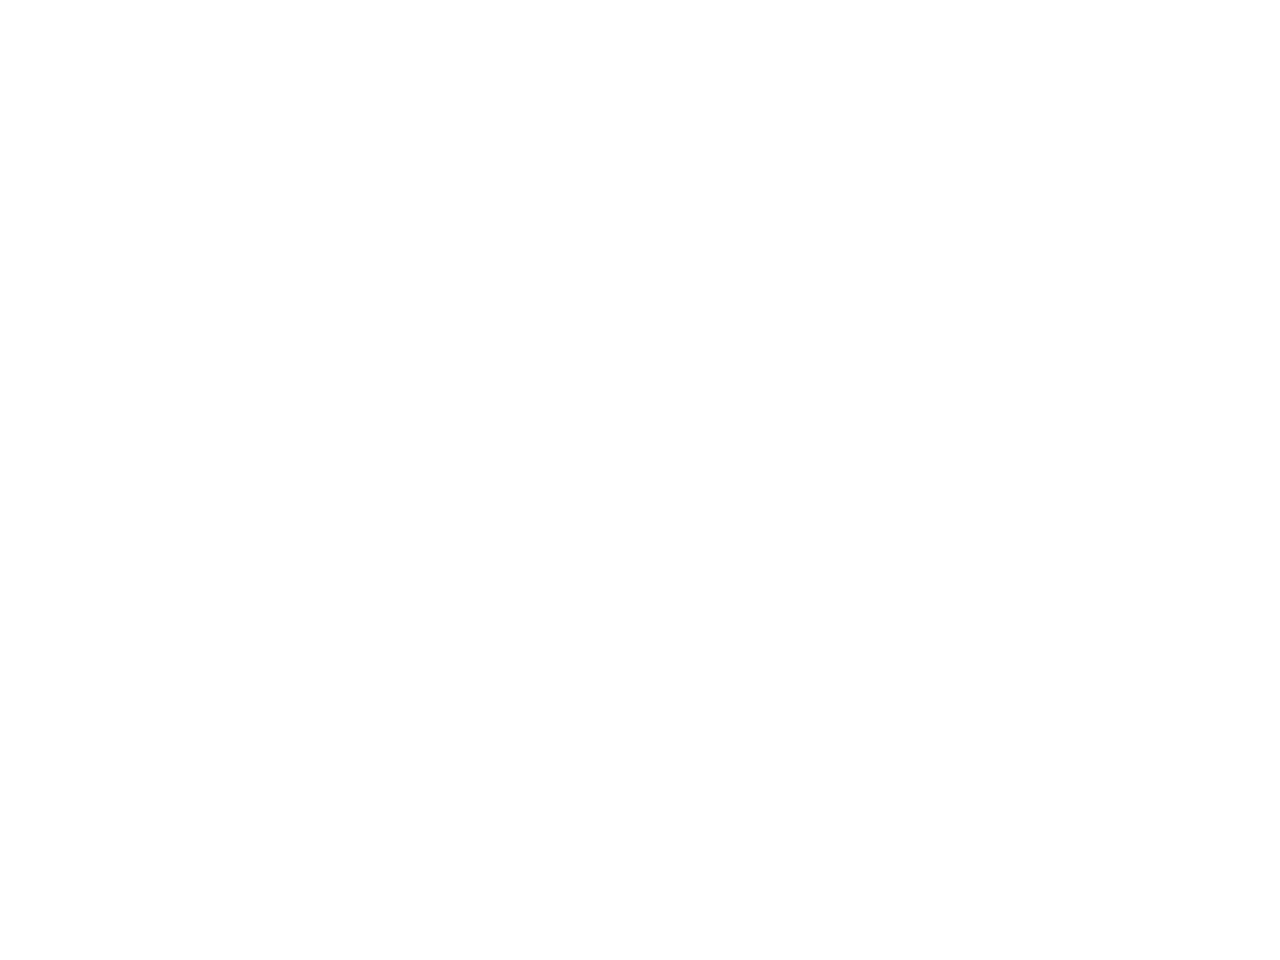

(array([ 43., 119., 218., 329., 406., 369., 229., 114.,  22.,   5.]),
 array([12.38486087, 14.85297531, 17.32108974, 19.78920417, 22.25731861,
        24.72543304, 27.19354747, 29.66166191, 32.12977634, 34.59789077,
        37.06600521]),
 <BarContainer object of 10 artists>)

In [20]:
### Radius
%matplotlib notebook
import matplotlib.pyplot as plt
concept_radius_in_feat = np.sqrt((mean_concept_in_feat_cat[[0,1,2]]**2).sum(1))

plt.clf()
plt.hist(concept_radius_in_feat)

In [21]:
### Radius vs. memorability
# normalized: R^2 = 0.037, adjusted = 0.037
# mobius: R^2 = 0.014, adjusted = 0.013
zscore_mem = stats.zscore(mean_concept_in_feat_cat['cr'])
mean_concept_radius_const = sm.add_constant(concept_radius_in_feat, prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_radius_const)

res = mod.fit()
print(res.summary(xname=['radius','const']))

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.037
Model:                            OLS   Adj. R-squared:                  0.037
Method:                 Least Squares   F-statistic:                     71.58
Date:                Thu, 03 Nov 2022   Prob (F-statistic):           5.33e-17
Time:                        14:01:54   Log-Likelihood:                -2595.6
No. Observations:                1854   AIC:                             5195.
Df Residuals:                    1852   BIC:                             5206.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
radius        -0.0451      0.005     -8.460      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [22]:
results['radius_mem'] = [res.rsquared, res.rsquared_adj, np.array(res.params), np.array(res.pvalues), res.aic, res.bic, res.fvalue, res.f_pvalue, res.llf]
results

cart_coord_mem  \
rsquared                                                 0.097791   
rsquared_adj                                             0.096328   
coef            [0.07846746009500993, 0.02028530191834521, -0....   
pvalues         [2.1373293819470823e-42, 0.0001032603576050088...   
AIC                                                   5078.629906   
BIC                                                   5100.730309   
F-statistic                                             66.841161   
F-stats-prob                                                  0.0   
Log-Likelihood                                       -2535.314953   

                                                      radius_mem  
rsquared                                                0.037211  
rsquared_adj                                            0.036691  
coef                 [-0.045069206500053485, 1.0576830361044065]  
pvalues         [5.3317390331325227e-17, 1.6426550643072648e-16]  
AIC                                                  5195.119413  
BIC                                                  5206.169614  
F-statistic                                            71.577376  
F-stats-prob                                                 0.0  
Log-Likelihood                                      -2595.559706

#### K-Means
Concepts further away from the core are more memorable in all 4 clusters. Vertical angle has most significantly negative relation with memorability, showing that concepts that are vertically further away from origin are more forgettable. 

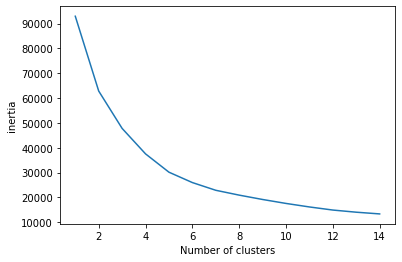

In [23]:
import math

inertia = []
for i in range(1, 15):
    kmeans = KMeans(n_clusters=i, random_state=42).fit(mean_concept_in_feat_cat[[0,1,2]])
#     print(kmeans.inertia_)
    inertia.append(kmeans.inertia_)

%matplotlib inline
plt.plot(range(1, 15), inertia)
plt.xlabel('Number of clusters')
plt.ylabel('inertia') 
plt.show()

In [24]:
### K-Means clustering on concepts
kmeans = KMeans(n_clusters=4, random_state=42).fit(mean_concept_in_feat_cat[[0,1,2]])
labels = kmeans.labels_
concept_coord_cluster = mean_concept_in_feat_cat
concept_coord_cluster['label'] = labels
kmeans.cluster_centers_


array([[-23.5264825 ,  13.32875646,  -3.37891637],
       [-17.95248956,  13.51341043,   0.78618591],
       [-18.7342096 ,   5.11833356,  -2.1847011 ],
       [-13.31458044,   9.12927484,  -8.96434954]])

<IPython.core.display.Javascript object>


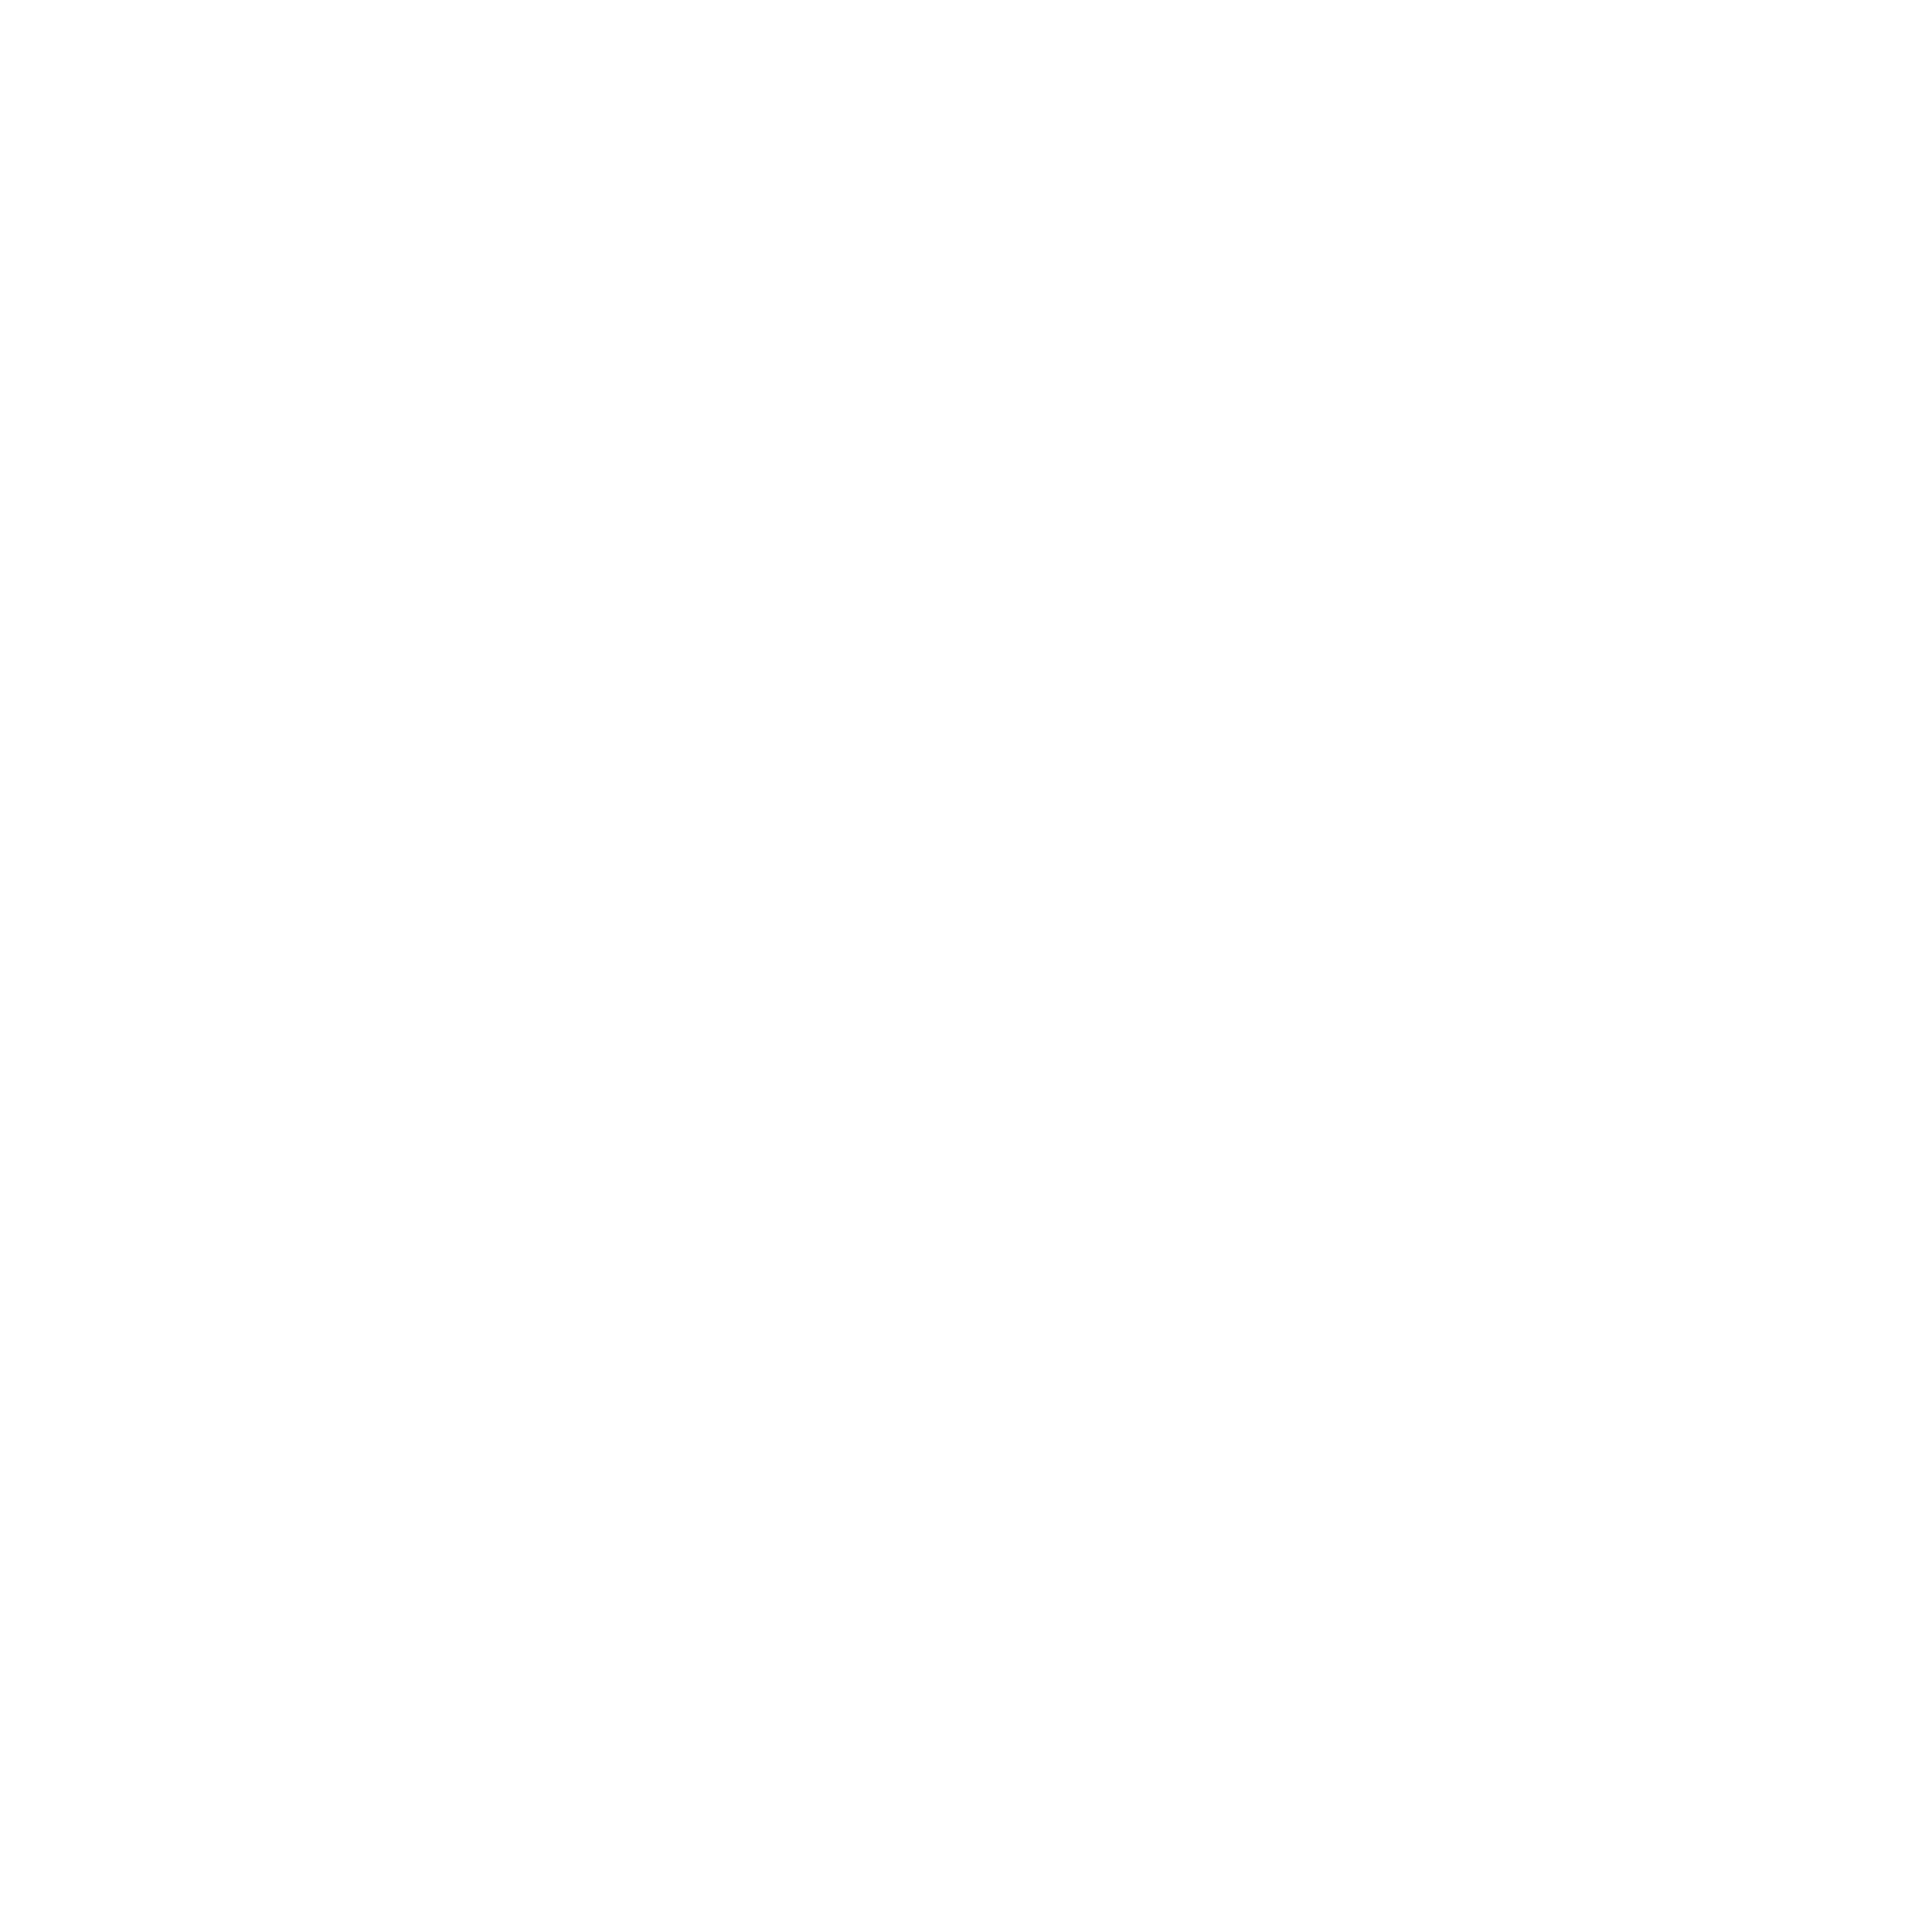

In [25]:
### clusters by memorability and plot concept coordinates in feature space
%matplotlib notebook


fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')

ax.scatter(mean_concept_in_feat_cat[0], mean_concept_in_feat_cat[1], mean_concept_in_feat_cat[2], c=labels, alpha=0.5)


In [26]:
### cluster 0: cartesian coordinates vs. memorability
cluster_0 = concept_coord_cluster[concept_coord_cluster['label'] == 0]
zscore_mem_0 = stats.zscore(cluster_0['cr'])
mean_concept_constant = sm.add_constant(cluster_0[[0,1,2]], prepend=False)
mod_0 = sm.OLS(zscore_mem_0, mean_concept_constant)

res_0 = mod_0.fit()
print(res_0.summary())
results['cluster_cart_mem'] = [[res_0.rsquared], [res_0.rsquared_adj], [np.array(res_0.params)], [np.array(res_0.pvalues)], [res_0.aic], [res_0.bic], [res_0.fvalue], [res_0.f_pvalue], [res_0.llf]]


                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     4.238
Date:                Thu, 03 Nov 2022   Prob (F-statistic):            0.00558
Time:                        14:01:55   Log-Likelihood:                -947.19
No. Observations:                 672   AIC:                             1902.
Df Residuals:                     668   BIC:                             1920.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.0057      0.017      0.330      0.7

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [27]:
### cluster 0: polar coordinates vs. memorability
polar_cluster_0 = cart_to_polar(cluster_0[[0,1,2]].values) - cart_to_polar(concept_coord_cluster[[0,1,2]].values).mean(0)
cluster_0 = concept_coord_cluster[concept_coord_cluster['label'] == 0]
zscore_mem = stats.zscore(cluster_0['cr'])
mean_concept_constant = sm.add_constant(polar_cluster_0, prepend=False)
mod_pol_0 = sm.OLS(zscore_mem, mean_concept_constant)

res_pol_0 = mod_pol_0.fit()
print(res_pol_0.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     4.322
Date:                Thu, 03 Nov 2022   Prob (F-statistic):            0.00497
Time:                        14:01:55   Log-Likelihood:                -947.07
No. Observations:                 672   AIC:                             1902.
Df Residuals:                     668   BIC:                             1920.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0244      0.016      1.559      0.1

In [28]:
### cluster 0: radius vs. memorability
radius_0 = np.sqrt((cluster_0[[0,1,2]]**2).sum(1))
zscore_mem_0 = stats.zscore(cluster_0['cr'])
mean_concept_constant = sm.add_constant(radius_0, prepend=False)
mod_r_0 = sm.OLS(zscore_mem_0, mean_concept_constant)

res_r_0 = mod_r_0.fit()
print(res_r_0.summary())
results['cluster_radius_mem'] = [[res_r_0.rsquared], [res_r_0.rsquared_adj], [np.array(res_r_0.params)], [np.array(res_r_0.pvalues)], [res_r_0.aic], [res_r_0.bic], [res_r_0.fvalue], [res_r_0.f_pvalue], [res_r_0.llf]]


                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     5.125
Date:                Thu, 03 Nov 2022   Prob (F-statistic):             0.0239
Time:                        14:01:55   Log-Likelihood:                -950.97
No. Observations:                 672   AIC:                             1906.
Df Residuals:                     670   BIC:                             1915.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.0345      0.015      2.264      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [29]:
### cluster 1: cartesian coordinates vs. memorability
cluster_1 = concept_coord_cluster[concept_coord_cluster['label'] == 1]
zscore_mem_1 = stats.zscore(cluster_1['cr'])
mean_concept_constant = sm.add_constant(cluster_1[[0,1,2]], prepend=False)
mod_1 = sm.OLS(zscore_mem_1, mean_concept_constant)

res_1 = mod_1.fit()
print(res_1.summary())

row = 0
for stat in [res_1.rsquared, res_1.rsquared_adj, np.array(res_1.params), np.array(res_1.pvalues), res_1.aic, res_1.bic, res_1.fvalue, res_1.f_pvalue, res_1.llf]:
    results.iloc[row]['cluster_cart_mem'].append(stat)
    row += 1

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.318
Model:                            OLS   Adj. R-squared:                  0.314
Method:                 Least Squares   F-statistic:                     92.59
Date:                Thu, 03 Nov 2022   Prob (F-statistic):           3.39e-49
Time:                        14:01:55   Log-Likelihood:                -736.59
No. Observations:                 600   AIC:                             1481.
Df Residuals:                     596   BIC:                             1499.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.1288      0.013      9.992      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [30]:
### cluster 1: polar coordinates vs. memorability
polar_cluster_1 = cart_to_polar(cluster_1[[0,1,2]].values) - cart_to_polar(concept_coord_cluster[[0,1,2]].values).mean(0)
cluster_1 = concept_coord_cluster[concept_coord_cluster['label'] == 1]
zscore_mem = stats.zscore(cluster_1['cr'])
mean_concept_constant = sm.add_constant(polar_cluster_1, prepend=False)
mod_pol_1 = sm.OLS(zscore_mem, mean_concept_constant)

res_pol_1 = mod_pol_1.fit()
print(res_pol_1.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.311
Model:                            OLS   Adj. R-squared:                  0.307
Method:                 Least Squares   F-statistic:                     89.52
Date:                Thu, 03 Nov 2022   Prob (F-statistic):           7.87e-48
Time:                        14:01:55   Log-Likelihood:                -739.77
No. Observations:                 600   AIC:                             1488.
Df Residuals:                     596   BIC:                             1505.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0189      0.013     -1.434      0.1

In [31]:
### cluster 1: radius vs. memorability
radius_1 = np.sqrt((cluster_1[[0,1,2]]**2).sum(1))
zscore_mem_1 = stats.zscore(cluster_1['cr'])
mean_concept_constant = sm.add_constant(radius_1, prepend=False)
mod_r_1 = sm.OLS(zscore_mem_1, mean_concept_constant)

res_r_1 = mod_r_1.fit()
print(res_r_1.summary())

row = 0
for stat in [res_r_1.rsquared, res_r_1.rsquared_adj, np.array(res_r_1.params), np.array(res_r_1.pvalues), res_r_1.aic, res_r_1.bic, res_r_1.fvalue, res_r_1.f_pvalue, res_r_1.llf]:
    results.iloc[row]['cluster_radius_mem'].append(stat)
    row += 1

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.1913
Date:                Thu, 03 Nov 2022   Prob (F-statistic):              0.662
Time:                        14:01:55   Log-Likelihood:                -851.27
No. Observations:                 600   AIC:                             1707.
Df Residuals:                     598   BIC:                             1715.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.0068      0.016      0.437      0.6

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [32]:
#### cluster 2: cartesian coordinates vs. memorability
cluster_2 = concept_coord_cluster[concept_coord_cluster['label'] == 2]
zscore_mem_2 = stats.zscore(cluster_2['cr'])
mean_concept_constant = sm.add_constant(cluster_2[[0,1,2]], prepend=False)
mod_2 = sm.OLS(zscore_mem_2, mean_concept_constant)

res_2 = mod_2.fit()
print(res_2.summary())

row = 0
for stat in [res_2.rsquared, res_2.rsquared_adj, np.array(res_2.params), np.array(res_2.pvalues), res_2.aic, res_2.bic, res_2.fvalue, res_2.f_pvalue, res_2.llf]:
    results.iloc[row]['cluster_cart_mem'].append(stat)
    row += 1

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.110
Model:                            OLS   Adj. R-squared:                  0.103
Method:                 Least Squares   F-statistic:                     16.65
Date:                Thu, 03 Nov 2022   Prob (F-statistic):           3.22e-10
Time:                        14:01:55   Log-Likelihood:                -556.56
No. Observations:                 409   AIC:                             1121.
Df Residuals:                     405   BIC:                             1137.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.0665      0.023     -2.923      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [33]:
### cluster 2: polar coordinates vs. memorability
polar_cluster_2 = cart_to_polar(cluster_2[[0,1,2]].values) - cart_to_polar(concept_coord_cluster[[0,1,2]].values).mean(0)
cluster_2 = concept_coord_cluster[concept_coord_cluster['label'] == 2]
zscore_mem = stats.zscore(cluster_2['cr'])
mean_concept_constant = sm.add_constant(polar_cluster_2, prepend=False)
mod_pol_2 = sm.OLS(zscore_mem, mean_concept_constant)

res_pol_2 = mod_pol_2.fit()
print(res_pol_2.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.100
Model:                            OLS   Adj. R-squared:                  0.093
Method:                 Least Squares   F-statistic:                     15.01
Date:                Thu, 03 Nov 2022   Prob (F-statistic):           2.77e-09
Time:                        14:01:56   Log-Likelihood:                -558.78
No. Observations:                 409   AIC:                             1126.
Df Residuals:                     405   BIC:                             1142.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0245      0.021      1.186      0.2

In [34]:
### cluster 2: radius vs. memorability
radius_2 = np.sqrt((cluster_2[[0,1,2]]**2).sum(1))
zscore_mem_2 = stats.zscore(cluster_2['cr'])
mean_concept_constant = sm.add_constant(radius_2, prepend=False)
mod_r_2 = sm.OLS(zscore_mem_2, mean_concept_constant)

res_r_2 = mod_r_2.fit()
print(res_r_2.summary())

row = 0
for stat in [res_r_2.rsquared, res_r_2.rsquared_adj, np.array(res_r_2.params), np.array(res_r_2.pvalues), res_r_2.aic, res_r_2.bic, res_r_2.fvalue, res_r_2.f_pvalue, res_r_2.llf]:
    results.iloc[row]['cluster_radius_mem'].append(stat)
    row += 1

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     4.600
Date:                Thu, 03 Nov 2022   Prob (F-statistic):             0.0326
Time:                        14:01:56   Log-Likelihood:                -578.05
No. Observations:                 409   AIC:                             1160.
Df Residuals:                     407   BIC:                             1168.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.0392      0.018     -2.145      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [35]:
### cluster 3: cartesian coordinates vs. memorability
cluster_3 = concept_coord_cluster[concept_coord_cluster['label'] == 3]
zscore_mem_3 = stats.zscore(cluster_3['cr'])
mean_concept_constant = sm.add_constant(cluster_3[[0,1,2]], prepend=False)
mod_3 = sm.OLS(zscore_mem_3, mean_concept_constant)

res_3 = mod_3.fit()
print(res_3.summary())

row = 0
for stat in [res_3.rsquared, res_3.rsquared_adj, np.array(res_3.params), np.array(res_3.pvalues), res_3.aic, res_3.bic, res_3.fvalue, res_3.f_pvalue, res_3.llf]:
    results.iloc[row]['cluster_cart_mem'].append(stat)
    row += 1

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.177
Model:                            OLS   Adj. R-squared:                  0.163
Method:                 Least Squares   F-statistic:                     12.15
Date:                Thu, 03 Nov 2022   Prob (F-statistic):           3.08e-07
Time:                        14:01:56   Log-Likelihood:                -228.59
No. Observations:                 173   AIC:                             465.2
Df Residuals:                     169   BIC:                             477.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.1483      0.032      4.663      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [36]:
### cluster 3: polar coordinates vs. memorability
polar_cluster_3 = cart_to_polar(cluster_3[[0,1,2]].values) - cart_to_polar(concept_coord_cluster[[0,1,2]].values).mean(0)
cluster_3 = concept_coord_cluster[concept_coord_cluster['label'] == 3]
zscore_mem = stats.zscore(cluster_3['cr'])
mean_concept_constant = sm.add_constant(polar_cluster_3, prepend=False)
mod_pol_3 = sm.OLS(zscore_mem, mean_concept_constant)

res_pol_3 = mod_pol_3.fit()
print(res_pol_3.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.173
Model:                            OLS   Adj. R-squared:                  0.159
Method:                 Least Squares   F-statistic:                     11.82
Date:                Thu, 03 Nov 2022   Prob (F-statistic):           4.54e-07
Time:                        14:01:56   Log-Likelihood:                -229.00
No. Observations:                 173   AIC:                             466.0
Df Residuals:                     169   BIC:                             478.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0284      0.028     -1.014      0.3

In [37]:
### cluster 3: radius vs. memorability
radius_3 = np.sqrt((cluster_3[[0,1,2]]**2).sum(1))
zscore_mem_3 = stats.zscore(cluster_3['cr'])
mean_concept_constant = sm.add_constant(radius_3, prepend=False)
mod_r_3 = sm.OLS(zscore_mem_3, mean_concept_constant)

res_r_3 = mod_r_3.fit()
print(res_r_3.summary())

row = 0
for stat in [res_r_3.rsquared, res_r_3.rsquared_adj, np.array(res_r_3.params), np.array(res_r_3.pvalues), res_r_3.aic, res_r_3.bic, res_r_3.fvalue, res_r_3.f_pvalue, res_r_3.llf]:
    results.iloc[row]['cluster_radius_mem'].append(stat)
    row += 1

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     4.544
Date:                Thu, 03 Nov 2022   Prob (F-statistic):             0.0345
Time:                        14:01:56   Log-Likelihood:                -243.21
No. Observations:                 173   AIC:                             490.4
Df Residuals:                     171   BIC:                             496.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.0471      0.022     -2.132      0.0

<IPython.core.display.Javascript object>


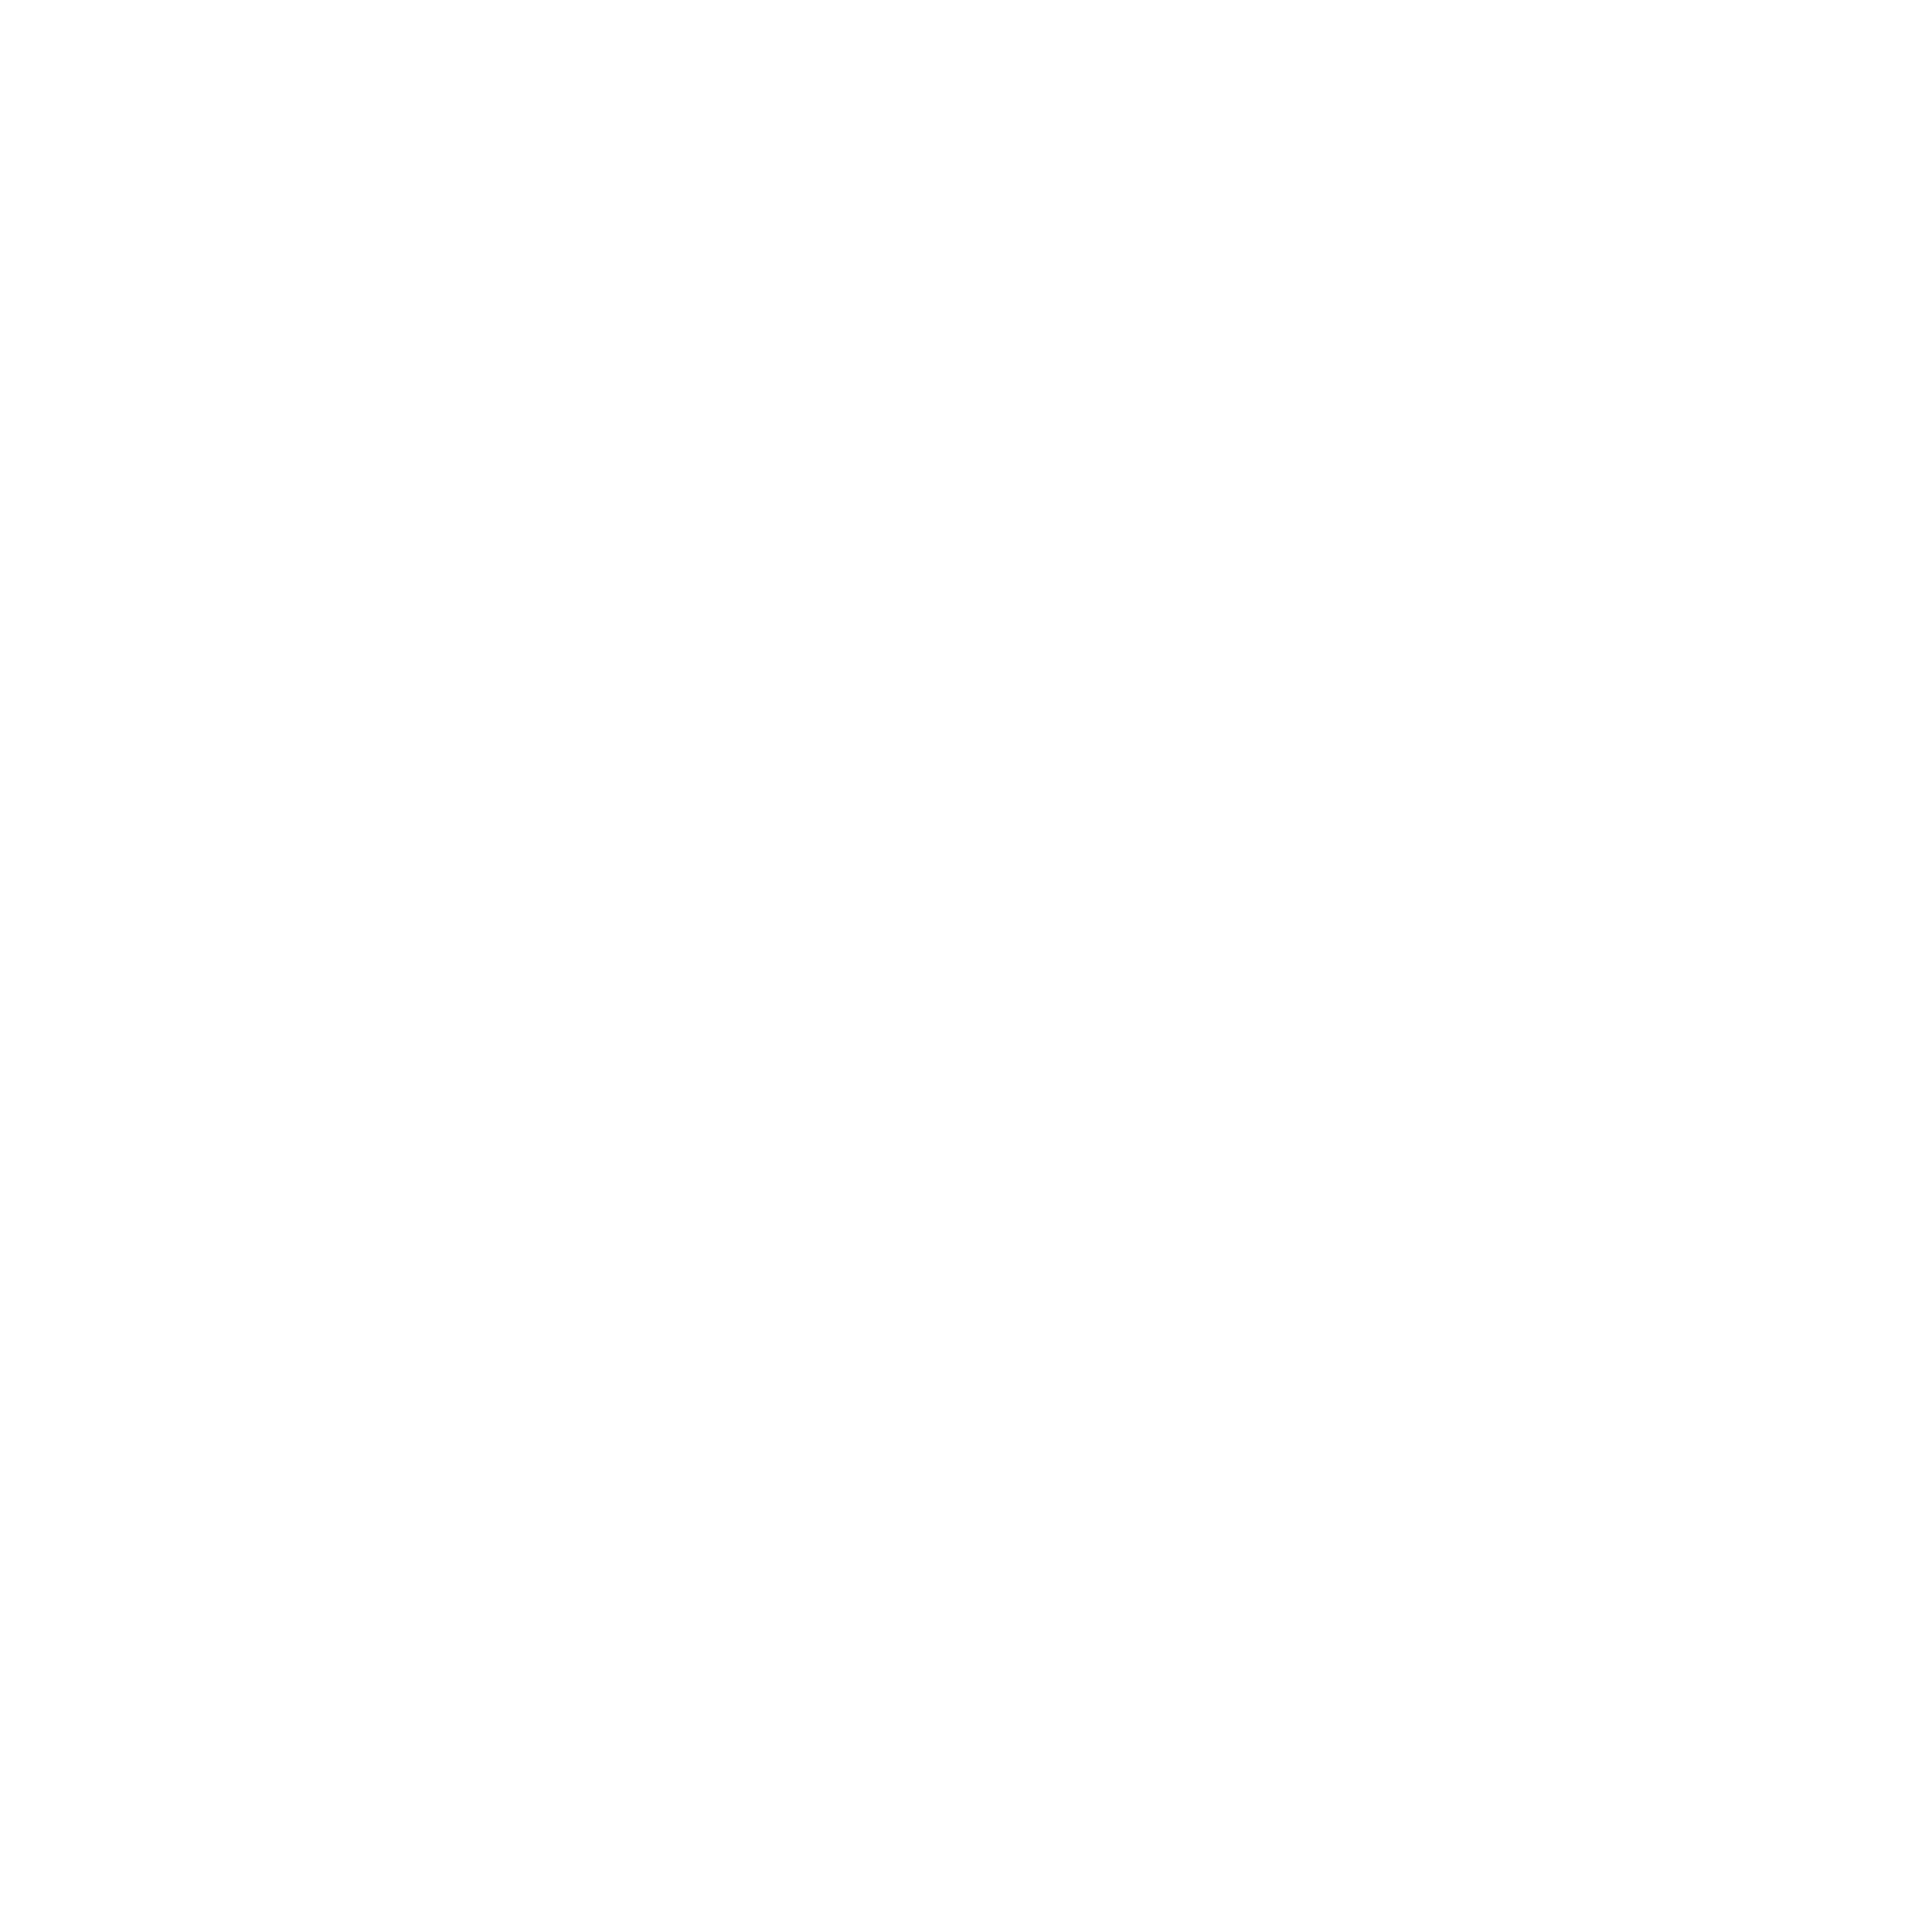

In [38]:
from matplotlib import animation
%matplotlib notebook

# plt.clf()
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')

ax.scatter(cluster_0[0], cluster_0[1], cluster_0[2], label='cluster_0', alpha=0.7)
ax.scatter(cluster_1[0], cluster_1[1], cluster_1[2], label='cluster_1', alpha=0.7)
ax.scatter(cluster_2[0], cluster_2[1], cluster_2[2], label='cluster_2', alpha=0.7)
ax.scatter(cluster_3[0], cluster_3[1], cluster_3[2], label='cluster_3', alpha=0.7)

def animate(frame):
    ax.view_init(10, frame)
    plt.pause(.0001)
    return fig

anim = animation.FuncAnimation(fig, animate, frames=50, interval=1, repeat=False)
anim.save('../outputs/concept_cluster_rotate.gif', writer='pillow')

plt.legend()


<IPython.core.display.Javascript object>


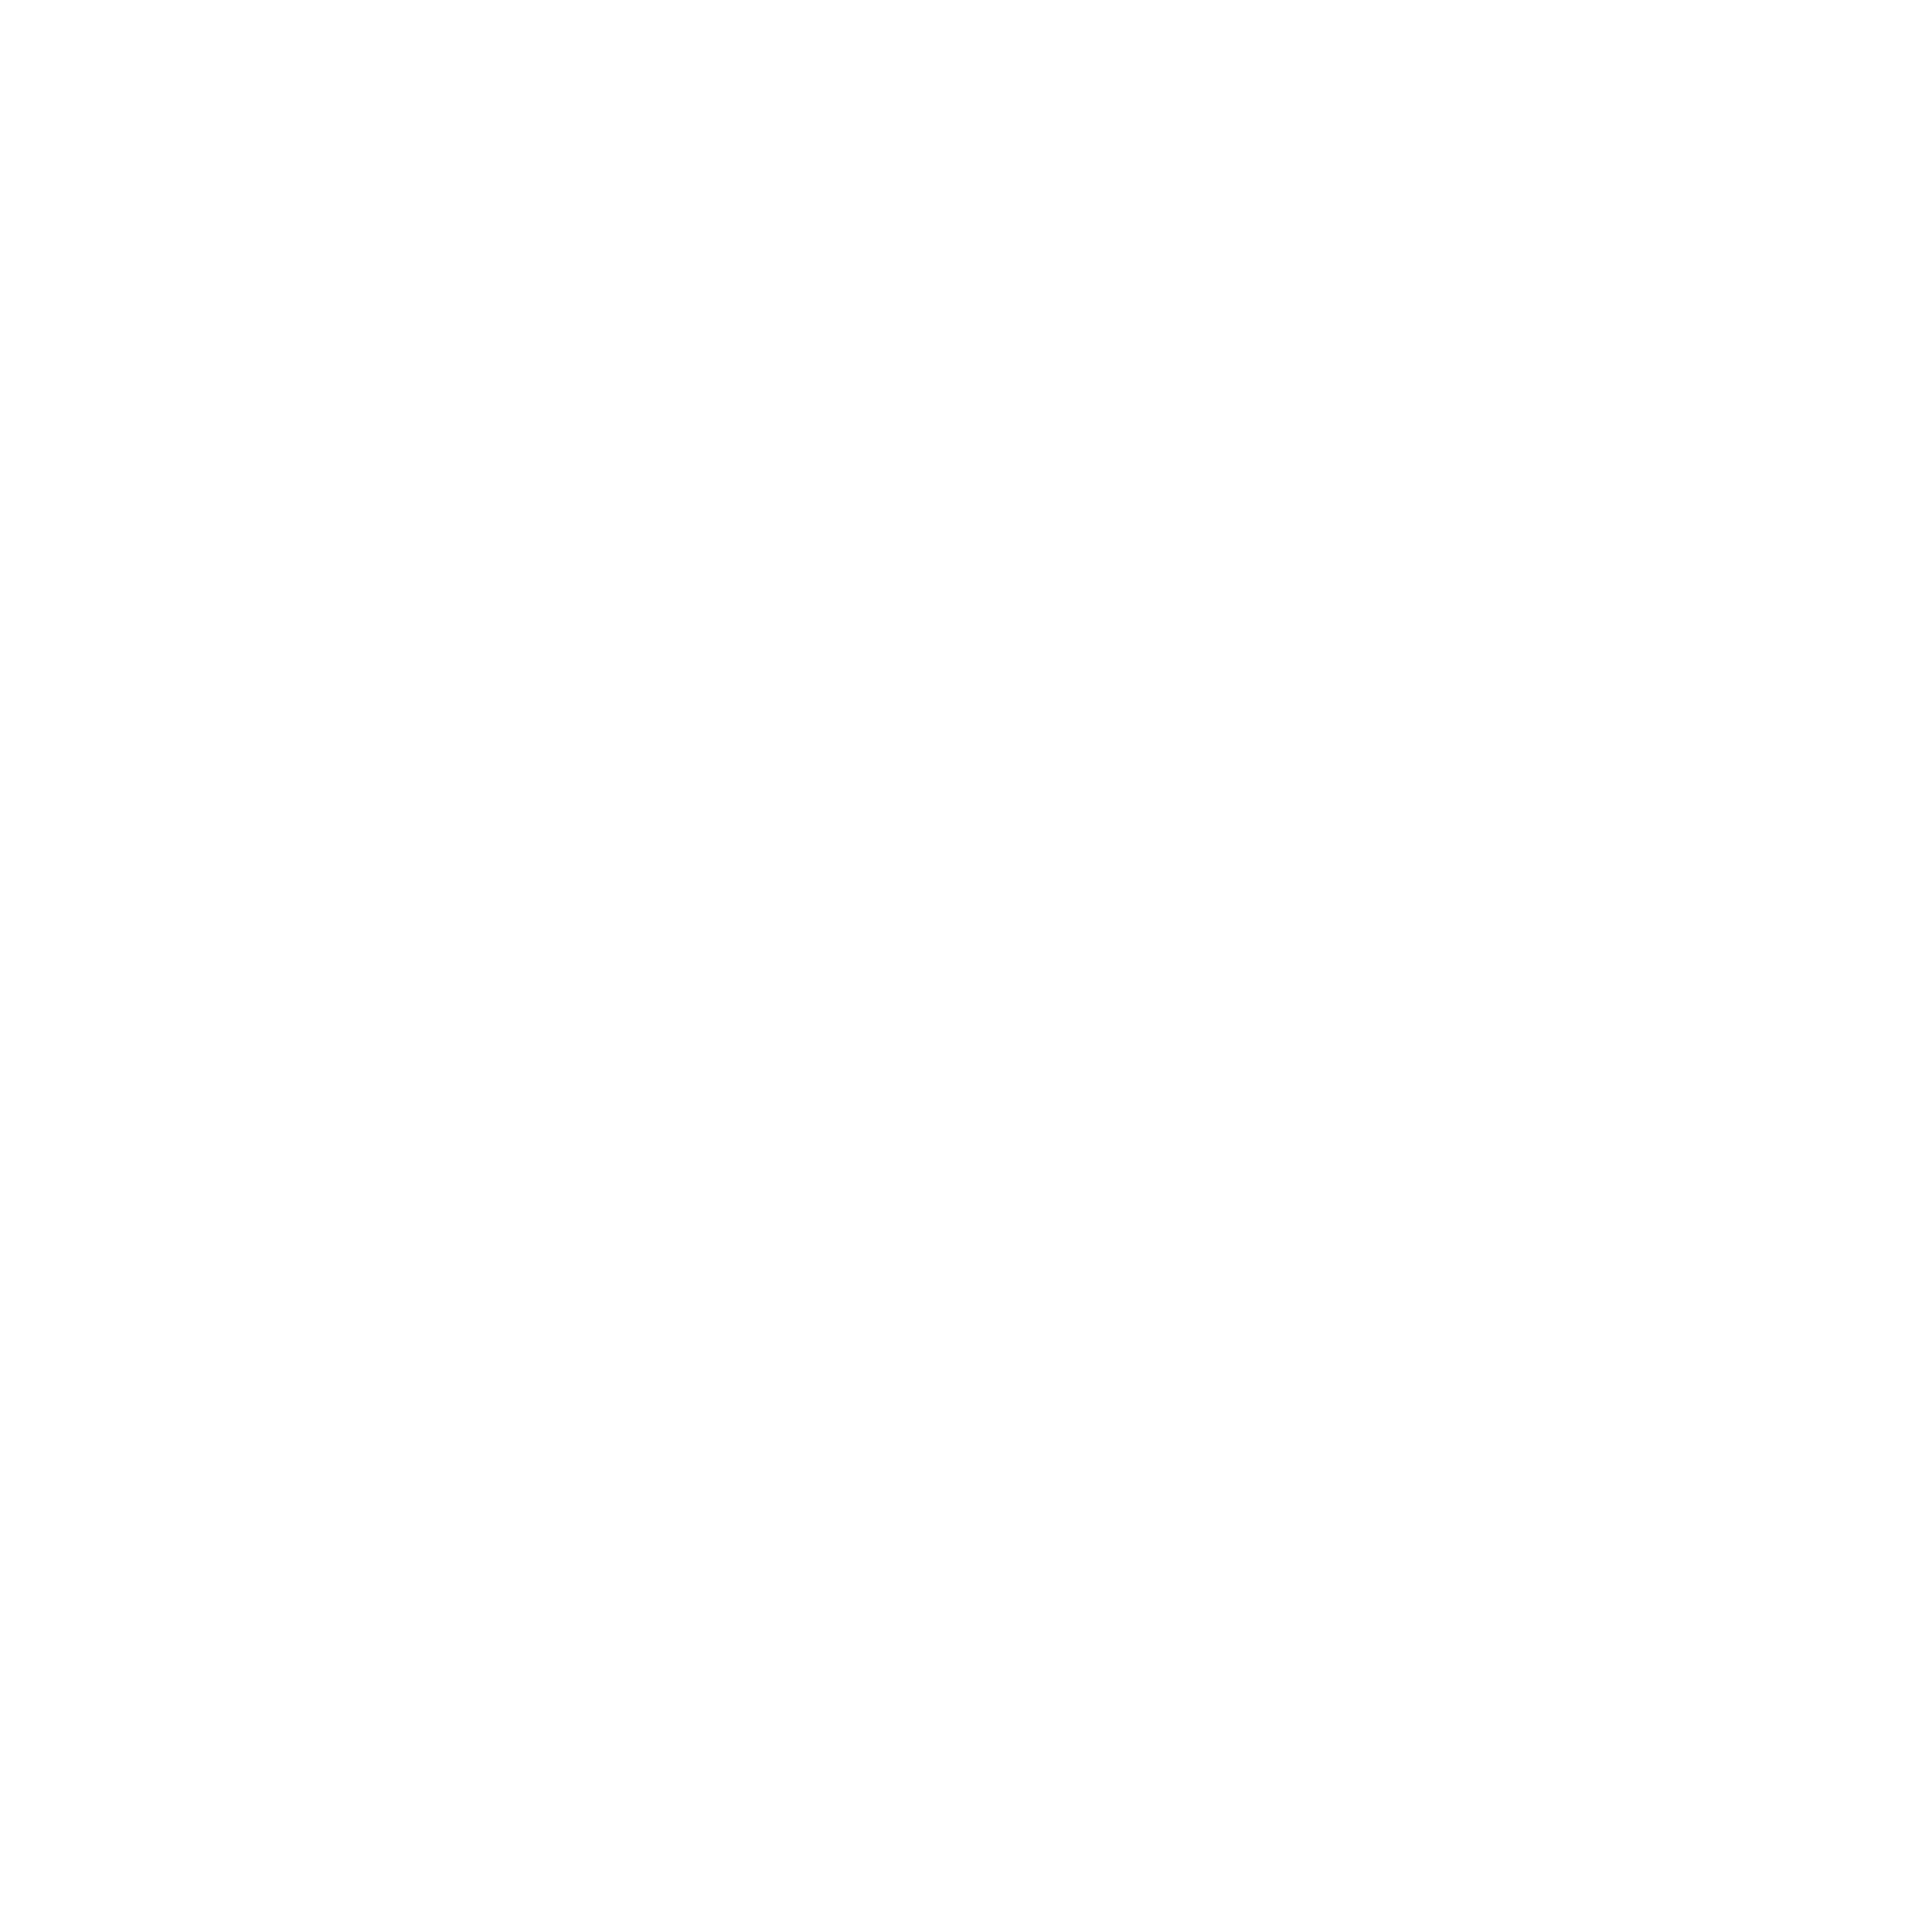

In [39]:
### Memorability changes by coordinates in each cluster
# normalized: highest R^2 (cluster 1) = 0.318
# mobius: highest R^2 (cluster 3) = 0.123

%matplotlib notebook

# plt.clf()
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')

ax.scatter(cluster_0[0], cluster_0[1], cluster_0[2], label='cluster_0', alpha=0.3)
# ax.plot(np.linspace(-30,-20,100), np.linspace(10,20,100), -2.5+-.5+np.linspace(-30,-20,100)*.0057+ np.linspace(10,20,100)*.0509+ np.linspace(-7.5, 2.5, 100)*.0108, label='cluster_0', alpha=1)
# ax.plot(np.linspace(-15,-5,100), np.linspace(5,15,100), -.3135+np.linspace(-15,-5,100)*.1324+ np.linspace(5,15,100)*.1098+ np.linspace(-5, 5, 100)*-.0734, label='cluster_0', alpha=1)
ax.quiver(-30, 10, -7.5, 10, 10, 10, length = 10, normalize = True, color='blue')


# c0_grid = np.meshgrid(np.linspace(-20,-30,100), np.linspace(10,20,100))
# ax.plot_surface(c0_grid[0], c0_grid[1], -.5+X*.0057+ Y*.0509, label='cluster_0', alpha=1)

ax.scatter(cluster_1[0], cluster_1[1], cluster_1[2], label='cluster_1', alpha=0.3)
# ax.plot(np.linspace(-20,-10,100), np.linspace(10,20,100), .59+np.linspace(-20,-10,100)*.1288+ np.linspace(10,20,100)*.1266+ np.linspace(-5, 5, 100)*.0101, label='cluster_1', alpha=1)
# ax.plot(np.linspace(-20,-10,100), np.linspace(-2.5,7.5,100), -1.5349+np.linspace(-20,-10,100)*-.1115+ np.linspace(-2.5,7.5,100)*-.0823+ np.linspace(-5, 5, 100)*.0273, label='cluster_1', alpha=1)
ax.quiver(-20, 10, -5, 10, 10, 10, length = 10, normalize = True, color='orange')


# c1_grid = np.meshgrid(np.linspace(-10,-20,100), np.linspace(10,20,100))
# ax.plot_surface(c1_grid[0], c1_grid[1], .59+X*.1288+ Y*.1266, label='cluster_1', alpha=1)

ax.scatter(cluster_2[0], cluster_2[1], cluster_2[2], label='cluster_2', alpha=0.3)
# ax.plot(np.linspace(-25,-15,100), np.linspace(0,10,100), -.49+np.linspace(-25,-15,100)*-.0665+ np.linspace(0,10,100)*-.1488+ np.linspace(-7.5, 2.5, 100)*-.0007, label='cluster_2', alpha=1)
# ax.plot(np.linspace(-15,-5,100), np.linspace(10,0,100), 1.6519+np.linspace(-15,-5,100)*.1747+ np.linspace(10,0,100)*-.0601+ np.linspace(0, 10, 100)*.0127, label='cluster_2', alpha=1)
ax.quiver(-15, 0, 2.5, -10, 10, -10, length = 10, normalize = True, color='green')


# c2_grid = np.meshgrid(np.linspace(-25,-15,100), np.linspace(0,10,100))
# ax.plot_surface(c2_grid[0], c2_grid[1], -.49+X*-.0665+ Y*-.1488, label='cluster_2', alpha=1)

ax.scatter(cluster_3[0], cluster_3[1], cluster_3[2], label='cluster_3', alpha=0.3)
# ax.plot(np.linspace(-20,-10,100), np.linspace(5,15,100), -10+.47+np.linspace(-20,-10,100)*.1483+ np.linspace(5,15,100)*.1887+ np.linspace(-12.5, -7.5, 100)*.0244, label='cluster_3', alpha=1)
# ax.plot(np.linspace(-17.5,-7.5,100), np.linspace(10,0,100), 1.0544+np.linspace(-17.5,-7.5,100)*.1962+ np.linspace(10,0,100)*-.1758+ np.linspace(0, -10, 100)*.0596, label='cluster_3', alpha=1)
ax.quiver(-20, 5, -12.5, 10, 10, 10, length = 10, normalize = True, color='red')


# c3_grid = np.meshgrid(np.linspace(-10,-20,100), np.linspace(5,15,100))
# ax.plot_surface(c3_grid[0], c3_grid[1], .47+X*.1483+ Y*.1887, label='cluster_3', alpha=1)

ax.scatter(mean_feature_embed.T[0], mean_feature_embed.T[1], mean_feature_embed.T[2], color='purple', alpha=.3)

plt.legend()


In [40]:
r_squared = 1 - (sum((zscore_mem_0 - res_0.fittedvalues)**2) + sum((zscore_mem_1 - res_1.fittedvalues)**2) + sum((zscore_mem_2 - res_2.fittedvalues)**2) + sum((zscore_mem_3 - res_3.fittedvalues)**2)) / (sum((zscore_mem_0 - zscore_mem_0.mean())**2) + sum((zscore_mem_1 - zscore_mem_1.mean())**2) + sum((zscore_mem_2 - zscore_mem_2.mean())**2) + sum((zscore_mem_3 - zscore_mem_3.mean())**2))
results.iloc[0]['cluster_cart_mem'].append(r_squared)
r_squared

0.1504157690242467

In [41]:
r_squared = 1 - (sum((zscore_mem_0 - res_pol_0.fittedvalues)**2) + sum((zscore_mem_1 - res_pol_1.fittedvalues)**2) + sum((zscore_mem_2 - res_pol_2.fittedvalues)**2) + sum((zscore_mem_3 - res_pol_3.fittedvalues)**2)) / (sum((zscore_mem_0 - zscore_mem_0.mean())**2) + sum((zscore_mem_1 - zscore_mem_1.mean())**2) + sum((zscore_mem_2 - zscore_mem_2.mean())**2) + sum((zscore_mem_3 - zscore_mem_3.mean())**2))
r_squared

0.14569454587996755

In [42]:
r_squared = 1 - (sum((zscore_mem_0 - res_r_0.fittedvalues)**2) + sum((zscore_mem_1 - res_r_1.fittedvalues)**2) + sum((zscore_mem_2 - res_r_2.fittedvalues)**2) + sum((zscore_mem_3 - res_r_3.fittedvalues)**2)) / (sum((zscore_mem_0 - zscore_mem_0.mean())**2) + sum((zscore_mem_1 - zscore_mem_1.mean())**2) + sum((zscore_mem_2 - zscore_mem_2.mean())**2) + sum((zscore_mem_3 - zscore_mem_3.mean())**2))
results.iloc[0]['cluster_radius_mem'].append(r_squared)
r_squared

0.007735721905160586

### Analysis: coordinates, typicality, memorability


In [43]:
def calculate_typicality(group):
    """
    Calculate typicality of each concept using average similarity within category 
    """
    feat_matrix = []
    for concept in group['index']:
        feat_matrix.append(original_embeddings[concept])
    coef_matrix = np.corrcoef(feat_matrix)
    typicality = (np.sum(coef_matrix, axis=1)-1)/len(coef_matrix)
    group['typicality'] = typicality
    return group

In [44]:
grouped = mean_concept_in_feat_cat_na.groupby('bigcat')
grouped = grouped.apply(calculate_typicality)
grouped

index          0          1         2        cr  bigcat  \
0         0  -8.362256   5.447828 -8.557188  0.779739       1   
1         1 -26.123590  12.240625  0.518939  0.798485      13   
2         2 -24.385152  14.180849  0.693800  0.752845      18   
4         4 -20.330699  11.947785 -4.992442  0.794466       9   
5         5 -24.493047  16.661652 -4.482670  0.806000      12   
...     ...        ...        ...       ...       ...     ...   
1847   1847 -18.208906   9.885611  3.776987  0.803129      24   
1848   1848 -19.281246   4.272460 -1.785376  0.765881      10   
1850   1850 -19.551059   2.813812 -2.150868  0.843158      10   
1851   1851 -14.748351   9.486465 -8.609210  0.800163       1   
1853   1853 -18.651758   5.749045 -4.932768  0.823237      10   

                cat_name  typicality  
0                 animal    0.810913  
1             home decor    0.247628  
2     musical instrument    0.624589  
4      electronic device    0.522380  
5              furniture    0.509185  
...                  ...         ...  
1847                 toy    0.246697  
1848                food    0.786900  
1850                food    0.770485  
1851              animal    0.764335  
1853                food    0.705398  

[1324 rows x 8 columns]

In [45]:
### Cartesian coordinates vs. typicality
# normalized: R^2 = 0.479, adjusted = 0.478
# mobius: R^2 = 0.136, adjusted = 0.134

zscore_mem = stats.zscore(grouped['typicality'])
mean_concept_constant = sm.add_constant(grouped[[0,1,2]], prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())
results['cart_typ'] = [res.rsquared, res.rsquared_adj, np.array(res.params), np.array(res.pvalues), res.aic, res.bic, res.fvalue, res.f_pvalue, res.llf]

                            OLS Regression Results                            
Dep. Variable:             typicality   R-squared:                       0.479
Model:                            OLS   Adj. R-squared:                  0.478
Method:                 Least Squares   F-statistic:                     404.4
Date:                Thu, 03 Nov 2022   Prob (F-statistic):          2.80e-186
Time:                        14:01:59   Log-Likelihood:                -1447.1
No. Observations:                1324   AIC:                             2902.
Df Residuals:                    1320   BIC:                             2923.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.0993      0.005     19.365      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [46]:
### Polar coordinates vs. typicality
r, theta, rho = cart_to_polar(grouped[[0,1,2]].values).T

zscore_mem = stats.zscore(grouped['typicality'])
mean_concept_constant = sm.add_constant(np.array([r, theta, rho]).T, prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:             typicality   R-squared:                       0.458
Model:                            OLS   Adj. R-squared:                  0.457
Method:                 Least Squares   F-statistic:                     372.3
Date:                Thu, 03 Nov 2022   Prob (F-statistic):          3.51e-175
Time:                        14:01:59   Log-Likelihood:                -1472.8
No. Observations:                1324   AIC:                             2954.
Df Residuals:                    1320   BIC:                             2974.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.1259      0.005    -23.915      0.0

In [47]:
### Radius vs. typicality
concept_radius_typ = np.sqrt((grouped[[0,1,2]]**2).sum(1))
zscore_mem = stats.zscore(grouped['typicality'])
mean_concept_constant = sm.add_constant(concept_radius_typ, prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary(xname=['radius', 'const']))
results['radius_typ'] = [res.rsquared, res.rsquared_adj, np.array(res.params), np.array(res.pvalues), res.aic, res.bic, res.fvalue, res.f_pvalue, res.llf]

                            OLS Regression Results                            
Dep. Variable:             typicality   R-squared:                       0.388
Model:                            OLS   Adj. R-squared:                  0.388
Method:                 Least Squares   F-statistic:                     838.2
Date:                Thu, 03 Nov 2022   Prob (F-statistic):          3.86e-143
Time:                        14:01:59   Log-Likelihood:                -1553.6
No. Observations:                1324   AIC:                             3111.
Df Residuals:                    1322   BIC:                             3122.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
radius        -0.1494      0.005    -28.951      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [48]:
### typicality vs. memorability
# R^2 = 0.032, adjusted = 0.031

zscore_mem = stats.zscore(grouped['cr'])
mean_concept_constant = sm.add_constant(grouped['typicality'], prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     43.72
Date:                Thu, 03 Nov 2022   Prob (F-statistic):           5.50e-11
Time:                        14:01:59   Log-Likelihood:                -1857.1
No. Observations:                1324   AIC:                             3718.
Df Residuals:                    1322   BIC:                             3729.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
typicality     0.9536      0.144      6.612      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [49]:
### Cartesian coordinates and typicality vs. memorability
zscore_mem = stats.zscore(grouped['cr'])
mean_concept_constant = sm.add_constant(np.array(grouped[[0,1,2,'typicality']]), prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())
results['cart_typ_mem'] = [res.rsquared, res.rsquared_adj, np.array(res.params), np.array(res.pvalues), res.aic, res.bic, res.fvalue, res.f_pvalue, res.llf]

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.107
Model:                            OLS   Adj. R-squared:                  0.104
Method:                 Least Squares   F-statistic:                     39.48
Date:                Thu, 03 Nov 2022   Prob (F-statistic):           2.92e-31
Time:                        14:01:59   Log-Likelihood:                -1803.8
No. Observations:                1324   AIC:                             3618.
Df Residuals:                    1319   BIC:                             3644.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0737      0.008      9.691      0.0

In [50]:
### Polar coordinates and typicality vs. memorability
zscore_mem = stats.zscore(grouped['cr'])
mean_concept_constant = sm.add_constant(np.array([grouped['typicality'], r, theta, rho]).T, prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.084
Model:                            OLS   Adj. R-squared:                  0.082
Method:                 Least Squares   F-statistic:                     30.40
Date:                Thu, 03 Nov 2022   Prob (F-statistic):           3.13e-24
Time:                        14:01:59   Log-Likelihood:                -1820.3
No. Observations:                1324   AIC:                             3651.
Df Residuals:                    1319   BIC:                             3677.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.6734      0.191      3.529      0.0

In [51]:
### Radius and typicality vs. memorability
zscore_mem = stats.zscore(grouped['cr'])
mean_concept_constant = sm.add_constant(np.array([concept_radius_typ, grouped['typicality']]).T, prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary(xname=['radius', 'typicality', 'const']))
results['radius_typ_mem'] = [res.rsquared, res.rsquared_adj, np.array(res.params), np.array(res.pvalues), res.aic, res.bic, res.fvalue, res.f_pvalue, res.llf]

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.046
Model:                            OLS   Adj. R-squared:                  0.044
Method:                 Least Squares   F-statistic:                     31.72
Date:                Thu, 03 Nov 2022   Prob (F-statistic):           3.50e-14
Time:                        14:01:59   Log-Likelihood:                -1847.6
No. Observations:                1324   AIC:                             3701.
Df Residuals:                    1321   BIC:                             3717.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
radius        -0.0360      0.008     -4.374      0.0

#### Cluster level typicality

In [52]:
# ### K-Means clustering on concepts
# kmeans = KMeans(n_clusters=4, random_state=42).fit(grouped[[0,1,2]])
# labels = kmeans.labels_
# concept_coord_cluster = grouped
# concept_coord_cluster['label'] = labels
# kmeans.cluster_centers_


In [53]:
typ_coord_cluster = concept_coord_cluster.merge(grouped[['index','typicality']], how='inner', on='index')
typ_coord_cluster

index          0          1         2        cr  bigcat  \
0         0  -8.362256   5.447828 -8.557188  0.779739       1   
1         1 -26.123590  12.240625  0.518939  0.798485      13   
2         2 -24.385152  14.180849  0.693800  0.752845      18   
3         4 -20.330699  11.947785 -4.992442  0.794466       9   
4         5 -24.493047  16.661652 -4.482670  0.806000      12   
...     ...        ...        ...       ...       ...     ...   
1319   1847 -18.208906   9.885611  3.776987  0.803129      24   
1320   1848 -19.281246   4.272460 -1.785376  0.765881      10   
1321   1850 -19.551059   2.813812 -2.150868  0.843158      10   
1322   1851 -14.748351   9.486465 -8.609210  0.800163       1   
1323   1853 -18.651758   5.749045 -4.932768  0.823237      10   

                cat_name  label  typicality  
0                 animal      3    0.810913  
1             home decor      0    0.247628  
2     musical instrument      0    0.624589  
3      electronic device      0    0.522380  
4              furniture      0    0.509185  
...                  ...    ...         ...  
1319                 toy      1    0.246697  
1320                food      2    0.786900  
1321                food      2    0.770485  
1322              animal      3    0.764335  
1323                food      2    0.705398  

[1324 rows x 9 columns]

In [54]:
### cluster 0: cartesian coordinates + typicality vs. memorability
cluster_0 = typ_coord_cluster[typ_coord_cluster['label'] == 0]
zscore_mem_0 = stats.zscore(cluster_0['cr'])
mean_concept_constant = sm.add_constant(cluster_0[[0,1,2, 'typicality']], prepend=False)
mod_0 = sm.OLS(zscore_mem_0, mean_concept_constant)

res_0 = mod_0.fit()
print(res_0.summary())
results['cluster_cart_typ_mem'] = [[res_0.rsquared], [res_0.rsquared_adj], [np.array(res_0.params)], [np.array(res_0.pvalues)], [res_0.aic], [res_0.bic], [res_0.fvalue], [res_0.f_pvalue], [res_0.llf]]


                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.057
Model:                            OLS   Adj. R-squared:                  0.046
Method:                 Least Squares   F-statistic:                     5.295
Date:                Thu, 03 Nov 2022   Prob (F-statistic):           0.000376
Time:                        14:01:59   Log-Likelihood:                -496.13
No. Observations:                 357   AIC:                             1002.
Df Residuals:                     352   BIC:                             1022.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.0543      0.025      2.152      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [55]:
### cluster 0: cartesian coordinates vs. typicality 
cluster_0 = typ_coord_cluster[typ_coord_cluster['label'] == 0]
zscore_mem_0 = stats.zscore(cluster_0['typicality'])
mean_concept_constant = sm.add_constant(cluster_0[[0,1,2]], prepend=False)
mod_0_typ = sm.OLS(zscore_mem_0, mean_concept_constant)

res_0_typ = mod_0_typ.fit()
print(res_0_typ.summary())
# results['cluster_cart_typ_mem'] = [[res_0.rsquared], [res_0.rsquared_adj], [np.array(res_0.params)], [np.array(res_0.pvalues)], [res_0.aic], [res_0.bic], [res_0.fvalue], [res_0.f_pvalue], [res_0.llf]]


                            OLS Regression Results                            
Dep. Variable:             typicality   R-squared:                       0.162
Model:                            OLS   Adj. R-squared:                  0.155
Method:                 Least Squares   F-statistic:                     22.77
Date:                Thu, 03 Nov 2022   Prob (F-statistic):           1.70e-13
Time:                        14:01:59   Log-Likelihood:                -474.99
No. Observations:                 357   AIC:                             958.0
Df Residuals:                     353   BIC:                             973.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.1408      0.023      6.242      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [56]:
### cluster 0: polar coordinates vs. memorability
polar_cluster_0 = cluster_0.copy()
polar_cluster_0[[0,1,2]] = cart_to_polar(cluster_0[[0,1,2]].values) - cart_to_polar(typ_coord_cluster[[0,1,2]].values).mean(0)
zscore_mem = stats.zscore(cluster_0['cr'])
mean_concept_constant = sm.add_constant(polar_cluster_0[[0,1,2,'typicality']], prepend=False)
mod_pol_0 = sm.OLS(zscore_mem, mean_concept_constant)

res_pol_0 = mod_pol_0.fit()
print(res_pol_0.summary())

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.052
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     4.795
Date:                Thu, 03 Nov 2022   Prob (F-statistic):           0.000888
Time:                        14:01:59   Log-Likelihood:                -497.09
No. Observations:                 357   AIC:                             1004.
Df Residuals:                     352   BIC:                             1024.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.0164      0.024     -0.697      0.4

In [57]:
### cluster 0: radius vs. memorability
polar_cluster_0 = typ_coord_cluster[typ_coord_cluster['label'] == 0]
radius_cluster_0 = pd.concat([np.sqrt((polar_cluster_0.loc[:, 0:2]**2).sum(1)), polar_cluster_0['typicality']], axis=1)
zscore_mem_0 = stats.zscore(polar_cluster_0['cr'])
mean_concept_constant = sm.add_constant(radius_cluster_0[[0, 'typicality']], prepend=False)
mod_r_0 = sm.OLS(zscore_mem_0, mean_concept_constant)

res_r_0 = mod_r_0.fit()
print(res_r_0.summary())
results['cluster_radius_typ_mem'] = [[res_r_0.rsquared], [res_r_0.rsquared_adj], [np.array(res_r_0.params)], [np.array(res_r_0.pvalues)], [res_r_0.aic], [res_r_0.bic], [res_r_0.fvalue], [res_r_0.f_pvalue], [res_r_0.llf]]


                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     3.311
Date:                Thu, 03 Nov 2022   Prob (F-statistic):             0.0376
Time:                        14:01:59   Log-Likelihood:                -503.25
No. Observations:                 357   AIC:                             1013.
Df Residuals:                     354   BIC:                             1024.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.0018      0.023      0.078      0.9

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [58]:
### cluster 1: cartesian coordinates vs. memorability
cluster_1 = typ_coord_cluster[typ_coord_cluster['label'] == 1]
zscore_mem_1 = stats.zscore(cluster_1['cr'])
mean_concept_constant = sm.add_constant(cluster_1[[0,1,2,'typicality']], prepend=False)
mod_1 = sm.OLS(zscore_mem_1, mean_concept_constant)

res_1 = mod_1.fit()
print(res_1.summary())

row = 0
for stat in [res_1.rsquared, res_1.rsquared_adj, np.array(res_1.params), np.array(res_1.pvalues), res_1.aic, res_1.bic, res_1.fvalue, res_1.f_pvalue, res_1.llf]:
    results.iloc[row]['cluster_cart_typ_mem'].append(stat)
    row += 1

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.326
Model:                            OLS   Adj. R-squared:                  0.320
Method:                 Least Squares   F-statistic:                     52.76
Date:                Thu, 03 Nov 2022   Prob (F-statistic):           3.03e-36
Time:                        14:02:00   Log-Likelihood:                -538.70
No. Observations:                 441   AIC:                             1087.
Df Residuals:                     436   BIC:                             1108.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.1313      0.016      8.446      0.0

In [59]:
### cluster 1: cartesian coordinates vs. typicality
cluster_1 = typ_coord_cluster[typ_coord_cluster['label'] == 1]
zscore_mem_1 = stats.zscore(cluster_1['typicality'])
mean_concept_constant = sm.add_constant(cluster_1[[0,1,2]], prepend=False)
mod_1_typ = sm.OLS(zscore_mem_1, mean_concept_constant)

res_1_typ = mod_1_typ.fit()
print(res_1_typ.summary())

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


                            OLS Regression Results                            
Dep. Variable:             typicality   R-squared:                       0.112
Model:                            OLS   Adj. R-squared:                  0.106
Method:                 Least Squares   F-statistic:                     18.31
Date:                Thu, 03 Nov 2022   Prob (F-statistic):           3.32e-11
Time:                        14:02:00   Log-Likelihood:                -599.65
No. Observations:                 441   AIC:                             1207.
Df Residuals:                     437   BIC:                             1224.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.1154      0.017      6.803      0.0

In [60]:
### cluster 1: polar coordinates vs. memorability
polar_cluster_1 = cluster_1.copy()
polar_cluster_1[[0,1,2]] = cart_to_polar(cluster_1[[0,1,2]].values) - cart_to_polar(typ_coord_cluster[[0,1,2]].values).mean(0)
zscore_mem = stats.zscore(cluster_1['cr'])
mean_concept_constant = sm.add_constant(polar_cluster_1[[0,1,2,'typicality']], prepend=False)
mod_pol_1 = sm.OLS(zscore_mem, mean_concept_constant)

res_pol_1 = mod_pol_1.fit()
print(res_pol_1.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.320
Model:                            OLS   Adj. R-squared:                  0.314
Method:                 Least Squares   F-statistic:                     51.40
Date:                Thu, 03 Nov 2022   Prob (F-statistic):           1.89e-35
Time:                        14:02:00   Log-Likelihood:                -540.57
No. Observations:                 441   AIC:                             1091.
Df Residuals:                     436   BIC:                             1112.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.0149      0.015     -0.960      0.3

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [61]:
### cluster 1: radius vs. memorability
polar_cluster_1 = typ_coord_cluster[typ_coord_cluster['label'] == 1]
radius_cluster_1 = pd.concat([np.sqrt((polar_cluster_1.loc[:, 0:2]**2).sum(1)), polar_cluster_1['typicality']], axis=1)
zscore_mem_1 = stats.zscore(polar_cluster_1['cr'])
mean_concept_constant = sm.add_constant(radius_cluster_1[[0, 'typicality']], prepend=False)
mod_r_1 = sm.OLS(zscore_mem_1, mean_concept_constant)

res_r_1 = mod_r_1.fit()
print(res_r_1.summary())

row = 0
for stat in [res_r_1.rsquared, res_r_1.rsquared_adj, np.array(res_r_1.params), np.array(res_r_1.pvalues), res_r_1.aic, res_r_1.bic, res_r_1.fvalue, res_r_1.f_pvalue, res_r_1.llf]:
    results.iloc[row]['cluster_radius_typ_mem'].append(stat)
    row += 1

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     2.870
Date:                Thu, 03 Nov 2022   Prob (F-statistic):             0.0578
Time:                        14:02:00   Log-Likelihood:                -622.88
No. Observations:                 441   AIC:                             1252.
Df Residuals:                     438   BIC:                             1264.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.0202      0.018      1.107      0.2

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [62]:
### cluster 2: cartesian coordinates vs. memorability
cluster_2 = typ_coord_cluster[typ_coord_cluster['label'] == 2]
zscore_mem_2 = stats.zscore(cluster_2['cr'])
mean_concept_constant = sm.add_constant(cluster_2[[0,1,2,'typicality']], prepend=False)
mod_2 = sm.OLS(zscore_mem_2, mean_concept_constant)

res_2 = mod_2.fit()
print(res_2.summary())

row = 0
for stat in [res_2.rsquared, res_2.rsquared_adj, np.array(res_2.params), np.array(res_2.pvalues), res_2.aic, res_2.bic, res_2.fvalue, res_2.f_pvalue, res_2.llf]:
    results.iloc[row]['cluster_cart_typ_mem'].append(stat)
    row += 1

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.147
Model:                            OLS   Adj. R-squared:                  0.137
Method:                 Least Squares   F-statistic:                     15.35
Date:                Thu, 03 Nov 2022   Prob (F-statistic):           1.35e-11
Time:                        14:02:00   Log-Likelihood:                -484.93
No. Observations:                 362   AIC:                             979.9
Df Residuals:                     357   BIC:                             999.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.1014      0.026     -3.963      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [63]:
### cluster 2: cartesian coordinates vs. typicality
cluster_2 = typ_coord_cluster[typ_coord_cluster['label'] == 2]
zscore_mem_2 = stats.zscore(cluster_2['typicality'])
mean_concept_constant = sm.add_constant(cluster_2[[0,1,2]], prepend=False)
mod_2_typ = sm.OLS(zscore_mem_2, mean_concept_constant)

res_2_typ = mod_2_typ.fit()
print(res_2_typ.summary())

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


                            OLS Regression Results                            
Dep. Variable:             typicality   R-squared:                       0.437
Model:                            OLS   Adj. R-squared:                  0.432
Method:                 Least Squares   F-statistic:                     92.66
Date:                Thu, 03 Nov 2022   Prob (F-statistic):           2.13e-44
Time:                        14:02:00   Log-Likelihood:                -409.64
No. Observations:                 362   AIC:                             827.3
Df Residuals:                     358   BIC:                             842.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.0315      0.021     -1.521      0.1

In [64]:
### cluster 2: polar coordinates vs. memorability
polar_cluster_2 = cluster_2.copy()
polar_cluster_2[[0,1,2]] = cart_to_polar(cluster_2[[0,1,2]].values) - cart_to_polar(typ_coord_cluster[[0,1,2]].values).mean(0)
zscore_mem = stats.zscore(cluster_2['cr'])
mean_concept_constant = sm.add_constant(polar_cluster_2[[0,1,2,'typicality']], prepend=False)
mod_pol_2 = sm.OLS(zscore_mem, mean_concept_constant)

res_pol_2 = mod_pol_2.fit()
print(res_pol_2.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.136
Model:                            OLS   Adj. R-squared:                  0.127
Method:                 Least Squares   F-statistic:                     14.08
Date:                Thu, 03 Nov 2022   Prob (F-statistic):           1.11e-10
Time:                        14:02:00   Log-Likelihood:                -487.14
No. Observations:                 362   AIC:                             984.3
Df Residuals:                     357   BIC:                             1004.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.0560      0.023      2.423      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [65]:
### cluster 2: radius vs. memorability
polar_cluster_2 = typ_coord_cluster[typ_coord_cluster['label'] == 2]
radius_cluster_2 = pd.concat([np.sqrt((polar_cluster_2.loc[:, 0:2]**2).sum(1)), polar_cluster_2['typicality']], axis=1)
zscore_mem_2 = stats.zscore(polar_cluster_2['cr'])
mean_concept_constant = sm.add_constant(radius_cluster_2[[0, 'typicality']], prepend=False)
mod_r_2 = sm.OLS(zscore_mem_2, mean_concept_constant)

res_r_2 = mod_r_2.fit()
print(res_r_2.summary())

row = 0
for stat in [res_r_2.rsquared, res_r_2.rsquared_adj, np.array(res_r_2.params), np.array(res_r_2.pvalues), res_r_2.aic, res_r_2.bic, res_r_2.fvalue, res_r_2.f_pvalue, res_r_2.llf]:
    results.iloc[row]['cluster_radius_typ_mem'].append(stat)
    row += 1

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.068
Model:                            OLS   Adj. R-squared:                  0.063
Method:                 Least Squares   F-statistic:                     13.03
Date:                Thu, 03 Nov 2022   Prob (F-statistic):           3.43e-06
Time:                        14:02:00   Log-Likelihood:                -500.97
No. Observations:                 362   AIC:                             1008.
Df Residuals:                     359   BIC:                             1020.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.0053      0.021     -0.258      0.7

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [66]:
### cluster 3: cartesian coordinates vs. memorability
cluster_3 = typ_coord_cluster[typ_coord_cluster['label'] == 3]
zscore_mem_3 = stats.zscore(cluster_3['cr'])
mean_concept_constant = sm.add_constant(cluster_3[[0,1,2,'typicality']], prepend=False)
mod_3 = sm.OLS(zscore_mem_3, mean_concept_constant)

res_3 = mod_3.fit()
print(res_3.summary())

row = 0
for stat in [res_3.rsquared, res_3.rsquared_adj, np.array(res_3.params), np.array(res_3.pvalues), res_3.aic, res_3.bic, res_3.fvalue, res_3.f_pvalue, res_3.llf]:
    results.iloc[row]['cluster_cart_typ_mem'].append(stat)
    row += 1

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.158
Model:                            OLS   Adj. R-squared:                  0.137
Method:                 Least Squares   F-statistic:                     7.463
Date:                Thu, 03 Nov 2022   Prob (F-statistic):           1.55e-05
Time:                        14:02:00   Log-Likelihood:                -218.60
No. Observations:                 164   AIC:                             447.2
Df Residuals:                     159   BIC:                             462.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.1842      0.044      4.212      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [67]:
### cluster 3: cartesian coordinates vs. typicality
cluster_3 = typ_coord_cluster[typ_coord_cluster['label'] == 3]
zscore_mem_3 = stats.zscore(cluster_3['typicality'])
mean_concept_constant = sm.add_constant(cluster_3[[0,1,2]], prepend=False)
mod_3_typ = sm.OLS(zscore_mem_3, mean_concept_constant)

res_3_typ = mod_3_typ.fit()
print(res_3_typ.summary())


                            OLS Regression Results                            
Dep. Variable:             typicality   R-squared:                       0.491
Model:                            OLS   Adj. R-squared:                  0.481
Method:                 Least Squares   F-statistic:                     51.39
Date:                Thu, 03 Nov 2022   Prob (F-statistic):           2.57e-23
Time:                        14:02:00   Log-Likelihood:                -177.38
No. Observations:                 164   AIC:                             362.8
Df Residuals:                     160   BIC:                             375.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.2287      0.029      7.977      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [68]:
#### cluster 3: polar coordinates vs. memorability
polar_cluster_3 = cluster_3.copy()
polar_cluster_3[[0,1,2]] = cart_to_polar(cluster_3[[0,1,2]].values) - cart_to_polar(typ_coord_cluster[[0,1,2]].values).mean(0)
zscore_mem = stats.zscore(cluster_3['cr'])
mean_concept_constant = sm.add_constant(polar_cluster_3[[0,1,2,'typicality']], prepend=False)
mod_pol_3 = sm.OLS(zscore_mem, mean_concept_constant)

res_pol_3 = mod_pol_3.fit()
print(res_pol_3.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.152
Model:                            OLS   Adj. R-squared:                  0.131
Method:                 Least Squares   F-statistic:                     7.121
Date:                Thu, 03 Nov 2022   Prob (F-statistic):           2.67e-05
Time:                        14:02:00   Log-Likelihood:                -219.19
No. Observations:                 164   AIC:                             448.4
Df Residuals:                     159   BIC:                             463.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.0293      0.031     -0.944      0.3

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [69]:
### cluster 3: radius vs. memorability
polar_cluster_3 = typ_coord_cluster[typ_coord_cluster['label'] == 3]
radius_cluster_3 = pd.concat([np.sqrt((polar_cluster_3.loc[:, 0:2]**2).sum(1)), polar_cluster_3['typicality']], axis=1)
zscore_mem_3 = stats.zscore(polar_cluster_3['cr'])
mean_concept_constant = sm.add_constant(radius_cluster_3[[0, 'typicality']], prepend=False)
mod_r_3 = sm.OLS(zscore_mem_3, mean_concept_constant)

res_r_3 = mod_r_3.fit()
print(res_r_3.summary())

row = 0
for stat in [res_r_3.rsquared, res_r_3.rsquared_adj, np.array(res_r_3.params), np.array(res_r_3.pvalues), res_r_3.aic, res_r_3.bic, res_r_3.fvalue, res_r_3.f_pvalue, res_r_3.llf]:
    results.iloc[row]['cluster_radius_typ_mem'].append(stat)
    row += 1

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.037
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     3.087
Date:                Thu, 03 Nov 2022   Prob (F-statistic):             0.0483
Time:                        14:02:00   Log-Likelihood:                -229.62
No. Observations:                 164   AIC:                             465.2
Df Residuals:                     161   BIC:                             474.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.0662      0.028     -2.372      0.0

<IPython.core.display.Javascript object>


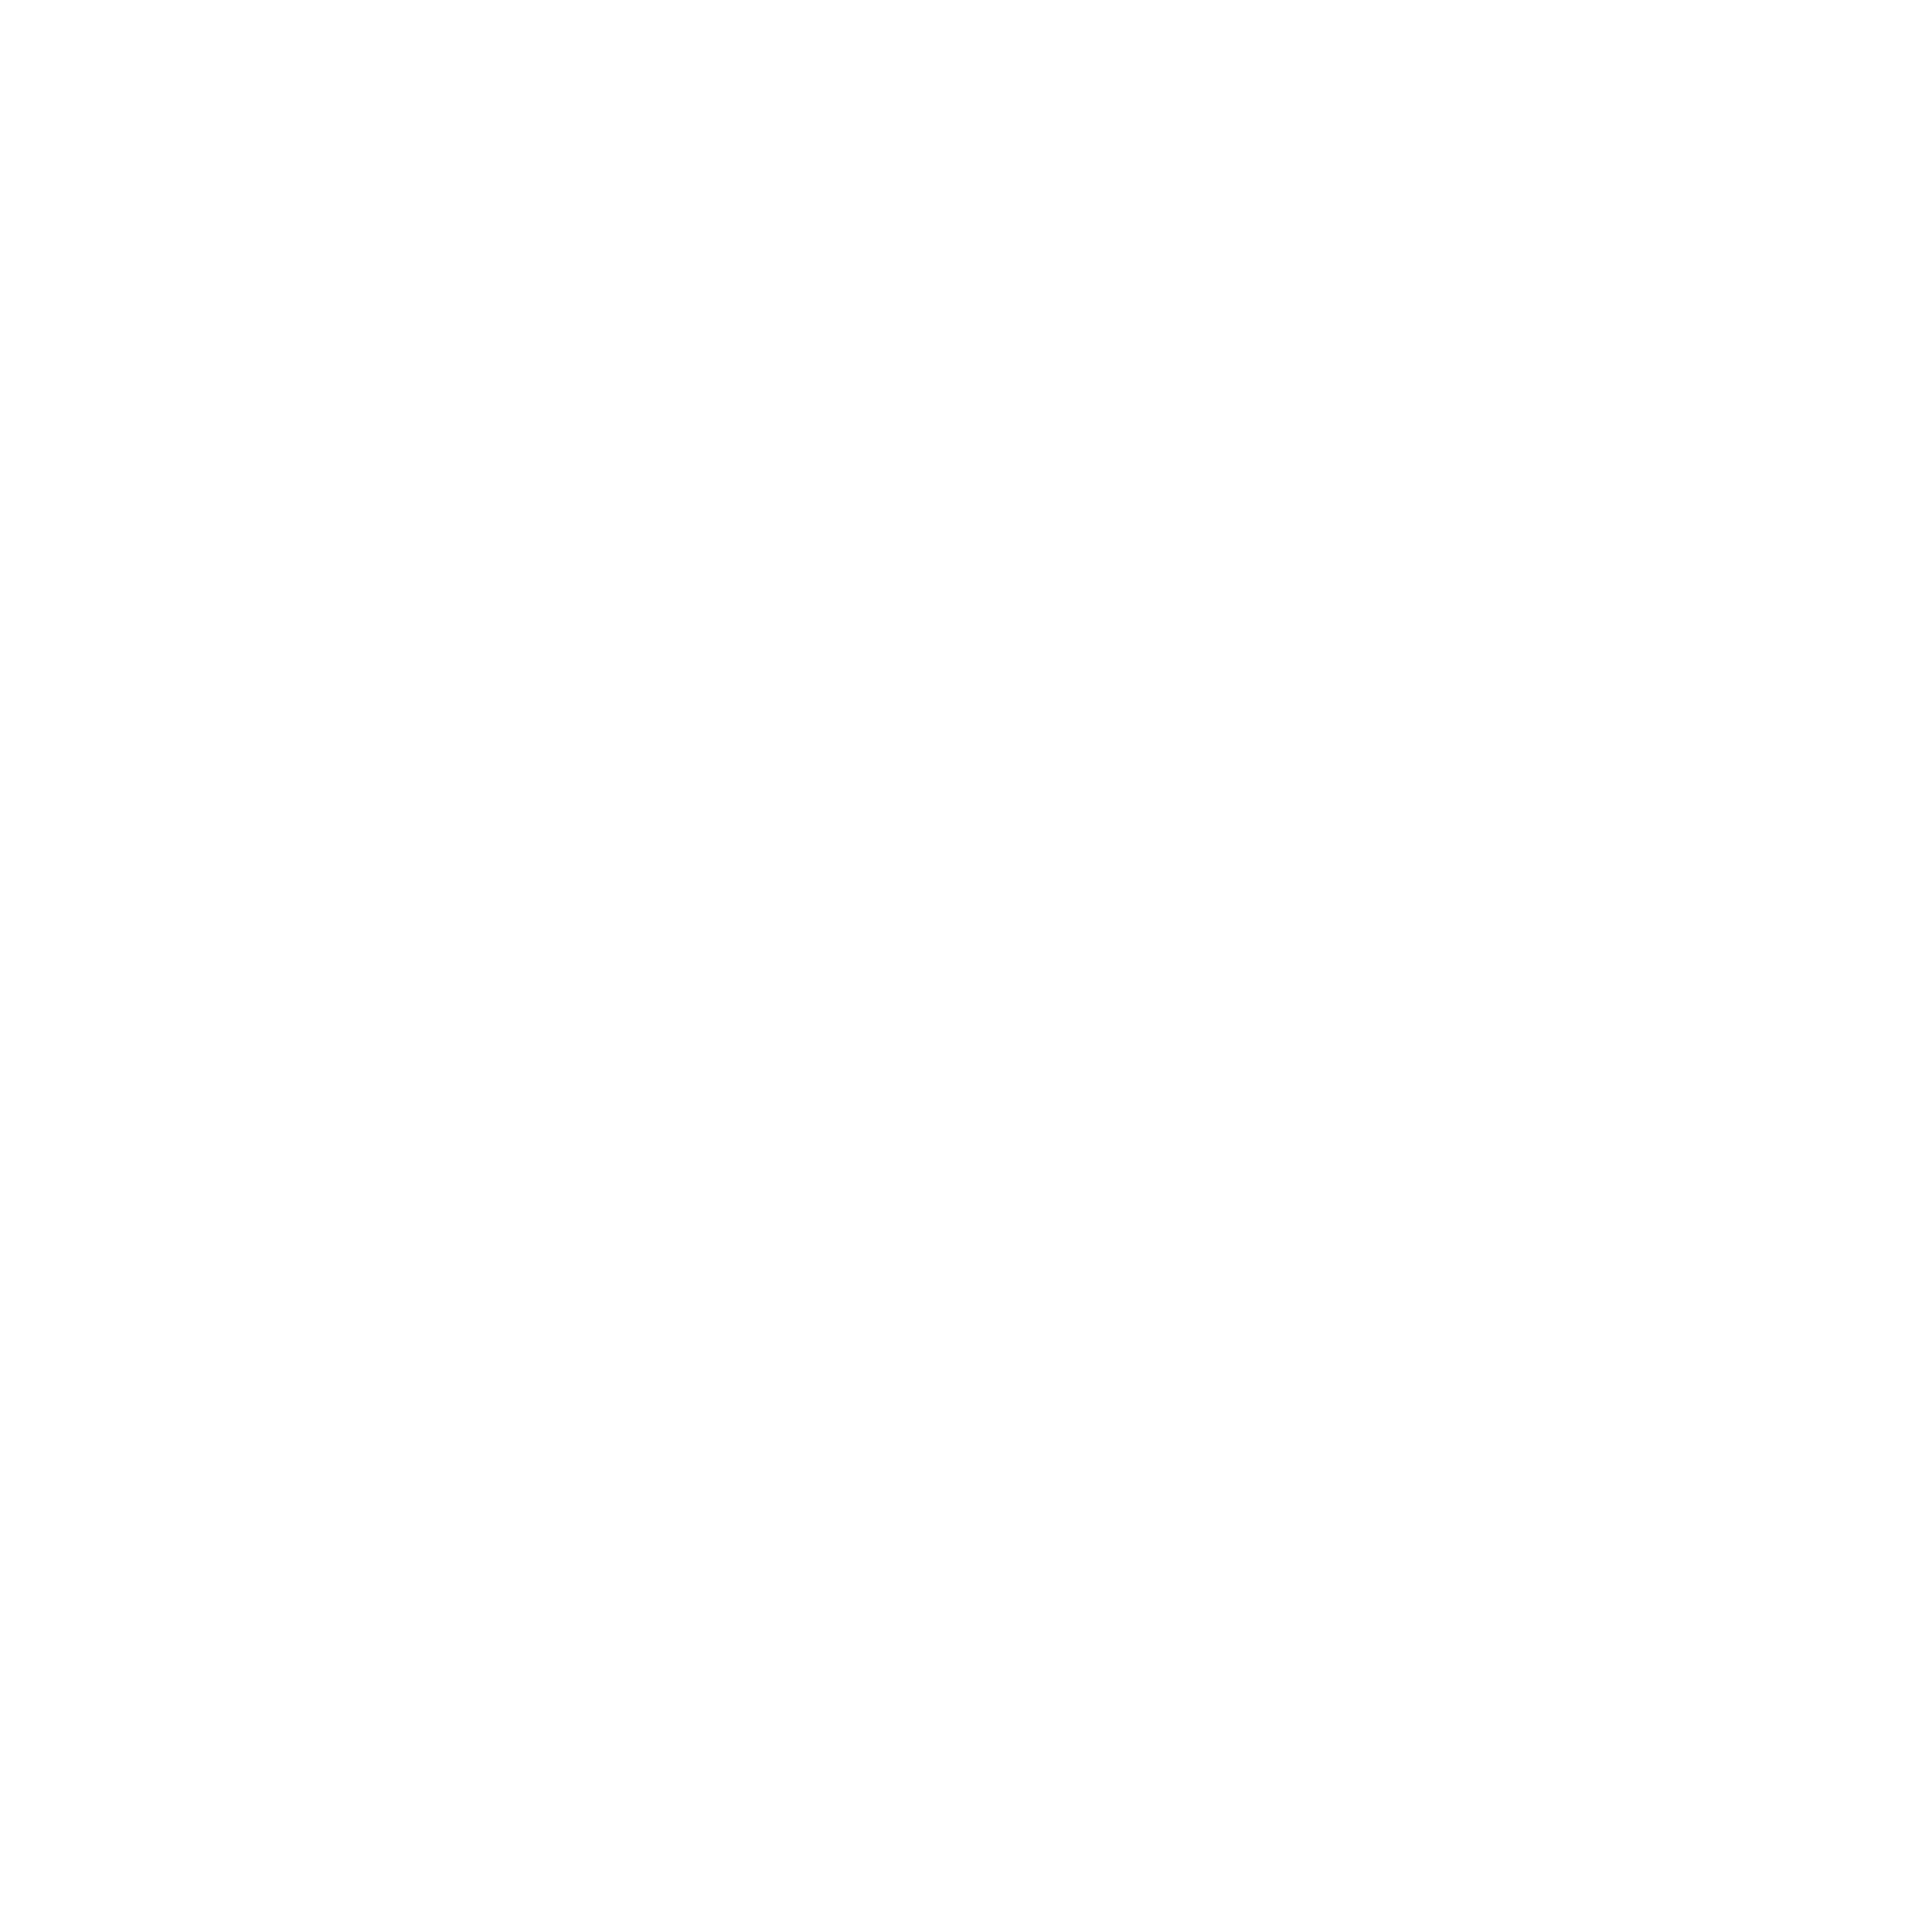

In [70]:
### Memorability changes by coordinates in each cluster
# normalized: highest R^2 (cluster 1) = 0.318
# mobius: highest R^2 (cluster 3) = 0.123

%matplotlib notebook

# plt.clf()
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')

ax.scatter(cluster_0[0], cluster_0[1], cluster_0[2], label='cluster_0', alpha=0.3)
# ax.plot(np.linspace(-30,-20,100), np.linspace(10,20,100), -2.5+-.5+np.linspace(-30,-20,100)*.0057+ np.linspace(10,20,100)*.0509+ np.linspace(-7.5, 2.5, 100)*.0108, label='cluster_0', alpha=1)
# ax.plot(np.linspace(-15,-5,100), np.linspace(5,15,100), -.3135+np.linspace(-15,-5,100)*.1324+ np.linspace(5,15,100)*.1098+ np.linspace(-5, 5, 100)*-.0734, label='cluster_0', alpha=1)
# ax.quiver(-30, 10, -7.5, 10, 10, 10, length = 10, normalize = True, color='blue')


# c0_grid = np.meshgrid(np.linspace(-20,-30,100), np.linspace(10,20,100))
# ax.plot_surface(c0_grid[0], c0_grid[1], -.5+X*.0057+ Y*.0509, label='cluster_0', alpha=1)

ax.scatter(cluster_1[0], cluster_1[1], cluster_1[2], label='cluster_1', alpha=0.3)
# ax.plot(np.linspace(-20,-10,100), np.linspace(10,20,100), .59+np.linspace(-20,-10,100)*.1288+ np.linspace(10,20,100)*.1266+ np.linspace(-5, 5, 100)*.0101, label='cluster_1', alpha=1)
# ax.plot(np.linspace(-20,-10,100), np.linspace(-2.5,7.5,100), -1.5349+np.linspace(-20,-10,100)*-.1115+ np.linspace(-2.5,7.5,100)*-.0823+ np.linspace(-5, 5, 100)*.0273, label='cluster_1', alpha=1)
# ax.quiver(-20, 10, -5, 10, 10, 10, length = 10, normalize = True, color='orange')


# c1_grid = np.meshgrid(np.linspace(-10,-20,100), np.linspace(10,20,100))
# ax.plot_surface(c1_grid[0], c1_grid[1], .59+X*.1288+ Y*.1266, label='cluster_1', alpha=1)

ax.scatter(cluster_2[0], cluster_2[1], cluster_2[2], label='cluster_2', alpha=0.3)
# ax.plot(np.linspace(-25,-15,100), np.linspace(0,10,100), -.49+np.linspace(-25,-15,100)*-.0665+ np.linspace(0,10,100)*-.1488+ np.linspace(-7.5, 2.5, 100)*-.0007, label='cluster_2', alpha=1)
# ax.plot(np.linspace(-15,-5,100), np.linspace(10,0,100), 1.6519+np.linspace(-15,-5,100)*.1747+ np.linspace(10,0,100)*-.0601+ np.linspace(0, 10, 100)*.0127, label='cluster_2', alpha=1)
# ax.quiver(-15, 0, 2.5, -10, 10, -10, length = 10, normalize = True, color='green')


# c2_grid = np.meshgrid(np.linspace(-25,-15,100), np.linspace(0,10,100))
# ax.plot_surface(c2_grid[0], c2_grid[1], -.49+X*-.0665+ Y*-.1488, label='cluster_2', alpha=1)

ax.scatter(cluster_3[0], cluster_3[1], cluster_3[2], label='cluster_3', alpha=0.3)
# ax.plot(np.linspace(-20,-10,100), np.linspace(5,15,100), -10+.47+np.linspace(-20,-10,100)*.1483+ np.linspace(5,15,100)*.1887+ np.linspace(-12.5, -7.5, 100)*.0244, label='cluster_3', alpha=1)
# ax.plot(np.linspace(-17.5,-7.5,100), np.linspace(10,0,100), 1.0544+np.linspace(-17.5,-7.5,100)*.1962+ np.linspace(10,0,100)*-.1758+ np.linspace(0, -10, 100)*.0596, label='cluster_3', alpha=1)
# ax.quiver(-20, 5, -12.5, 10, 10, 10, length = 10, normalize = True, color='red')


# c3_grid = np.meshgrid(np.linspace(-10,-20,100), np.linspace(5,15,100))
# ax.plot_surface(c3_grid[0], c3_grid[1], .47+X*.1483+ Y*.1887, label='cluster_3', alpha=1)

# ax.scatter(mean_feature_embed.T[0], mean_feature_embed.T[1], mean_feature_embed.T[2], color='purple', alpha=.3)

plt.legend()


On cluster level, typicality and cartesian coordinates of concepts explained 3% more variance in memorability than coordinates alone. 

In [71]:
r_squared = 1 - (sum((zscore_mem_0 - res_0.fittedvalues)**2) + sum((zscore_mem_1 - res_1.fittedvalues)**2) + sum((zscore_mem_2 - res_2.fittedvalues)**2) + sum((zscore_mem_3 - res_3.fittedvalues)**2)) / (sum((zscore_mem_0 - zscore_mem_0.mean())**2) + sum((zscore_mem_1 - zscore_mem_1.mean())**2) + sum((zscore_mem_2 - zscore_mem_2.mean())**2) + sum((zscore_mem_3 - zscore_mem_3.mean())**2))
results.iloc[0]['cluster_cart_typ_mem'].append(r_squared)
r_squared

0.1836525405109798

In [72]:
r_squared = 1 - (sum((zscore_mem_0 - res_pol_0.fittedvalues)**2) + sum((zscore_mem_1 - res_pol_1.fittedvalues)**2) + sum((zscore_mem_2 - res_pol_2.fittedvalues)**2) + sum((zscore_mem_3 - res_pol_3.fittedvalues)**2)) / (sum((zscore_mem_0 - zscore_mem_0.mean())**2) + sum((zscore_mem_1 - zscore_mem_1.mean())**2) + sum((zscore_mem_2 - zscore_mem_2.mean())**2) + sum((zscore_mem_3 - zscore_mem_3.mean())**2))
r_squared

0.17673968294922793

In [73]:
r_squared = 1 - (sum((zscore_mem_0 - res_r_0.fittedvalues)**2) + sum((zscore_mem_1 - res_r_1.fittedvalues)**2) + sum((zscore_mem_2 - res_r_2.fittedvalues)**2) + sum((zscore_mem_3 - res_r_3.fittedvalues)**2)) / (sum((zscore_mem_0 - zscore_mem_0.mean())**2) + sum((zscore_mem_1 - zscore_mem_1.mean())**2) + sum((zscore_mem_2 - zscore_mem_2.mean())**2) + sum((zscore_mem_3 - zscore_mem_3.mean())**2))
results.iloc[0]['cluster_radius_typ_mem'].append(r_squared)
r_squared

0.032343675826642215

In [74]:
r_squared = 1 - (sum((zscore_mem_0 - res_0_typ.fittedvalues)**2) + sum((zscore_mem_1 - res_1_typ.fittedvalues)**2) + sum((zscore_mem_2 - res_2_typ.fittedvalues)**2) + sum((zscore_mem_3 - res_3_typ.fittedvalues)**2)) / (sum((zscore_mem_0 - zscore_mem_0.mean())**2) + sum((zscore_mem_1 - zscore_mem_1.mean())**2) + sum((zscore_mem_2 - zscore_mem_2.mean())**2) + sum((zscore_mem_3 - zscore_mem_3.mean())**2))
results.iloc[0]['cluster_radius_typ_mem'].append(r_squared)
r_squared

-0.05499117732971026

In [75]:
# import statsmodels.api as sm
# import statsmodels.formula.api as smf
# from statsmodels.tools.sm_exceptions import ConvergenceWarning

# md = smf.mixedlm("cr ~ typicality", typ_coord_cluster, groups=typ_coord_cluster["label"], re_formula="~typicality")
# mdf = md.fit(method=["lbfgs"])
# print(mdf.summary())

In [76]:
### Cluster and typicality vs. memorability
# cluster number and typicality in predicting memorability: larger cluster number --> more memorable
zscore_mem = stats.zscore(typ_coord_cluster['cr'])
mean_concept_constant = sm.add_constant(np.array(typ_coord_cluster[['label', 'typicality']]), prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.055
Model:                            OLS   Adj. R-squared:                  0.054
Method:                 Least Squares   F-statistic:                     38.43
Date:                Thu, 03 Nov 2022   Prob (F-statistic):           5.99e-17
Time:                        14:02:00   Log-Likelihood:                -1841.2
No. Observations:                1324   AIC:                             3688.
Df Residuals:                    1321   BIC:                             3704.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.1925      0.034      5.667      0.0

## Categories

In [77]:
typ_coord_cluster

index          0          1         2        cr  bigcat  \
0         0  -8.362256   5.447828 -8.557188  0.779739       1   
1         1 -26.123590  12.240625  0.518939  0.798485      13   
2         2 -24.385152  14.180849  0.693800  0.752845      18   
3         4 -20.330699  11.947785 -4.992442  0.794466       9   
4         5 -24.493047  16.661652 -4.482670  0.806000      12   
...     ...        ...        ...       ...       ...     ...   
1319   1847 -18.208906   9.885611  3.776987  0.803129      24   
1320   1848 -19.281246   4.272460 -1.785376  0.765881      10   
1321   1850 -19.551059   2.813812 -2.150868  0.843158      10   
1322   1851 -14.748351   9.486465 -8.609210  0.800163       1   
1323   1853 -18.651758   5.749045 -4.932768  0.823237      10   

                cat_name  label  typicality  
0                 animal      3    0.810913  
1             home decor      0    0.247628  
2     musical instrument      0    0.624589  
3      electronic device      0    0.522380  
4              furniture      0    0.509185  
...                  ...    ...         ...  
1319                 toy      1    0.246697  
1320                food      2    0.786900  
1321                food      2    0.770485  
1322              animal      3    0.764335  
1323                food      2    0.705398  

[1324 rows x 9 columns]

<IPython.core.display.Javascript object>


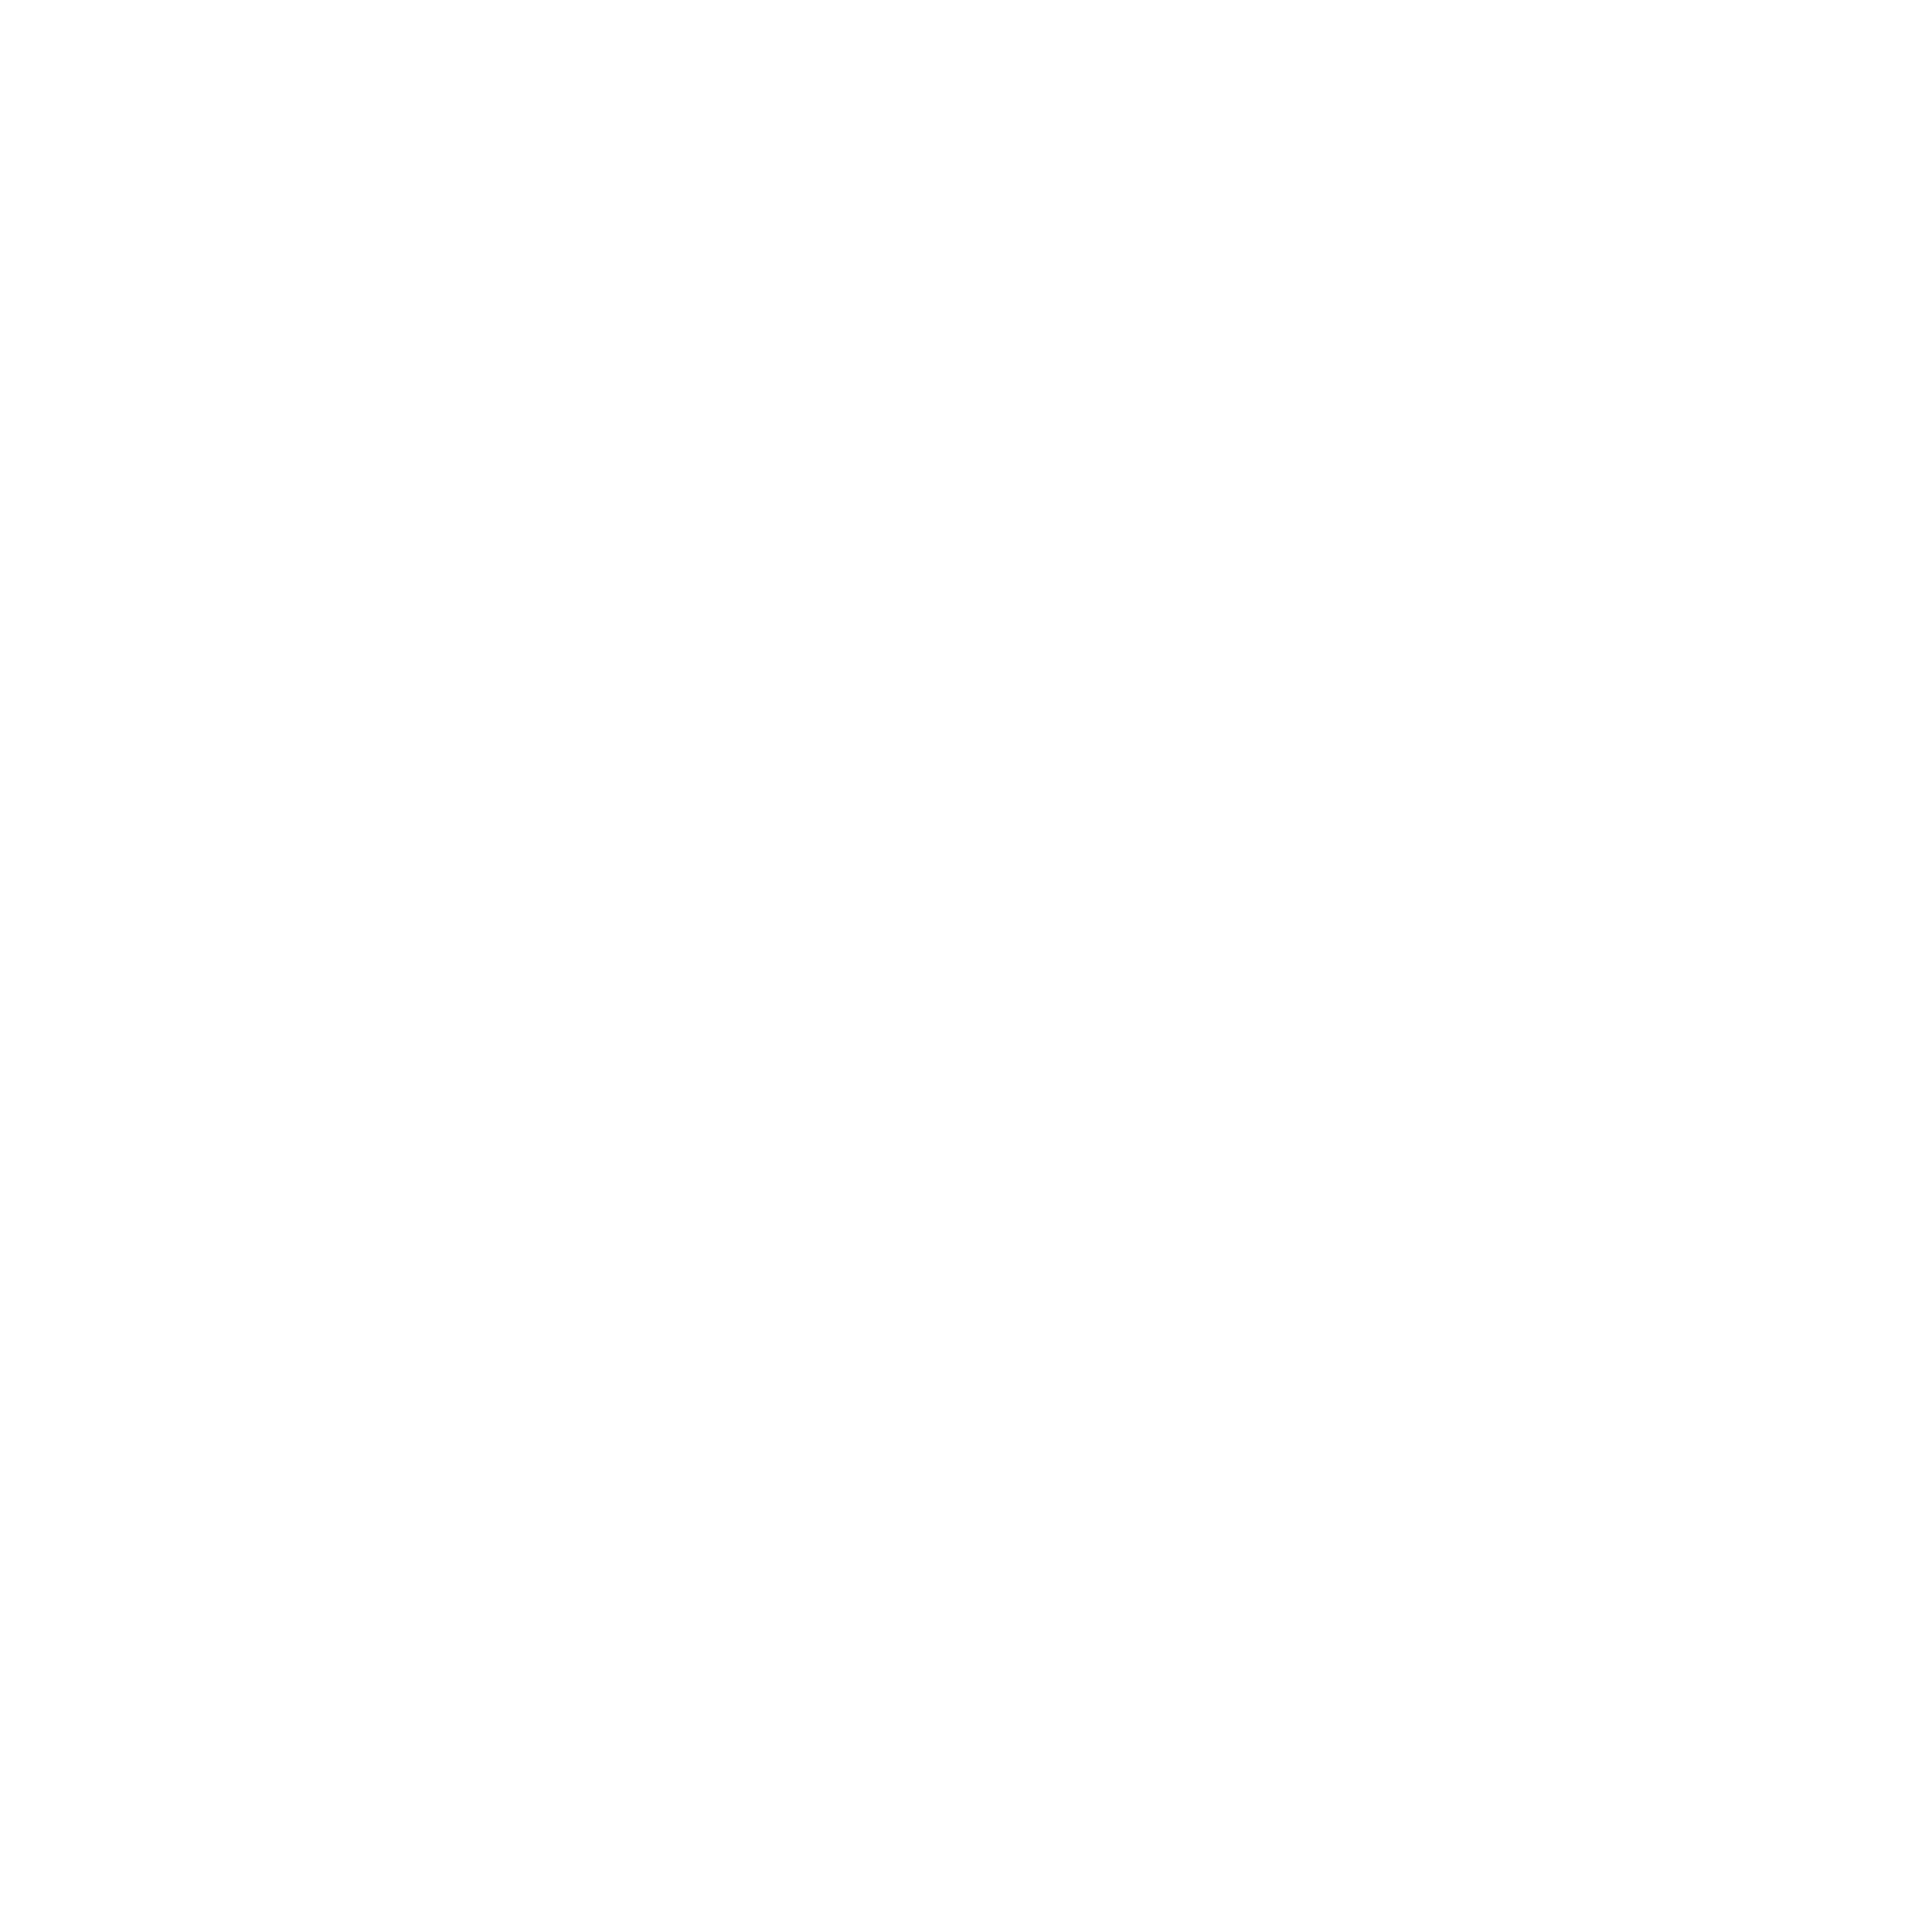

In [78]:
### color by categories: repeat color assignment
import matplotlib.colors as mcolors
%matplotlib notebook

colors = mcolors.CSS4_COLORS
by_hsv = sorted((tuple(mcolors.rgb_to_hsv(mcolors.to_rgb(color))), name)
                for name, color in colors.items())
color_names = [name for hsv, name in by_hsv]

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')

groups = mean_concept_in_feat_cat_na.groupby("cat_name")
i = 3
for name, group in groups:
    ax.scatter(group[0], group[1], group[2], label=name, alpha=0.7, color=color_names[i])
    i = i+6
plt.legend(bbox_to_anchor=(0.13,0.7))

# ax.scatter(mean_feature_embed.T[0], mean_feature_embed.T[1], mean_feature_embed.T[2], color='red')


In [79]:
concept_name = pd.read_csv('../data/memorability_score_by_concepts.csv')['concept_name']
mean_concept_in_feat_cat_na['concept_name'] = concept_name
mean_concept_in_feat_cat_na

/var/folders/z0/2nnq77gs127ftm6v0pqpy_3c0000gn/T/ipykernel_70324/2953235875.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mean_concept_in_feat_cat_na['concept_name'] = concept_name


index          0          1         2        cr  bigcat  \
0         0  -8.362256   5.447828 -8.557188  0.779739       1   
1         1 -26.123590  12.240625  0.518939  0.798485      13   
2         2 -24.385152  14.180849  0.693800  0.752845      18   
4         4 -20.330699  11.947785 -4.992442  0.794466       9   
5         5 -24.493047  16.661652 -4.482670  0.806000      12   
...     ...        ...        ...       ...       ...     ...   
1847   1847 -18.208906   9.885611  3.776987  0.803129      24   
1848   1848 -19.281246   4.272460 -1.785376  0.765881      10   
1850   1850 -19.551059   2.813812 -2.150868  0.843158      10   
1851   1851 -14.748351   9.486465 -8.609210  0.800163       1   
1853   1853 -18.651758   5.749045 -4.932768  0.823237      10   

                cat_name     concept_name  
0                 animal         aardvark  
1             home decor           abacus  
2     musical instrument        accordion  
4      electronic device  air_conditioner  
5              furniture     air_mattress  
...                  ...              ...  
1847                 toy            yo-yo  
1848                food           yogurt  
1850                food             yolk  
1851              animal            zebra  
1853                food         zucchini  

[1324 rows x 8 columns]

In [80]:
len(mean_concept_in_feat_cat_na["bigcat"].unique())

23

<IPython.core.display.Javascript object>


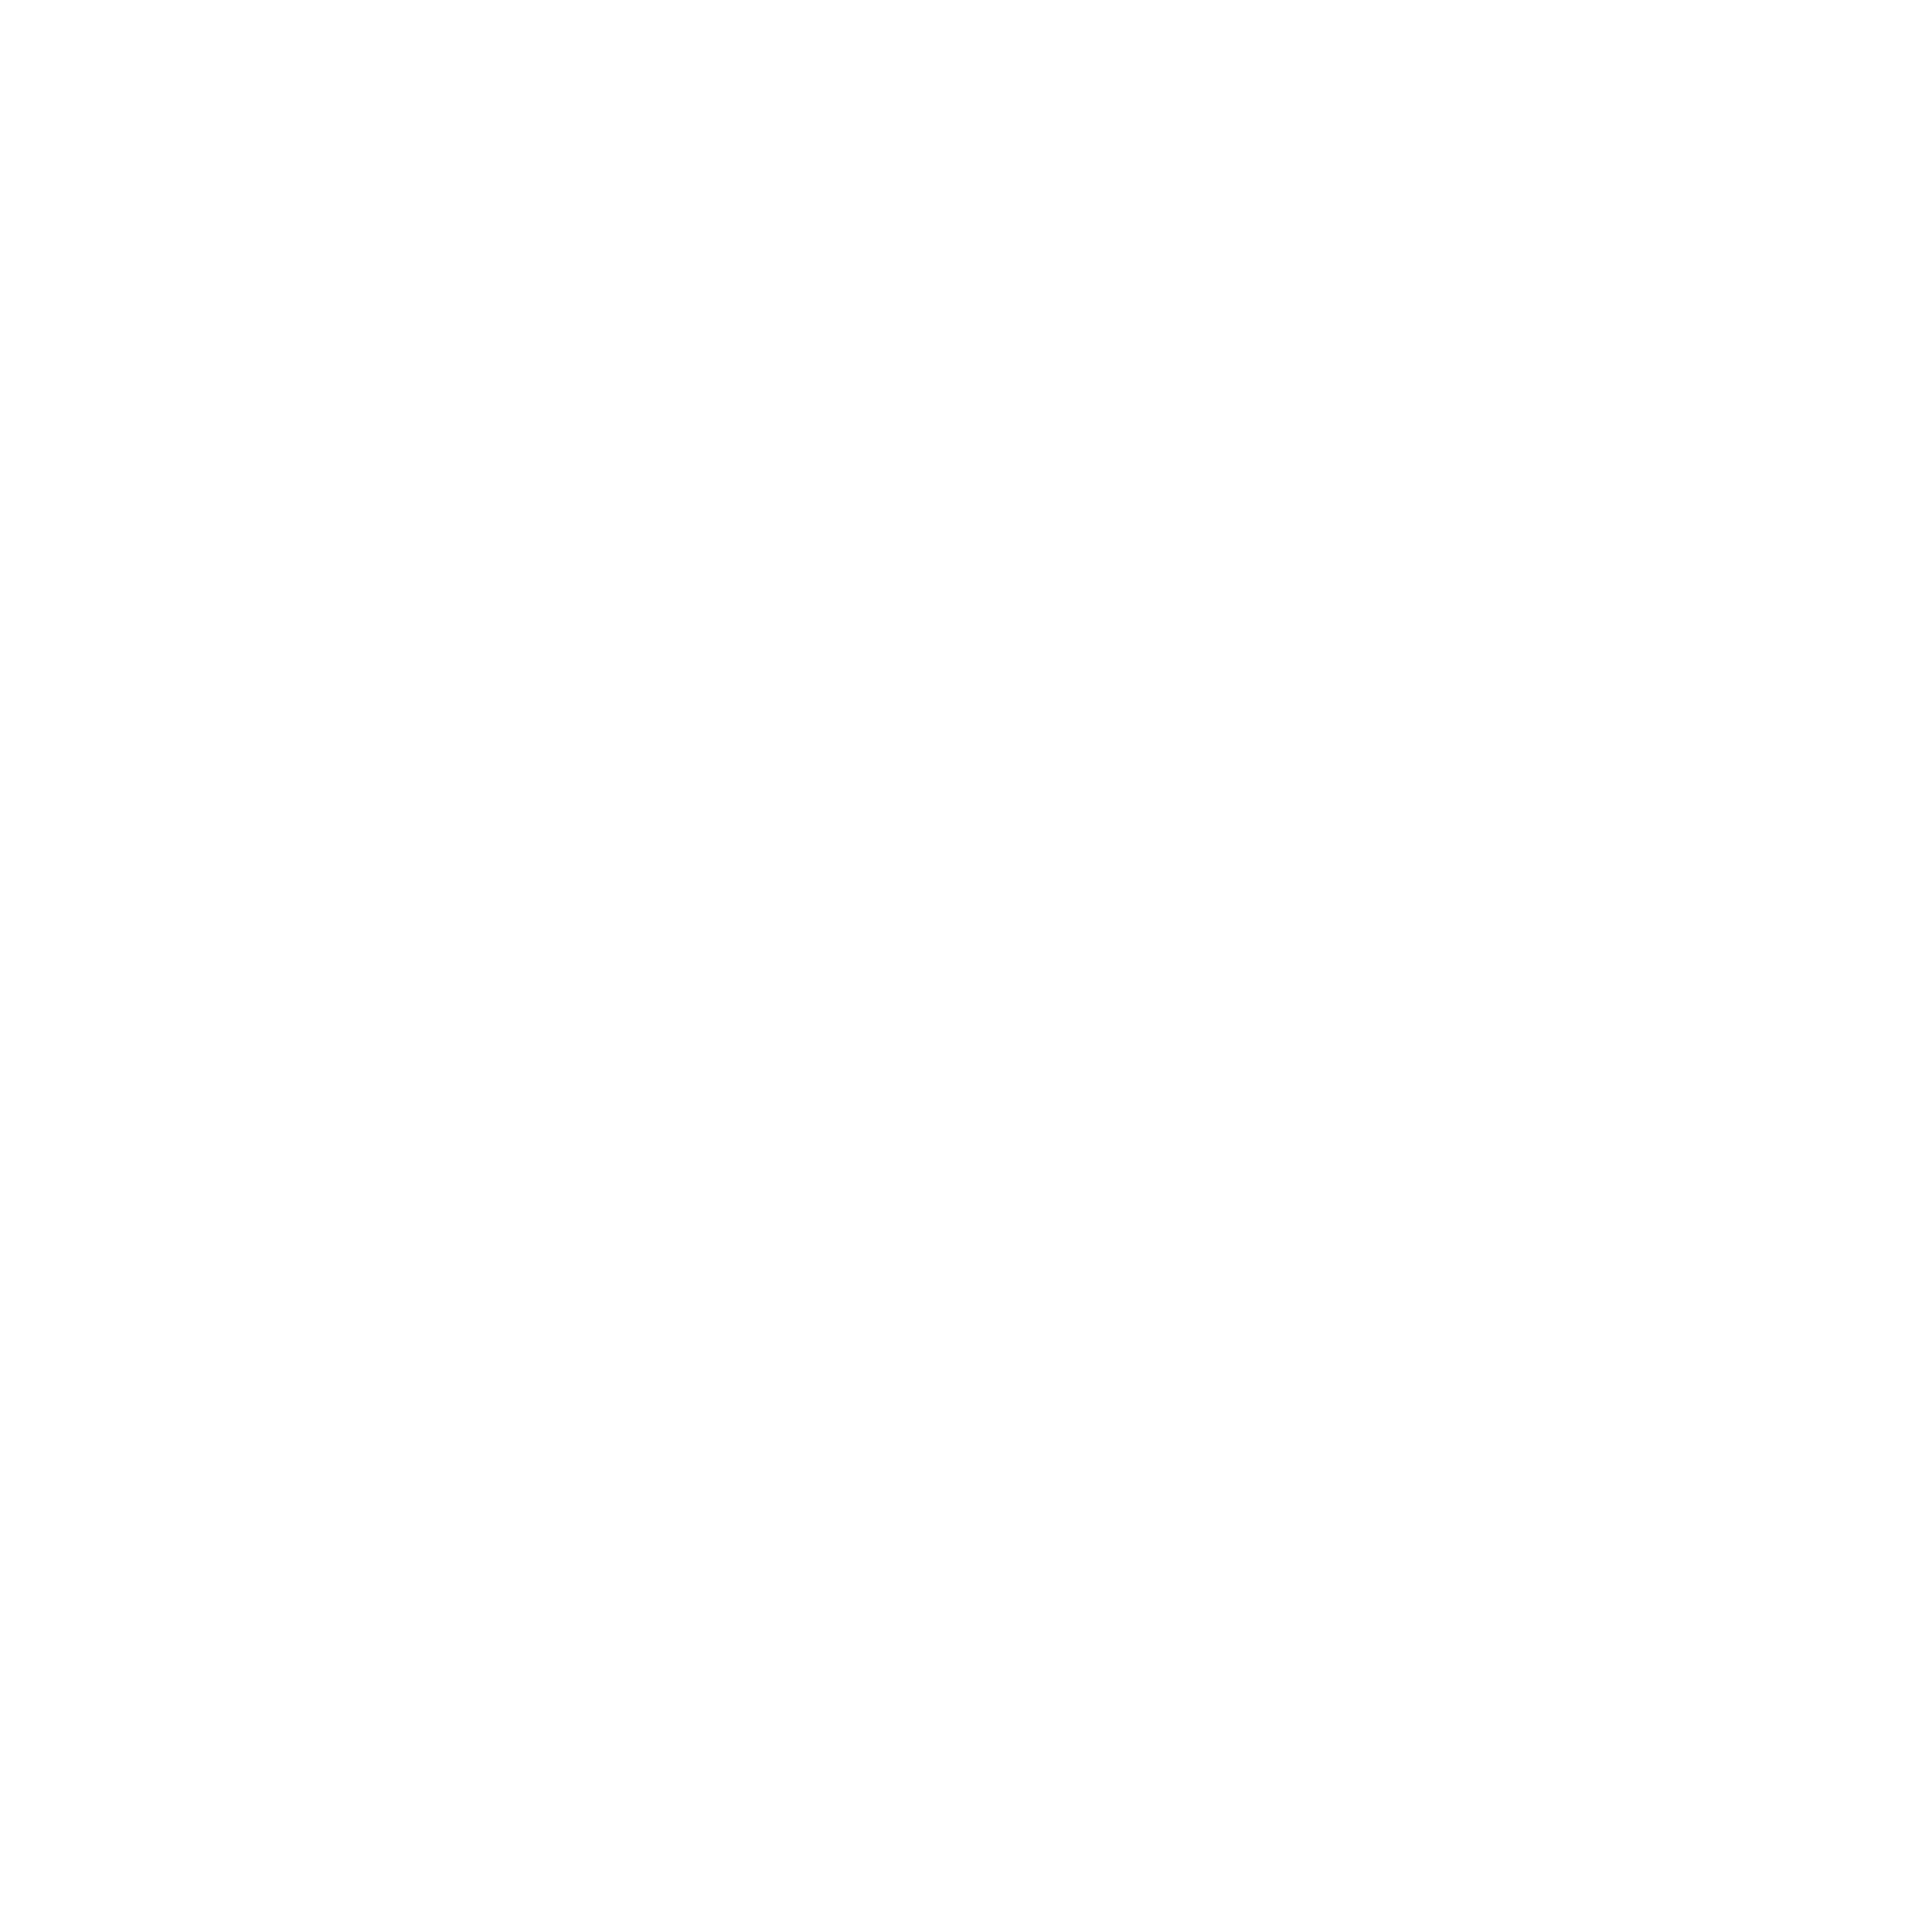

In [81]:
### color by categories: repeat color assignment
import matplotlib.colors as mcolors
%matplotlib notebook

colors = mcolors.CSS4_COLORS
by_hsv = sorted((tuple(mcolors.rgb_to_hsv(mcolors.to_rgb(color))), name)
                for name, color in colors.items())
color_names = [name for hsv, name in by_hsv]

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
example_list = ['pigeon']
#                 , 'fern', 'peach', 'tiramisu', 'toaster_oven', 'saw', 'saxophone', 'yacht', 'police_car', 'soccer_ball', 'arm', 'sweater']

# groups = mean_concept_in_feat_cat_na.groupby("cat_name")
groups = mean_concept_in_feat_cat_na[ (mean_concept_in_feat_cat_na['cat_name'] == 'toy') | (mean_concept_in_feat_cat_na['cat_name'] == 'vehicle')].groupby('cat_name')
i = 3
for name, group in groups:
    i = i+12
#     example = group[group['concept_name'].isin(example_list)]
#     if len(example) > 0:
    ax.scatter(group[0], group[1], group[2], label=name, alpha=0.7, color=color_names[i])
#     for x in range(len(example)): 
#         current = example.iloc[x]
#         ax.text(current[0]*1.1, current[1]*1.1, current[2]*1.1, current['concept_name'], size=15, zorder=1, color='k')
#             current[0]*1.3, current[1]*1.3, current[2]*1.7+1, current['concept_name'], size=12, zorder=1, color='k')
#         print(current[0]*1, current[1]*1, current[2]*1)
#         print(current[0]*1.05, current[1]*1.05, current[2]*1.05)
#         ax.quiver(current[0], current[1], current[2], current[0]*0.3, current[1]*0.3+1, current[2]*0.7,arrow_length_ratio=0.001)
#     example = None
    

# ax.quiver(-22.782824135191113, 13.313784741759008, -6.063981841081353, -23.92196534195067, 13.97947397884696, -6.367180933135421)
plt.legend(bbox_to_anchor=(0.13,0.7))

# ax.scatter(mean_feature_embed.T[0], mean_feature_embed.T[1], mean_feature_embed.T[2], color='red')


### Typicality by cluster 

In [82]:
color_names

['black',
 'dimgray',
 'dimgrey',
 'gray',
 'grey',
 'darkgray',
 'darkgrey',
 'silver',
 'lightgray',
 'lightgrey',
 'gainsboro',
 'whitesmoke',
 'white',
 'snow',
 'rosybrown',
 'lightcoral',
 'indianred',
 'brown',
 'firebrick',
 'maroon',
 'darkred',
 'red',
 'mistyrose',
 'salmon',
 'tomato',
 'darksalmon',
 'coral',
 'orangered',
 'lightsalmon',
 'sienna',
 'seashell',
 'chocolate',
 'saddlebrown',
 'sandybrown',
 'peachpuff',
 'peru',
 'linen',
 'bisque',
 'darkorange',
 'burlywood',
 'antiquewhite',
 'tan',
 'navajowhite',
 'blanchedalmond',
 'papayawhip',
 'moccasin',
 'orange',
 'wheat',
 'oldlace',
 'floralwhite',
 'darkgoldenrod',
 'goldenrod',
 'cornsilk',
 'gold',
 'lemonchiffon',
 'khaki',
 'palegoldenrod',
 'darkkhaki',
 'ivory',
 'beige',
 'lightyellow',
 'lightgoldenrodyellow',
 'olive',
 'yellow',
 'olivedrab',
 'yellowgreen',
 'darkolivegreen',
 'greenyellow',
 'chartreuse',
 'lawngreen',
 'honeydew',
 'darkseagreen',
 'palegreen',
 'lightgreen',
 'forestgreen',
 'l

In [83]:
clusters = typ_coord_cluster.groupby('label')
clusters = clusters.apply(calculate_typicality)
clusters

index          0          1         2        cr  bigcat  \
0         0  -8.362256   5.447828 -8.557188  0.779739       1   
1         1 -26.123590  12.240625  0.518939  0.798485      13   
2         2 -24.385152  14.180849  0.693800  0.752845      18   
3         4 -20.330699  11.947785 -4.992442  0.794466       9   
4         5 -24.493047  16.661652 -4.482670  0.806000      12   
...     ...        ...        ...       ...       ...     ...   
1319   1847 -18.208906   9.885611  3.776987  0.803129      24   
1320   1848 -19.281246   4.272460 -1.785376  0.765881      10   
1321   1850 -19.551059   2.813812 -2.150868  0.843158      10   
1322   1851 -14.748351   9.486465 -8.609210  0.800163       1   
1323   1853 -18.651758   5.749045 -4.932768  0.823237      10   

                cat_name  label  typicality  
0                 animal      3    0.825943  
1             home decor      0    0.159616  
2     musical instrument      0    0.094532  
3      electronic device      0    0.158309  
4              furniture      0    0.186518  
...                  ...    ...         ...  
1319                 toy      1    0.100659  
1320                food      2    0.684158  
1321                food      2    0.652066  
1322              animal      3    0.778959  
1323                food      2    0.561689  

[1324 rows x 9 columns]

In [84]:
### overall cartesian coordinates vs. typicality
zscore_mem = stats.zscore(clusters['typicality'])
mean_concept_constant = sm.add_constant(clusters[[0,1,2]], prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())
results['cart_clust_typ'] = [res.rsquared, res.rsquared_adj, np.array(res.params), np.array(res.pvalues), res.aic, res.bic, res.fvalue, res.f_pvalue, res.llf]

                            OLS Regression Results                            
Dep. Variable:             typicality   R-squared:                       0.671
Model:                            OLS   Adj. R-squared:                  0.670
Method:                 Least Squares   F-statistic:                     897.6
Date:                Thu, 03 Nov 2022   Prob (F-statistic):          4.84e-318
Time:                        14:02:00   Log-Likelihood:                -1142.6
No. Observations:                1324   AIC:                             2293.
Df Residuals:                    1320   BIC:                             2314.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.0899      0.004     22.060      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [85]:
### overall cartesian coordinates and typicality vs. memorability
zscore_mem = stats.zscore(clusters['cr'])
mean_concept_constant = sm.add_constant(clusters[[0,1,2, 'typicality']], prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())

results['cart_clust_typ_mem'] = [res.rsquared, res.rsquared_adj, np.array(res.params), np.array(res.pvalues), res.aic, res.bic, res.fvalue, res.f_pvalue, res.llf]

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.123
Model:                            OLS   Adj. R-squared:                  0.120
Method:                 Least Squares   F-statistic:                     46.24
Date:                Thu, 03 Nov 2022   Prob (F-statistic):           2.12e-36
Time:                        14:02:00   Log-Likelihood:                -1791.8
No. Observations:                1324   AIC:                             3594.
Df Residuals:                    1319   BIC:                             3620.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.0602      0.008      7.736      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [86]:
### overall polar coordinates vs. typicality
zscore_mem = stats.zscore(clusters['typicality'])
mean_concept_constant = sm.add_constant(np.array([r, theta, rho]).T, prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:             typicality   R-squared:                       0.673
Model:                            OLS   Adj. R-squared:                  0.672
Method:                 Least Squares   F-statistic:                     905.7
Date:                Thu, 03 Nov 2022   Prob (F-statistic):          8.91e-320
Time:                        14:02:00   Log-Likelihood:                -1138.6
No. Observations:                1324   AIC:                             2285.
Df Residuals:                    1320   BIC:                             2306.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.1221      0.004    -29.853      0.0

In [87]:
### overall polar coordinates and typicality vs. memorability
zscore_mem = stats.zscore(clusters['cr'])
mean_concept_constant = sm.add_constant(np.array([r, theta, rho, clusters['typicality']]).T, prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.109
Model:                            OLS   Adj. R-squared:                  0.106
Method:                 Least Squares   F-statistic:                     40.27
Date:                Thu, 03 Nov 2022   Prob (F-statistic):           7.29e-32
Time:                        14:02:00   Log-Likelihood:                -1802.4
No. Observations:                1324   AIC:                             3615.
Df Residuals:                    1319   BIC:                             3641.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0235      0.009     -2.685      0.0

In [88]:
### overall radius vs. typicality
concept_radius_clus = np.sqrt((clusters[[0,1,2]]**2).sum(1))
zscore_mem = stats.zscore(clusters['typicality'])
mean_concept_constant = sm.add_constant(np.array([concept_radius_clus]).T, prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())
results['radius_clust_typ'] = [res.rsquared, res.rsquared_adj, np.array(res.params), np.array(res.pvalues), res.aic, res.bic, res.fvalue, res.f_pvalue, res.llf]

                            OLS Regression Results                            
Dep. Variable:             typicality   R-squared:                       0.469
Model:                            OLS   Adj. R-squared:                  0.469
Method:                 Least Squares   F-statistic:                     1168.
Date:                Thu, 03 Nov 2022   Prob (F-statistic):          5.25e-184
Time:                        14:02:00   Log-Likelihood:                -1459.5
No. Observations:                1324   AIC:                             2923.
Df Residuals:                    1322   BIC:                             2933.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.1643      0.005    -34.180      0.0

In [89]:
### overall radius and typicality vs. memorability
concept_radius_clus = np.sqrt((clusters[[0,1,2]]**2).sum(1))
zscore_mem = stats.zscore(clusters['cr'])
mean_concept_constant = sm.add_constant(np.array([concept_radius_clus, clusters['typicality']]).T, prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())
results['radius_clust_typ_mem'] = [res.rsquared, res.rsquared_adj, np.array(res.params), np.array(res.pvalues), res.aic, res.bic, res.fvalue, res.f_pvalue, res.llf]

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.050
Model:                            OLS   Adj. R-squared:                  0.048
Method:                 Least Squares   F-statistic:                     34.71
Date:                Thu, 03 Nov 2022   Prob (F-statistic):           2.04e-15
Time:                        14:02:00   Log-Likelihood:                -1844.8
No. Observations:                1324   AIC:                             3696.
Df Residuals:                    1321   BIC:                             3711.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0279      0.009     -3.164      0.0

In [90]:
### cluster 0: cartesian coordinates vs. memorability
cluster_0 = clusters[clusters['label'] == 0]
zscore_mem_0 = stats.zscore(cluster_0['cr'])
mean_concept_constant = sm.add_constant(cluster_0[[0,1,2, 'typicality']], prepend=False)
mod_0 = sm.OLS(zscore_mem_0, mean_concept_constant)

res_0 = mod_0.fit()
print(res_0.summary())
results['cluster_cart_clust_typ_mem'] = [[res_0.rsquared], [res_0.rsquared_adj], [np.array(res_0.params)], [np.array(res_0.pvalues)], [res_0.aic], [res_0.bic], [res_0.fvalue], [res_0.f_pvalue], [res_0.llf]]


                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.105
Model:                            OLS   Adj. R-squared:                  0.095
Method:                 Least Squares   F-statistic:                     10.34
Date:                Thu, 03 Nov 2022   Prob (F-statistic):           6.31e-08
Time:                        14:02:00   Log-Likelihood:                -486.73
No. Observations:                 357   AIC:                             983.5
Df Residuals:                     352   BIC:                             1003.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.0476      0.023      2.030      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [91]:
### cluster 0: polar coordinates + typicality vs. memorability
polar_cluster_0 = cluster_0.copy()
polar_cluster_0[[0,1,2]] = cart_to_polar(cluster_0[[0,1,2]].values) - cart_to_polar(clusters[[0,1,2]].values).mean(0)
zscore_mem = stats.zscore(cluster_0['cr'])
mean_concept_constant = sm.add_constant(polar_cluster_0[[0,1,2,'typicality']], prepend=False)
mod_pol_0 = sm.OLS(zscore_mem, mean_concept_constant)

res_pol_0 = mod_pol_0.fit()
print(res_pol_0.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.102
Model:                            OLS   Adj. R-squared:                  0.092
Method:                 Least Squares   F-statistic:                     9.986
Date:                Thu, 03 Nov 2022   Prob (F-statistic):           1.15e-07
Time:                        14:02:00   Log-Likelihood:                -487.38
No. Observations:                 357   AIC:                             984.8
Df Residuals:                     352   BIC:                             1004.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.0260      0.022     -1.173      0.2

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [92]:
### cluster 0: radius and typicality vs. memorability
polar_cluster_0 = clusters[clusters['label'] == 0]
radius_cluster_0 = pd.concat([np.sqrt((polar_cluster_0.loc[:, 0:2]**2).sum(1)), polar_cluster_0['typicality']], axis=1)
zscore_mem_0 = stats.zscore(polar_cluster_0['cr'])
mean_concept_constant = sm.add_constant(radius_cluster_0[[0, 'typicality']], prepend=False)
mod_r_0 = sm.OLS(zscore_mem_0, mean_concept_constant)

res_r_0 = mod_r_0.fit()
print(res_r_0.summary())
results['cluster_radius_clust_typ_mem'] = [[res_r_0.rsquared], [res_r_0.rsquared_adj], [np.array(res_r_0.params)], [np.array(res_r_0.pvalues)], [res_r_0.aic], [res_r_0.bic], [res_r_0.fvalue], [res_r_0.f_pvalue], [res_r_0.llf]]


                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.062
Model:                            OLS   Adj. R-squared:                  0.056
Method:                 Least Squares   F-statistic:                     11.63
Date:                Thu, 03 Nov 2022   Prob (F-statistic):           1.28e-05
Time:                        14:02:00   Log-Likelihood:                -495.20
No. Observations:                 357   AIC:                             996.4
Df Residuals:                     354   BIC:                             1008.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.0052      0.022     -0.239      0.8

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [93]:
### cluster 1: cartesian coordinates vs. memorability
cluster_1 = clusters[clusters['label'] == 1]
zscore_mem_1 = stats.zscore(cluster_1['cr'])
mean_concept_constant = sm.add_constant(cluster_1[[0,1,2, 'typicality']], prepend=False)
mod_1 = sm.OLS(zscore_mem_1, mean_concept_constant)

res_1 = mod_1.fit()
print(res_1.summary())

row = 0
for stat in [res_1.rsquared, res_1.rsquared_adj, np.array(res_1.params), np.array(res_1.pvalues), res_1.aic, res_1.bic, res_1.fvalue, res_1.f_pvalue, res_1.llf]:
    results.iloc[row]['cluster_cart_clust_typ_mem'].append(stat)
    row += 1

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.354
Model:                            OLS   Adj. R-squared:                  0.348
Method:                 Least Squares   F-statistic:                     59.76
Date:                Thu, 03 Nov 2022   Prob (F-statistic):           3.24e-40
Time:                        14:02:00   Log-Likelihood:                -529.37
No. Observations:                 441   AIC:                             1069.
Df Residuals:                     436   BIC:                             1089.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.1386      0.015      9.484      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [94]:
### cluster 1: polar coordinates + typicality vs. memorability
polar_cluster_1 = cluster_1.copy()
polar_cluster_1[[0,1,2]] = cart_to_polar(cluster_1[[0,1,2]].values) - cart_to_polar(clusters[[0,1,2]].values).mean(0)
zscore_mem = stats.zscore(cluster_1['cr'])
mean_concept_constant = sm.add_constant(polar_cluster_1[[0,1,2,'typicality']], prepend=False)
mod_pol_1 = sm.OLS(zscore_mem, mean_concept_constant)

res_pol_1 = mod_pol_1.fit()
print(res_pol_1.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.348
Model:                            OLS   Adj. R-squared:                  0.342
Method:                 Least Squares   F-statistic:                     58.29
Date:                Thu, 03 Nov 2022   Prob (F-statistic):           2.14e-39
Time:                        14:02:00   Log-Likelihood:                -531.30
No. Observations:                 441   AIC:                             1073.
Df Residuals:                     436   BIC:                             1093.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.0112      0.015     -0.767      0.4

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [95]:
### cluster 1: radius and typicality vs. memorability
polar_cluster_1 = clusters[clusters['label'] == 1]
radius_cluster_1 = pd.concat([np.sqrt((polar_cluster_1.loc[:, 0:2]**2).sum(1)), polar_cluster_1['typicality']], axis=1)
zscore_mem_1 = stats.zscore(polar_cluster_1['cr'])
mean_concept_constant = sm.add_constant(radius_cluster_1[[0, 'typicality']], prepend=False)
mod_r_1 = sm.OLS(zscore_mem_1, mean_concept_constant)

res_r_1 = mod_r_1.fit()
print(res_r_1.summary())

row = 0
for stat in [res_r_1.rsquared, res_r_1.rsquared_adj, np.array(res_r_1.params), np.array(res_r_1.pvalues), res_r_1.aic, res_r_1.bic, res_r_1.fvalue, res_r_1.f_pvalue, res_r_1.llf]:
    results.iloc[row]['cluster_radius_clust_typ_mem'].append(stat)
    row += 1

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     5.260
Date:                Thu, 03 Nov 2022   Prob (F-statistic):            0.00553
Time:                        14:02:00   Log-Likelihood:                -620.52
No. Observations:                 441   AIC:                             1247.
Df Residuals:                     438   BIC:                             1259.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.0094      0.018      0.535      0.5

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [96]:
### cluster 2: cartesian coordinates vs. memorability
cluster_2 = clusters[clusters['label'] == 2]
zscore_mem_2 = stats.zscore(cluster_2['cr'])
mean_concept_constant = sm.add_constant(cluster_2[[0,1,2, 'typicality']], prepend=False)
mod_2 = sm.OLS(zscore_mem_2, mean_concept_constant)

res_2 = mod_2.fit()
print(res_2.summary())

row = 0
for stat in [res_2.rsquared, res_2.rsquared_adj, np.array(res_2.params), np.array(res_2.pvalues), res_2.aic, res_2.bic, res_2.fvalue, res_2.f_pvalue, res_2.llf]:
    results.iloc[row]['cluster_cart_clust_typ_mem'].append(stat)
    row += 1

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.182
Model:                            OLS   Adj. R-squared:                  0.173
Method:                 Least Squares   F-statistic:                     19.83
Date:                Thu, 03 Nov 2022   Prob (F-statistic):           9.36e-15
Time:                        14:02:00   Log-Likelihood:                -477.34
No. Observations:                 362   AIC:                             964.7
Df Residuals:                     357   BIC:                             984.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.0208      0.032     -0.647      0.5

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [97]:
### cluster 2: polar coordinates + typicality vs. memorability
polar_cluster_2 = cluster_2.copy()
polar_cluster_2[[0,1,2]] = cart_to_polar(cluster_2[[0,1,2]].values) - cart_to_polar(clusters[[0,1,2]].values).mean(0)
zscore_mem = stats.zscore(cluster_2['cr'])
mean_concept_constant = sm.add_constant(polar_cluster_2[[0,1,2,'typicality']], prepend=False)
mod_pol_2 = sm.OLS(zscore_mem, mean_concept_constant)

res_pol_2 = mod_pol_2.fit()
print(res_pol_2.summary())

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.182
Model:                            OLS   Adj. R-squared:                  0.173
Method:                 Least Squares   F-statistic:                     19.82
Date:                Thu, 03 Nov 2022   Prob (F-statistic):           9.47e-15
Time:                        14:02:00   Log-Likelihood:                -477.35
No. Observations:                 362   AIC:                             964.7
Df Residuals:                     357   BIC:                             984.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.0125      0.024      0.524      0.6

In [98]:
### cluster 2: radius and typicality vs. memorability
polar_cluster_2 = clusters[clusters['label'] == 2]
radius_cluster_2 = pd.concat([np.sqrt((polar_cluster_2.loc[:, 0:2]**2).sum(1)), polar_cluster_2['typicality']], axis=1)
zscore_mem_2 = stats.zscore(polar_cluster_2['cr'])
mean_concept_constant = sm.add_constant(radius_cluster_2[[0, 'typicality']], prepend=False)
mod_r_2 = sm.OLS(zscore_mem_2, mean_concept_constant)

res_r_2 = mod_r_2.fit()
print(res_r_2.summary())

row = 0
for stat in [res_r_2.rsquared, res_r_2.rsquared_adj, np.array(res_r_2.params), np.array(res_r_2.pvalues), res_r_2.aic, res_r_2.bic, res_r_2.fvalue, res_r_2.f_pvalue, res_r_2.llf]:
    results.iloc[row]['cluster_radius_clust_typ_mem'].append(stat)
    row += 1

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.166
Model:                            OLS   Adj. R-squared:                  0.161
Method:                 Least Squares   F-statistic:                     35.66
Date:                Thu, 03 Nov 2022   Prob (F-statistic):           7.46e-15
Time:                        14:02:00   Log-Likelihood:                -480.86
No. Observations:                 362   AIC:                             967.7
Df Residuals:                     359   BIC:                             979.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.0050      0.019      0.268      0.7

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [99]:
### cluster 3: cartesian coordinates vs. memorability
cluster_3 = clusters[clusters['label'] == 3]
zscore_mem_3 = stats.zscore(cluster_3['cr'])
mean_concept_constant = sm.add_constant(cluster_3[[0,1,2, 'typicality']], prepend=False)
mod_3 = sm.OLS(zscore_mem_3, mean_concept_constant)

res_3 = mod_3.fit()
print(res_3.summary())

row = 0
for stat in [res_3.rsquared, res_3.rsquared_adj, np.array(res_3.params), np.array(res_3.pvalues), res_3.aic, res_3.bic, res_3.fvalue, res_3.f_pvalue, res_3.llf]:
    results.iloc[row]['cluster_cart_clust_typ_mem'].append(stat)
    row += 1

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.171
Model:                            OLS   Adj. R-squared:                  0.150
Method:                 Least Squares   F-statistic:                     8.215
Date:                Thu, 03 Nov 2022   Prob (F-statistic):           4.77e-06
Time:                        14:02:00   Log-Likelihood:                -217.30
No. Observations:                 164   AIC:                             444.6
Df Residuals:                     159   BIC:                             460.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.1886      0.040      4.771      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [100]:
### cluster 3: polar coordinates + typicality vs. memorability
polar_cluster_3 = cluster_3.copy()
polar_cluster_3[[0,1,2]] = cart_to_polar(cluster_3[[0,1,2]].values) - cart_to_polar(clusters[[0,1,2]].values).mean(0)
zscore_mem = stats.zscore(cluster_3['cr'])
mean_concept_constant = sm.add_constant(polar_cluster_3[[0,1,2,'typicality']], prepend=False)
mod_pol_3 = sm.OLS(zscore_mem, mean_concept_constant)

res_pol_3 = mod_pol_3.fit()
print(res_pol_3.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.164
Model:                            OLS   Adj. R-squared:                  0.143
Method:                 Least Squares   F-statistic:                     7.777
Date:                Thu, 03 Nov 2022   Prob (F-statistic):           9.48e-06
Time:                        14:02:00   Log-Likelihood:                -218.05
No. Observations:                 164   AIC:                             446.1
Df Residuals:                     159   BIC:                             461.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.0272      0.030     -0.913      0.3

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [101]:
### cluster 3: radius and typicality vs. memorability
polar_cluster_3 = clusters[clusters['label'] == 3]
radius_cluster_3 = pd.concat([np.sqrt((polar_cluster_3.loc[:, 0:2]**2).sum(1)), polar_cluster_3['typicality']], axis=1)
zscore_mem_3 = stats.zscore(polar_cluster_3['cr'])
mean_concept_constant = sm.add_constant(radius_cluster_3[[0, 'typicality']], prepend=False)
mod_r_3 = sm.OLS(zscore_mem_3, mean_concept_constant)

res_r_3 = mod_r_3.fit()
print(res_r_3.summary())

row = 0
for stat in [res_r_3.rsquared, res_r_3.rsquared_adj, np.array(res_r_3.params), np.array(res_r_3.pvalues), res_r_3.aic, res_r_3.bic, res_r_3.fvalue, res_r_3.f_pvalue, res_r_3.llf]:
    results.iloc[row]['cluster_radius_clust_typ_mem'].append(stat)
    row += 1

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.078
Model:                            OLS   Adj. R-squared:                  0.066
Method:                 Least Squares   F-statistic:                     6.774
Date:                Thu, 03 Nov 2022   Prob (F-statistic):            0.00150
Time:                        14:02:00   Log-Likelihood:                -226.08
No. Observations:                 164   AIC:                             458.2
Df Residuals:                     161   BIC:                             467.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.0831      0.024     -3.395      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [102]:
r_squared = 1 - (sum((zscore_mem_0 - res_0.fittedvalues)**2) + sum((zscore_mem_1 - res_1.fittedvalues)**2) + sum((zscore_mem_2 - res_2.fittedvalues)**2) + sum((zscore_mem_3 - res_3.fittedvalues)**2)) / (sum((zscore_mem_0 - zscore_mem_0.mean())**2) + sum((zscore_mem_1 - zscore_mem_1.mean())**2) + sum((zscore_mem_2 - zscore_mem_2.mean())**2) + sum((zscore_mem_3 - zscore_mem_3.mean())**2))
results.iloc[0]['cluster_cart_clust_typ_mem'].append(r_squared)
r_squared

0.2172039470704954

In [103]:
r_squared = 1 - (sum((zscore_mem_0 - res_pol_0.fittedvalues)**2) + sum((zscore_mem_1 - res_pol_1.fittedvalues)**2) + sum((zscore_mem_2 - res_pol_2.fittedvalues)**2) + sum((zscore_mem_3 - res_pol_3.fittedvalues)**2)) / (sum((zscore_mem_0 - zscore_mem_0.mean())**2) + sum((zscore_mem_1 - zscore_mem_1.mean())**2) + sum((zscore_mem_2 - zscore_mem_2.mean())**2) + sum((zscore_mem_3 - zscore_mem_3.mean())**2))
r_squared

0.2134896696158729

In [104]:
r_squared = 1 - (sum((zscore_mem_0 - res_r_0.fittedvalues)**2) + sum((zscore_mem_1 - res_r_1.fittedvalues)**2) + sum((zscore_mem_2 - res_r_2.fittedvalues)**2) + sum((zscore_mem_3 - res_r_3.fittedvalues)**2)) / (sum((zscore_mem_0 - zscore_mem_0.mean())**2) + sum((zscore_mem_1 - zscore_mem_1.mean())**2) + sum((zscore_mem_2 - zscore_mem_2.mean())**2) + sum((zscore_mem_3 - zscore_mem_3.mean())**2))
results.iloc[0]['cluster_radius_clust_typ_mem'].append(r_squared)
r_squared

0.07937119305187001

In [105]:
results.to_csv('../outputs/hbp3d_reg_results.csv')

### Typicality: human-rated vs. calculated

In [297]:
concept_typicality_rated

cat  concept  typicality
0       1        0    4.874352
1       1       12    6.374555
2       1       15    5.342846
3       1       24    4.655669
4       1       25    5.288886
...   ...      ...         ...
1614   27     1602    7.456293
1615   27     1620    5.922099
1616   27     1684    5.219242
1617   27     1712    3.238293
1618   27     1809    4.333765

[1619 rows x 3 columns]

In [301]:
typ_coord_cluster

index          0          1         2        cr  bigcat  \
0         0  -8.362256   5.447828 -8.557188  0.779739       1   
1         1 -26.123590  12.240625  0.518939  0.798485      13   
2         2 -24.385152  14.180849  0.693800  0.752845      18   
3         4 -20.330699  11.947785 -4.992442  0.794466       9   
4         5 -24.493047  16.661652 -4.482670  0.806000      12   
...     ...        ...        ...       ...       ...     ...   
1319   1847 -18.208906   9.885611  3.776987  0.803129      24   
1320   1848 -19.281246   4.272460 -1.785376  0.765881      10   
1321   1850 -19.551059   2.813812 -2.150868  0.843158      10   
1322   1851 -14.748351   9.486465 -8.609210  0.800163       1   
1323   1853 -18.651758   5.749045 -4.932768  0.823237      10   

                cat_name  label  typicality  
0                 animal      3    0.810913  
1             home decor      0    0.247628  
2     musical instrument      0    0.624589  
3      electronic device      0    0.522380  
4              furniture      0    0.509185  
...                  ...    ...         ...  
1319                 toy      1    0.246697  
1320                food      2    0.786900  
1321                food      2    0.770485  
1322              animal      3    0.764335  
1323                food      2    0.705398  

[1324 rows x 9 columns]

In [302]:
typ_mapped = typ_coord_cluster.merge(concept_typicality_rated, how='inner', left_on='index', right_on='concept', suffixes=('_computed', '_rated'))
typ_mapped

index          0          1         2        cr  bigcat  \
0         0  -8.362256   5.447828 -8.557188  0.779739       1   
1         1 -26.123590  12.240625  0.518939  0.798485      13   
2         2 -24.385152  14.180849  0.693800  0.752845      18   
3         4 -20.330699  11.947785 -4.992442  0.794466       9   
4         5 -24.493047  16.661652 -4.482670  0.806000      12   
...     ...        ...        ...       ...       ...     ...   
1614   1848 -19.281246   4.272460 -1.785376  0.765881      10   
1615   1850 -19.551059   2.813812 -2.150868  0.843158      10   
1616   1851 -14.748351   9.486465 -8.609210  0.800163       1   
1617   1853 -18.651758   5.749045 -4.932768  0.823237      10   
1618   1853 -18.651758   5.749045 -4.932768  0.823237      10   

                cat_name  label  typicality_computed  cat  concept  \
0                 animal      3             0.810913    1        0   
1             home decor      0             0.247628   13        1   
2     musical instrument      0             0.624589   18        2   
3      electronic device      0             0.522380    9        4   
4              furniture      0             0.509185   12        5   
...                  ...    ...                  ...  ...      ...   
1614                food      2             0.786900   10     1848   
1615                food      2             0.770485   10     1850   
1616              animal      3             0.764335    1     1851   
1617                food      2             0.705398   10     1853   
1618                food      2             0.705398   25     1853   

      typicality_rated  
0             4.874352  
1             2.613022  
2             5.605201  
3             5.966682  
4             4.451417  
...                ...  
1614          7.064713  
1615          4.520777  
1616          7.177455  
1617          6.354120  
1618          6.947957  

[1619 rows x 12 columns]

In [306]:
typ_mapped_drop_na = typ_mapped[typ_mapped['bigcat'] == typ_mapped['cat']]
typ_mapped_drop_na

index          0          1         2        cr  bigcat  \
0         0  -8.362256   5.447828 -8.557188  0.779739       1   
1         1 -26.123590  12.240625  0.518939  0.798485      13   
2         2 -24.385152  14.180849  0.693800  0.752845      18   
3         4 -20.330699  11.947785 -4.992442  0.794466       9   
4         5 -24.493047  16.661652 -4.482670  0.806000      12   
...     ...        ...        ...       ...       ...     ...   
1613   1847 -18.208906   9.885611  3.776987  0.803129      24   
1614   1848 -19.281246   4.272460 -1.785376  0.765881      10   
1615   1850 -19.551059   2.813812 -2.150868  0.843158      10   
1616   1851 -14.748351   9.486465 -8.609210  0.800163       1   
1617   1853 -18.651758   5.749045 -4.932768  0.823237      10   

                cat_name  label  typicality_computed  cat  concept  \
0                 animal      3             0.810913    1        0   
1             home decor      0             0.247628   13        1   
2     musical instrument      0             0.624589   18        2   
3      electronic device      0             0.522380    9        4   
4              furniture      0             0.509185   12        5   
...                  ...    ...                  ...  ...      ...   
1613                 toy      1             0.246697   24     1847   
1614                food      2             0.786900   10     1848   
1615                food      2             0.770485   10     1850   
1616              animal      3             0.764335    1     1851   
1617                food      2             0.705398   10     1853   

      typicality_rated  
0             4.874352  
1             2.613022  
2             5.605201  
3             5.966682  
4             4.451417  
...                ...  
1613          7.111927  
1614          7.064713  
1615          4.520777  
1616          7.177455  
1617          6.354120  

[1292 rows x 12 columns]

In [307]:
zscore_mem = stats.zscore(typ_mapped_drop_na['cr'])
mean_concept_constant = sm.add_constant(typ_mapped_drop_na['typicality_computed'], prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     39.77
Date:                Thu, 03 Nov 2022   Prob (F-statistic):           3.91e-10
Time:                        16:18:03   Log-Likelihood:                -1813.7
No. Observations:                1292   AIC:                             3631.
Df Residuals:                    1290   BIC:                             3642.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
typicality_computed     0.9215    

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [308]:
zscore_mem = stats.zscore(typ_mapped_drop_na['cr'])
mean_concept_constant = sm.add_constant(typ_mapped_drop_na['typicality_rated'], prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.1171
Date:                Thu, 03 Nov 2022   Prob (F-statistic):              0.732
Time:                        16:18:03   Log-Likelihood:                -1833.2
No. Observations:                1292   AIC:                             3670.
Df Residuals:                    1290   BIC:                             3681.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
typicality_rated     0.0070      0.021  

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [112]:
stats.spearmanr(typ_mapped_drop_na['typicality_computed'], typ_mapped_drop_na['typicality_rated'])

SpearmanrResult(correlation=0.2752464336064262, pvalue=1.5535820210715816e-29)

In [113]:
clusters

index          0          1         2        cr  bigcat  \
0         0  -8.362256   5.447828 -8.557188  0.779739       1   
1         1 -26.123590  12.240625  0.518939  0.798485      13   
2         2 -24.385152  14.180849  0.693800  0.752845      18   
3         4 -20.330699  11.947785 -4.992442  0.794466       9   
4         5 -24.493047  16.661652 -4.482670  0.806000      12   
...     ...        ...        ...       ...       ...     ...   
1319   1847 -18.208906   9.885611  3.776987  0.803129      24   
1320   1848 -19.281246   4.272460 -1.785376  0.765881      10   
1321   1850 -19.551059   2.813812 -2.150868  0.843158      10   
1322   1851 -14.748351   9.486465 -8.609210  0.800163       1   
1323   1853 -18.651758   5.749045 -4.932768  0.823237      10   

                cat_name  label  typicality  
0                 animal      3    0.825943  
1             home decor      0    0.159616  
2     musical instrument      0    0.094532  
3      electronic device      0    0.158309  
4              furniture      0    0.186518  
...                  ...    ...         ...  
1319                 toy      1    0.100659  
1320                food      2    0.684158  
1321                food      2    0.652066  
1322              animal      3    0.778959  
1323                food      2    0.561689  

[1324 rows x 9 columns]

In [114]:
typ_mapped_drop_na = typ_mapped_drop_na.merge(clusters[['index', 'typicality']], how='left', left_on='index', right_on='index').rename(columns={'typicality':'typicality_cluster'})
typ_mapped_drop_na = typ_mapped_drop_na.dropna()
typ_mapped_drop_na


index          0          1         2        cr  bigcat  \
0         0  -8.362256   5.447828 -8.557188  0.779739       1   
1         1 -26.123590  12.240625  0.518939  0.798485      13   
2         2 -24.385152  14.180849  0.693800  0.752845      18   
3         4 -20.330699  11.947785 -4.992442  0.794466       9   
4         5 -24.493047  16.661652 -4.482670  0.806000      12   
...     ...        ...        ...       ...       ...     ...   
1614   1848 -19.281246   4.272460 -1.785376  0.765881      10   
1615   1850 -19.551059   2.813812 -2.150868  0.843158      10   
1616   1851 -14.748351   9.486465 -8.609210  0.800163       1   
1617   1853 -18.651758   5.749045 -4.932768  0.823237      10   
1618   1853 -18.651758   5.749045 -4.932768  0.823237      10   

                cat_name  label  typicality_computed  concept  \
0                 animal      3             0.810913      0.0   
1             home decor      0             0.247628      1.0   
2     musical instrument      0             0.624589      2.0   
3      electronic device      0             0.522380      4.0   
4              furniture      0             0.509185      5.0   
...                  ...    ...                  ...      ...   
1614                food      2             0.786900   1848.0   
1615                food      2             0.770485   1850.0   
1616              animal      3             0.764335   1851.0   
1617                food      2             0.705398   1853.0   
1618                food      2             0.705398   1853.0   

      typicality_rated  typicality_cluster  
0             4.874352            0.825943  
1             2.613022            0.159616  
2             5.605201            0.094532  
3             5.966682            0.158309  
4             4.451417            0.186518  
...                ...                 ...  
1614          7.064713            0.684158  
1615          4.520777            0.652066  
1616          7.177455            0.778959  
1617          6.354120            0.561689  
1618          6.947957            0.561689  

[1619 rows x 12 columns]

In [115]:
stats.spearmanr(typ_mapped_drop_na['typicality_cluster'], typ_mapped_drop_na['typicality_rated'])

SpearmanrResult(correlation=0.1583723951681643, pvalue=1.474821689640137e-10)

In [116]:
zscore_mem = stats.zscore(typ_mapped_drop_na['cr'])
mean_concept_constant = sm.add_constant(typ_mapped_drop_na['typicality_cluster'], prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.038
Model:                            OLS   Adj. R-squared:                  0.037
Method:                 Least Squares   F-statistic:                     63.19
Date:                Thu, 03 Nov 2022   Prob (F-statistic):           3.50e-15
Time:                        14:02:00   Log-Likelihood:                -2266.2
No. Observations:                1619   AIC:                             4536.
Df Residuals:                    1617   BIC:                             4547.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
typicality_cluster     0.8039      0

In [117]:
zscore_mem = stats.zscore(typ_mapped_drop_na['typicality_rated'])
mean_concept_constant = sm.add_constant(typ_mapped_drop_na[[0,1,2]], prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


                            OLS Regression Results                            
Dep. Variable:       typicality_rated   R-squared:                       0.067
Model:                            OLS   Adj. R-squared:                  0.065
Method:                 Least Squares   F-statistic:                     38.43
Date:                Thu, 03 Nov 2022   Prob (F-statistic):           5.47e-24
Time:                        14:02:00   Log-Likelihood:                -2241.4
No. Observations:                1619   AIC:                             4491.
Df Residuals:                    1615   BIC:                             4512.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.0467      0.006      7.210      0.0

In [118]:
zscore_mem = stats.zscore(typ_mapped_drop_na['typicality_rated'])
mean_concept_constant = sm.add_constant(np.sqrt((typ_mapped_drop_na[[0,1,2]]**2).sum(1)), prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:       typicality_rated   R-squared:                       0.067
Model:                            OLS   Adj. R-squared:                  0.066
Method:                 Least Squares   F-statistic:                     115.3
Date:                Thu, 03 Nov 2022   Prob (F-statistic):           4.91e-26
Time:                        14:02:00   Log-Likelihood:                -2241.5
No. Observations:                1619   AIC:                             4487.
Df Residuals:                    1617   BIC:                             4498.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.0633      0.006    -10.739      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [119]:
zscore_mem = stats.zscore(typ_mapped_drop_na['typicality_computed'])
mean_concept_constant = sm.add_constant(typ_mapped_drop_na['typicality_rated'], prepend=False)
mod = sm.OLS(zscore_mem, mean_concept_constant)

res = mod.fit()
print(res.summary())

                             OLS Regression Results                            
Dep. Variable:     typicality_computed   R-squared:                       0.082
Model:                             OLS   Adj. R-squared:                  0.081
Method:                  Least Squares   F-statistic:                     144.2
Date:                 Thu, 03 Nov 2022   Prob (F-statistic):           6.93e-32
Time:                         14:02:00   Log-Likelihood:                -2228.1
No. Observations:                 1619   AIC:                             4460.
Df Residuals:                     1617   BIC:                             4471.
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
typicality_rated     0.2128   

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [120]:
concept_coord_cluster['label'].to_csv('../outputs/cluster_label.csv')

### Variance of memorability in each cluster

In [121]:
print(f'cluster 0: {np.var(cluster_0["cr"])}')
print(f'cluster 1: {np.var(cluster_1["cr"])}')
print(f'cluster 2: {np.var(cluster_2["cr"])}')
print(f'cluster 3: {np.var(cluster_3["cr"])}')

cluster 0: 0.0016338691484701596
cluster 1: 0.0017818804761549978
cluster 2: 0.001411151843725087
cluster 3: 0.0011462067467760506


In [122]:
np.var(typ_coord_cluster['cr'])

0.0016735708188706517

### Mean-centered radius in cluster

In [123]:
mean_cluster_0 = np.sqrt((cluster_0[[0,1,2]]**2).sum(1))
zscore_mem_0 = stats.zscore(cluster_0['cr'])
mean_concept_constant = sm.add_constant(mean_cluster_0 - np.mean(mean_cluster_0), prepend=False)
mod_0 = sm.OLS(zscore_mem_0, mean_concept_constant)

res_0 = mod_0.fit()
print(res_0.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.9398
Date:                Thu, 03 Nov 2022   Prob (F-statistic):              0.333
Time:                        14:02:01   Log-Likelihood:                -506.09
No. Observations:                 357   AIC:                             1016.
Df Residuals:                     355   BIC:                             1024.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.0211      0.022      0.969      0.3

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [124]:
mean_cluster_1 = np.sqrt((cluster_1[[0,1,2]]**2).sum(1))
zscore_mem_1 = stats.zscore(cluster_1['cr'])
mean_concept_constant = sm.add_constant(mean_cluster_1 - np.mean(mean_cluster_1), prepend=False)
mod_1 = sm.OLS(zscore_mem_1, mean_concept_constant)

res_1 = mod_1.fit()
print(res_1.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.3243
Date:                Thu, 03 Nov 2022   Prob (F-statistic):              0.569
Time:                        14:02:01   Log-Likelihood:                -625.59
No. Observations:                 441   AIC:                             1255.
Df Residuals:                     439   BIC:                             1263.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.0101      0.018      0.570      0.5

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [125]:
mean_cluster_2 = np.sqrt((cluster_2[[0,1,2]]**2).sum(1))
zscore_mem_2 = stats.zscore(cluster_2['cr'])
mean_concept_constant = sm.add_constant(mean_cluster_2 - np.mean(mean_cluster_2), prepend=False)
mod_2 = sm.OLS(zscore_mem_2, mean_concept_constant)

res_2 = mod_2.fit()
print(res_2.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     4.823
Date:                Thu, 03 Nov 2022   Prob (F-statistic):             0.0287
Time:                        14:02:01   Log-Likelihood:                -511.25
No. Observations:                 362   AIC:                             1026.
Df Residuals:                     360   BIC:                             1034.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.0427      0.019     -2.196      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [126]:
mean_cluster_3 = np.sqrt((cluster_3[[0,1,2]]**2).sum(1))
zscore_mem_3 = stats.zscore(cluster_3['cr'])
mean_concept_constant = sm.add_constant(mean_cluster_3 - np.mean(mean_cluster_3), prepend=False)
mod_3 = sm.OLS(zscore_mem_3, mean_concept_constant)

res_3 = mod_3.fit()
print(res_3.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     5.504
Date:                Thu, 03 Nov 2022   Prob (F-statistic):             0.0202
Time:                        14:02:01   Log-Likelihood:                -229.97
No. Observations:                 164   AIC:                             463.9
Df Residuals:                     162   BIC:                             470.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.0524      0.022     -2.346      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [127]:
r_squared = 1 - (sum((zscore_mem_0 - res_0.fittedvalues)**2) + sum((zscore_mem_1 - res_1.fittedvalues)**2) + sum((zscore_mem_2 - res_2.fittedvalues)**2) + sum((zscore_mem_3 - res_3.fittedvalues)**2)) / (sum((zscore_mem_0 - zscore_mem_0.mean())**2) + sum((zscore_mem_1 - zscore_mem_1.mean())**2) + sum((zscore_mem_2 - zscore_mem_2.mean())**2) + sum((zscore_mem_3 - zscore_mem_3.mean())**2))
r_squared

0.008642755236068278

### Variance of memorability in shells of radius

In [128]:
radius_cr = mean_concept_in_feat_cat[[0, 1, 2, 'cr']]
radius_cr['radius'] = np.sqrt((radius_cr[[0,1,2]]**2).sum(1))
radius_cr = radius_cr.sort_values(by='radius')
radius_cr = radius_cr.reset_index().rename(columns={'index': 'concept_idx'})
radius_cr

/var/folders/z0/2nnq77gs127ftm6v0pqpy_3c0000gn/T/ipykernel_70324/797575175.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  radius_cr['radius'] = np.sqrt((radius_cr[[0,1,2]]**2).sum(1))


concept_idx          0          1         2        cr     radius
0            1521 -12.273691   0.213807 -1.641821  0.832462  12.384861
1            1285  -8.710363   4.929255 -8.255301  0.803736  12.973742
2             313 -12.986149  -0.466793 -1.238717  0.843931  13.053443
3               0  -8.362256   5.447828 -8.557188  0.779739  13.146544
4            1841 -10.378678   6.221235  5.228385  0.831694  13.181682
...           ...        ...        ...       ...       ...        ...
1849         1353 -30.067922  16.040950 -5.989393  0.773898  34.601515
1850         1637 -29.819231  18.084284 -4.430577  0.791164  35.154770
1851          542 -30.224100  18.436149 -6.517450  0.760556  35.998125
1852         1134 -33.216846  15.437570 -5.429610  0.794519  37.029152
1853         1643 -31.028969  19.178901 -6.577356  0.807419  37.066005

[1854 rows x 6 columns]

In [129]:
# shell intervel = 1 unit in radius
radius_cr['r_int'] = radius_cr['radius'].apply(int)
tmp = radius_cr.groupby('radius')['cr'].apply(np.var)
tmp.sort_values()

radius
12.384861    0.0
25.472399    0.0
25.472108    0.0
25.463988    0.0
25.459102    0.0
            ... 
21.562673    0.0
21.558264    0.0
21.556961    0.0
21.546247    0.0
37.066005    0.0
Name: cr, Length: 1854, dtype: float64

In [130]:
# shell intervel = 100 concept points
mem_var = radius_cr.groupby(radius_cr.index // 100).agg({'radius': 'max', 'cr': np.var})
mem_var

radius        cr
0   15.870855  0.000998
1   17.929021  0.001304
2   18.991588  0.001474
3   19.985775  0.001471
4   20.786728  0.001532
5   21.454202  0.001585
6   22.199534  0.001553
7   22.855836  0.002203
8   23.481767  0.001761
9   24.062560  0.001712
10  24.642353  0.001464
11  25.239666  0.002229
12  25.851757  0.001751
13  26.582217  0.001803
14  27.280909  0.001888
15  28.346282  0.001758
16  29.457026  0.001591
17  30.922356  0.001704
18  37.066005  0.001297

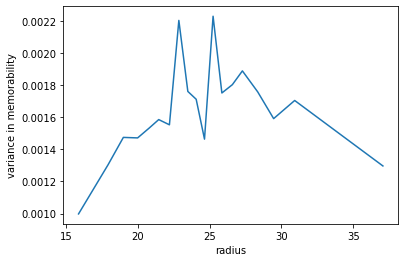

In [131]:
%matplotlib inline
plt.plot(mem_var['radius'], mem_var['cr'])
plt.xlabel('radius')
plt.ylabel('variance in memorability') 
plt.show()

In [132]:
mean_concept_in_feat_cat

index          0          1         2        cr  bigcat  \
0         0  -8.362256   5.447828 -8.557188  0.779739       1   
1         1 -26.123590  12.240625  0.518939  0.798485      13   
2         2 -24.385152  14.180849  0.693800  0.752845      18   
3         3 -25.107906   9.416656 -2.846510  0.761851      99   
4         4 -20.330699  11.947785 -4.992442  0.794466       9   
...     ...        ...        ...       ...       ...     ...   
1849   1849 -17.319193  11.068469  0.200732  0.722655      99   
1850   1850 -19.551059   2.813812 -2.150868  0.843158      10   
1851   1851 -14.748351   9.486465 -8.609210  0.800163       1   
1852   1852 -15.327696  12.965252  0.600495  0.797468      99   
1853   1853 -18.651758   5.749045 -4.932768  0.823237      10   

                cat_name  label  
0                 animal      3  
1             home decor      0  
2     musical instrument      0  
3                    NaN      0  
4      electronic device      0  
...                  ...    ...  
1849                 NaN      1  
1850                food      2  
1851              animal      3  
1852                 NaN      1  
1853                food      2  

[1854 rows x 8 columns]

In [133]:
mean_concept_in_feat_cat.groupby('label')['cat_name'].nunique()

label
0    23
1    17
2    15
3     4
Name: cat_name, dtype: int64

In [134]:
mean_concept_in_feat_cat[mean_concept_in_feat_cat['label'] == 0].groupby('cat_name')['cr'].count().sort_values()

cat_name
drink                  1
kitchen appliance      2
dessert                3
weapon                 3
musical instrument     4
medical equipment      5
body part              5
clothing accessory     5
kitchen tool           6
tool                  11
clothing              12
toy                   13
part of car           13
food                  16
office supply         18
animal                19
sports equipment      21
plant                 24
furniture             26
home decor            27
vehicle               30
electronic device     32
container             61
Name: cr, dtype: int64

In [135]:
mean_concept_in_feat_cat[mean_concept_in_feat_cat['label'] == 1].groupby('cat_name')['cr'].count().sort_values()

cat_name
furniture              8
home decor             9
clothing accessory    10
kitchen tool          10
office supply         10
container             11
part of car           14
medical equipment     16
toy                   16
electronic device     18
body part             25
weapon                26
musical instrument    29
vehicle               35
sports equipment      43
tool                  65
clothing              96
Name: cr, dtype: int64

In [136]:
mean_concept_in_feat_cat[mean_concept_in_feat_cat['label'] == 2].groupby('cat_name')['cr'].count().sort_values()

cat_name
office supply          1
sports equipment       1
animal                 2
kitchen appliance      2
vehicle                2
tool                   3
home decor             4
part of car            4
plant                  4
kitchen tool          10
drink                 17
electronic device     23
container             30
dessert               36
food                 223
Name: cr, dtype: int64

In [137]:
mean_concept_in_feat_cat[mean_concept_in_feat_cat['label'] == 3].groupby('cat_name')['cr'].count().sort_values()

cat_name
clothing       1
container      2
body part      4
animal       157
Name: cr, dtype: int64

In [138]:
pd.DataFrame(mean_concept_in_feat_cat.groupby(['cat_name', 'label'])['cr'].count())

cr
cat_name           label     
animal             0       19
                   2        2
                   3      157
body part          0        5
                   1       25
                   3        4
clothing           0       12
                   1       96
                   3        1
clothing accessory 0        5
                   1       10
container          0       61
                   1       11
                   2       30
                   3        2
dessert            0        3
                   2       36
drink              0        1
                   2       17
electronic device  0       32
                   1       18
                   2       23
food               0       16
                   2      223
furniture          0       26
                   1        8
home decor         0       27
                   1        9
                   2        4
kitchen appliance  0        2
                   2        2
kitchen tool       0        6
                   1       10
                   2       10
medical equipment  0        5
                   1       16
musical instrument 0        4
                   1       29
office supply      0       18
                   1       10
                   2        1
part of car        0       13
                   1       14
                   2        4
plant              0       24
                   2        4
sports equipment   0       21
                   1       43
                   2        1
tool               0       11
                   1       65
                   2        3
toy                0       13
                   1       16
vehicle            0       30
                   1       35
                   2        2
weapon             0        3
                   1       26

<IPython.core.display.Javascript object>


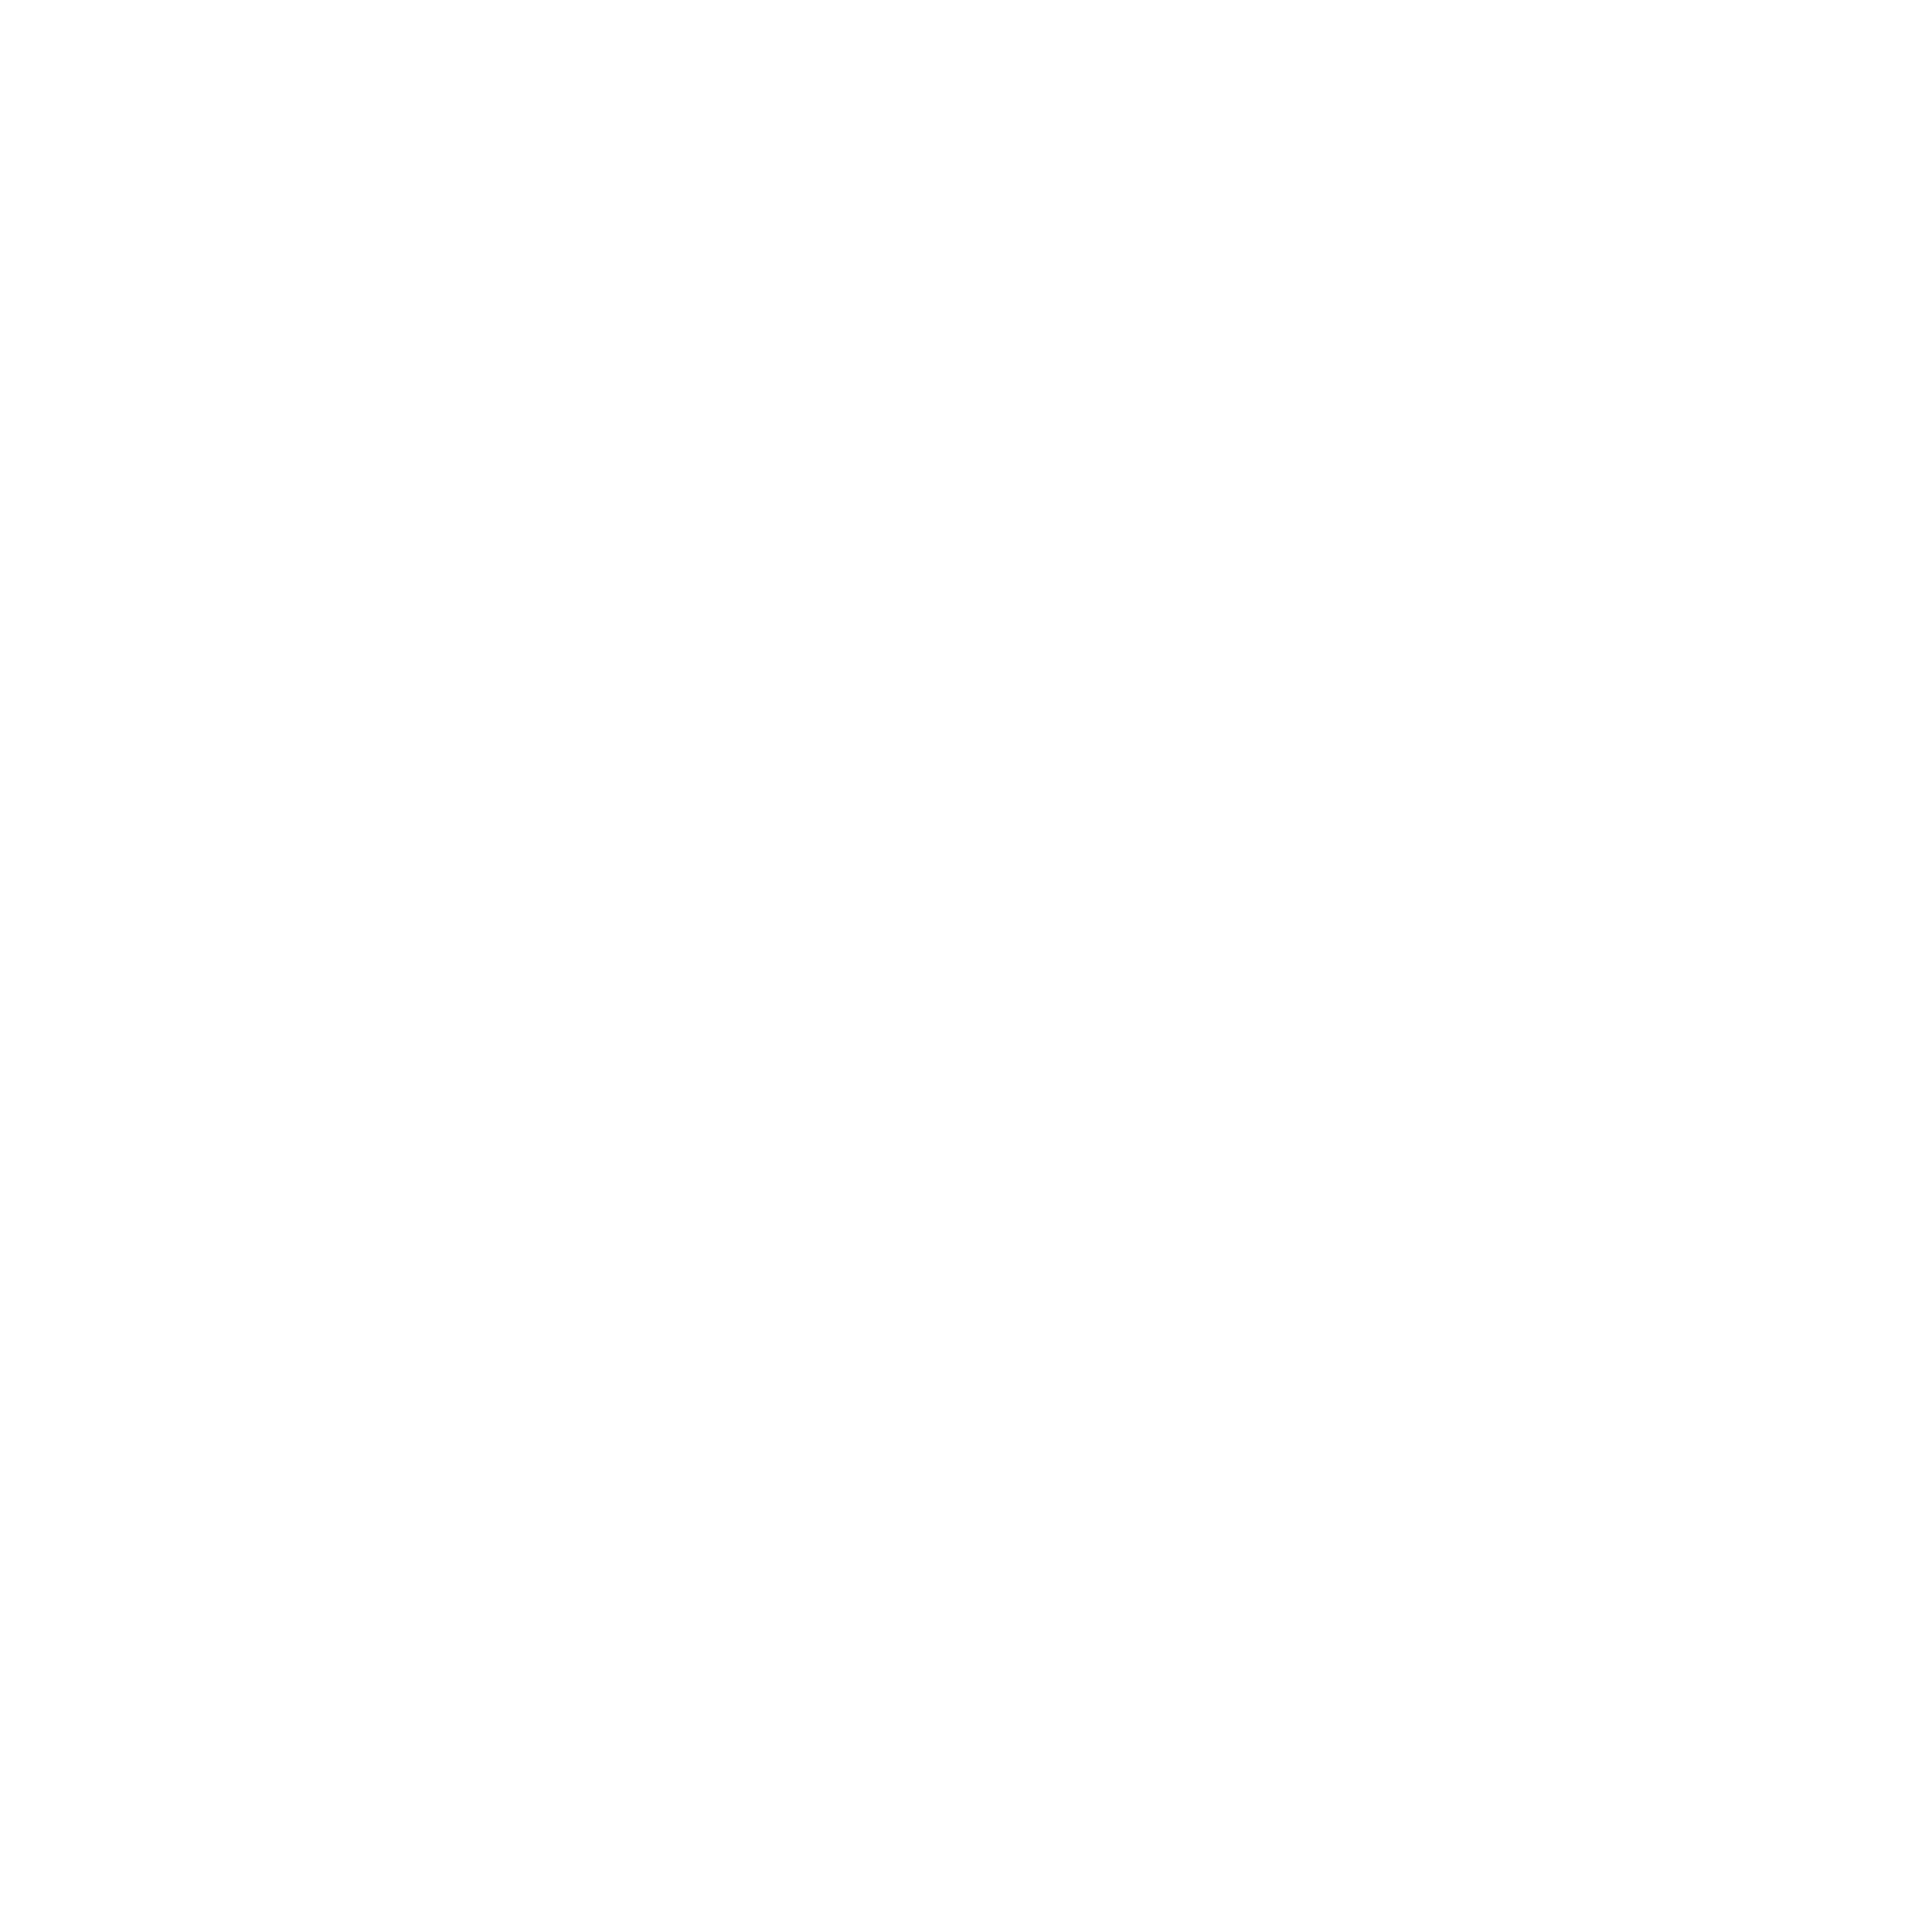

In [139]:
### color by categories: repeat color assignment
import matplotlib.colors as mcolors
%matplotlib notebook

colors = mcolors.CSS4_COLORS
by_hsv = sorted((tuple(mcolors.rgb_to_hsv(mcolors.to_rgb(color))), name)
                for name, color in colors.items())
color_names = [name for hsv, name in by_hsv]

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')

ax.axes.set_xlim3d(left=-30, right=5) 
ax.axes.set_ylim3d(bottom=-5, top=25) 
ax.axes.set_zlim3d(bottom=-20, top=10) 

ax.scatter([0], [0], [0])

# groups = mean_concept_in_feat_cat_na.groupby("cat_name")
groups = mean_concept_in_feat_cat_na[ (mean_concept_in_feat_cat_na['cat_name'] == 'body part') | (mean_concept_in_feat_cat_na['cat_name'] == 'clothing') | (mean_concept_in_feat_cat_na['cat_name'] == 'clothing accessory')].groupby('cat_name')
i = 3
for name, group in groups:
    i = i+6
    ax.scatter(group[0], group[1], group[2], label=name, alpha=0.7, color=color_names[i])
plt.legend(bbox_to_anchor=(0.13,0.7))

# ax.scatter(mean_feature_embed.T[0], mean_feature_embed.T[1], mean_feature_embed.T[2], color='red')


In [346]:
cloth_cluster = mean_concept_in_feat_cat_na[(mean_concept_in_feat_cat_na['cat_name'] == 'body part') | (mean_concept_in_feat_cat_na['cat_name'] == 'clothing') | (mean_concept_in_feat_cat_na['cat_name'] == 'clothing accessory')].merge(typ_coord_cluster[['index', 'typicality']], how='left', right_on='index', left_on='index')
cloth_cluster['typ_poincare'] = poincare_dist_vec(cloth_cluster[[0,1,2]].values).mean(0)
cloth_cluster = cloth_cluster[~np.isnan(cloth_cluster['typicality'])]
cloth_rated = cloth_cluster.merge(concept_typicality_rated, how='inner', left_on='index', right_on='concept', suffixes=['_computed', '_rated'])
cloth_rated = cloth_rated[cloth_rated['bigcat'] == cloth_rated['cat']]
print(f"Poincare typicality and typicality: {stats.spearmanr(cloth_cluster['typ_poincare'], cloth_cluster['typicality'])}")
print(f"Poincare typicality and human_rated typicality: {stats.spearmanr(cloth_rated['typ_poincare'], cloth_rated['typicality_rated'])}")


Poincare typicality and typicality: SpearmanrResult(correlation=-0.5588498826364285, pvalue=2.333475962108213e-14)
Poincare typicality and human_rated typicality: SpearmanrResult(correlation=-0.3671785362102221, pvalue=2.242348324133254e-06)


In [347]:
# radius predicting typicality
zscore_mem = stats.zscore(cloth_cluster['typicality'])
concept_constant = sm.add_constant(np.sqrt((cloth_cluster[[0,1,2]]**2).sum(1)), prepend=False)
mod = sm.OLS(zscore_mem, concept_constant)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:             typicality   R-squared:                       0.221
Model:                            OLS   Adj. R-squared:                  0.216
Method:                 Least Squares   F-statistic:                     44.28
Date:                Thu, 03 Nov 2022   Prob (F-statistic):           4.56e-10
Time:                        16:33:45   Log-Likelihood:                -204.45
No. Observations:                 158   AIC:                             412.9
Df Residuals:                     156   BIC:                             419.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.1441      0.022     -6.654      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [348]:
# radius predicting typ_poincare
zscore_mem = stats.zscore(cloth_cluster['typ_poincare'])
concept_constant = sm.add_constant(np.sqrt((cloth_cluster[[0,1,2]]**2).sum(1)), prepend=False)
mod = sm.OLS(zscore_mem, concept_constant)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:           typ_poincare   R-squared:                       0.967
Model:                            OLS   Adj. R-squared:                  0.966
Method:                 Least Squares   F-statistic:                     4516.
Date:                Thu, 03 Nov 2022   Prob (F-statistic):          4.52e-117
Time:                        16:33:48   Log-Likelihood:                 44.365
No. Observations:                 158   AIC:                            -84.73
Df Residuals:                     156   BIC:                            -78.60
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.3013      0.004     67.200      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [349]:
# radius predicting human_rated typicality
zscore_mem = stats.zscore(cloth_rated['typicality_rated'])
concept_constant = sm.add_constant(np.sqrt((cloth_rated[[0,1,2]]**2).sum(1)), prepend=False)
mod = sm.OLS(zscore_mem, concept_constant)

res = mod.fit()
print(res.summary())


                            OLS Regression Results                            
Dep. Variable:       typicality_rated   R-squared:                       0.137
Model:                            OLS   Adj. R-squared:                  0.131
Method:                 Least Squares   F-statistic:                     24.56
Date:                Thu, 03 Nov 2022   Prob (F-statistic):           1.87e-06
Time:                        16:34:02   Log-Likelihood:                -211.23
No. Observations:                 157   AIC:                             426.5
Df Residuals:                     155   BIC:                             432.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.1135      0.023     -4.956      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [350]:
# radius and typicality predicting mem
zscore_mem = stats.zscore(cloth_cluster['cr'])
cloth_r = pd.concat([np.sqrt((cloth_cluster[[0,1,2]]**2).sum(1)), cloth_cluster['typicality']], axis=1)
concept_constant = sm.add_constant(cloth_r, prepend=False)
mod = sm.OLS(zscore_mem, concept_constant)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.125
Model:                            OLS   Adj. R-squared:                  0.114
Method:                 Least Squares   F-statistic:                     11.09
Date:                Thu, 03 Nov 2022   Prob (F-statistic):           3.15e-05
Time:                        16:34:21   Log-Likelihood:                -213.63
No. Observations:                 158   AIC:                             433.3
Df Residuals:                     155   BIC:                             442.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.0461      0.026     -1.769      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [351]:
# radius and typ_poincare predicting mem
zscore_mem = stats.zscore(cloth_cluster['cr'])
cloth_r = pd.concat([np.sqrt((cloth_cluster[[0,1,2]]**2).sum(1)), cloth_cluster['typ_poincare']], axis=1)
concept_constant = sm.add_constant(cloth_r, prepend=False)
mod = sm.OLS(zscore_mem, concept_constant)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.101
Model:                            OLS   Adj. R-squared:                  0.090
Method:                 Least Squares   F-statistic:                     8.747
Date:                Thu, 03 Nov 2022   Prob (F-statistic):           0.000252
Time:                        16:34:31   Log-Likelihood:                -215.74
No. Observations:                 158   AIC:                             437.5
Df Residuals:                     155   BIC:                             446.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
0                0.1914      0.128      1.499   

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [353]:
# radius and human_rated typicality predicting mem
zscore_mem = stats.zscore(cloth_rated['cr'])
cloth_r = pd.concat([np.sqrt((cloth_rated[[0,1,2]]**2).sum(1)), cloth_rated['typicality_rated']], axis=1)
concept_constant = sm.add_constant(cloth_r, prepend=False)
mod = sm.OLS(zscore_mem, concept_constant)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.105
Model:                            OLS   Adj. R-squared:                  0.093
Method:                 Least Squares   F-statistic:                     8.988
Date:                Thu, 03 Nov 2022   Prob (F-statistic):           0.000203
Time:                        16:35:13   Log-Likelihood:                -214.11
No. Observations:                 157   AIC:                             434.2
Df Residuals:                     154   BIC:                             443.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
0                   -0.1049      0.025  

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<IPython.core.display.Javascript object>


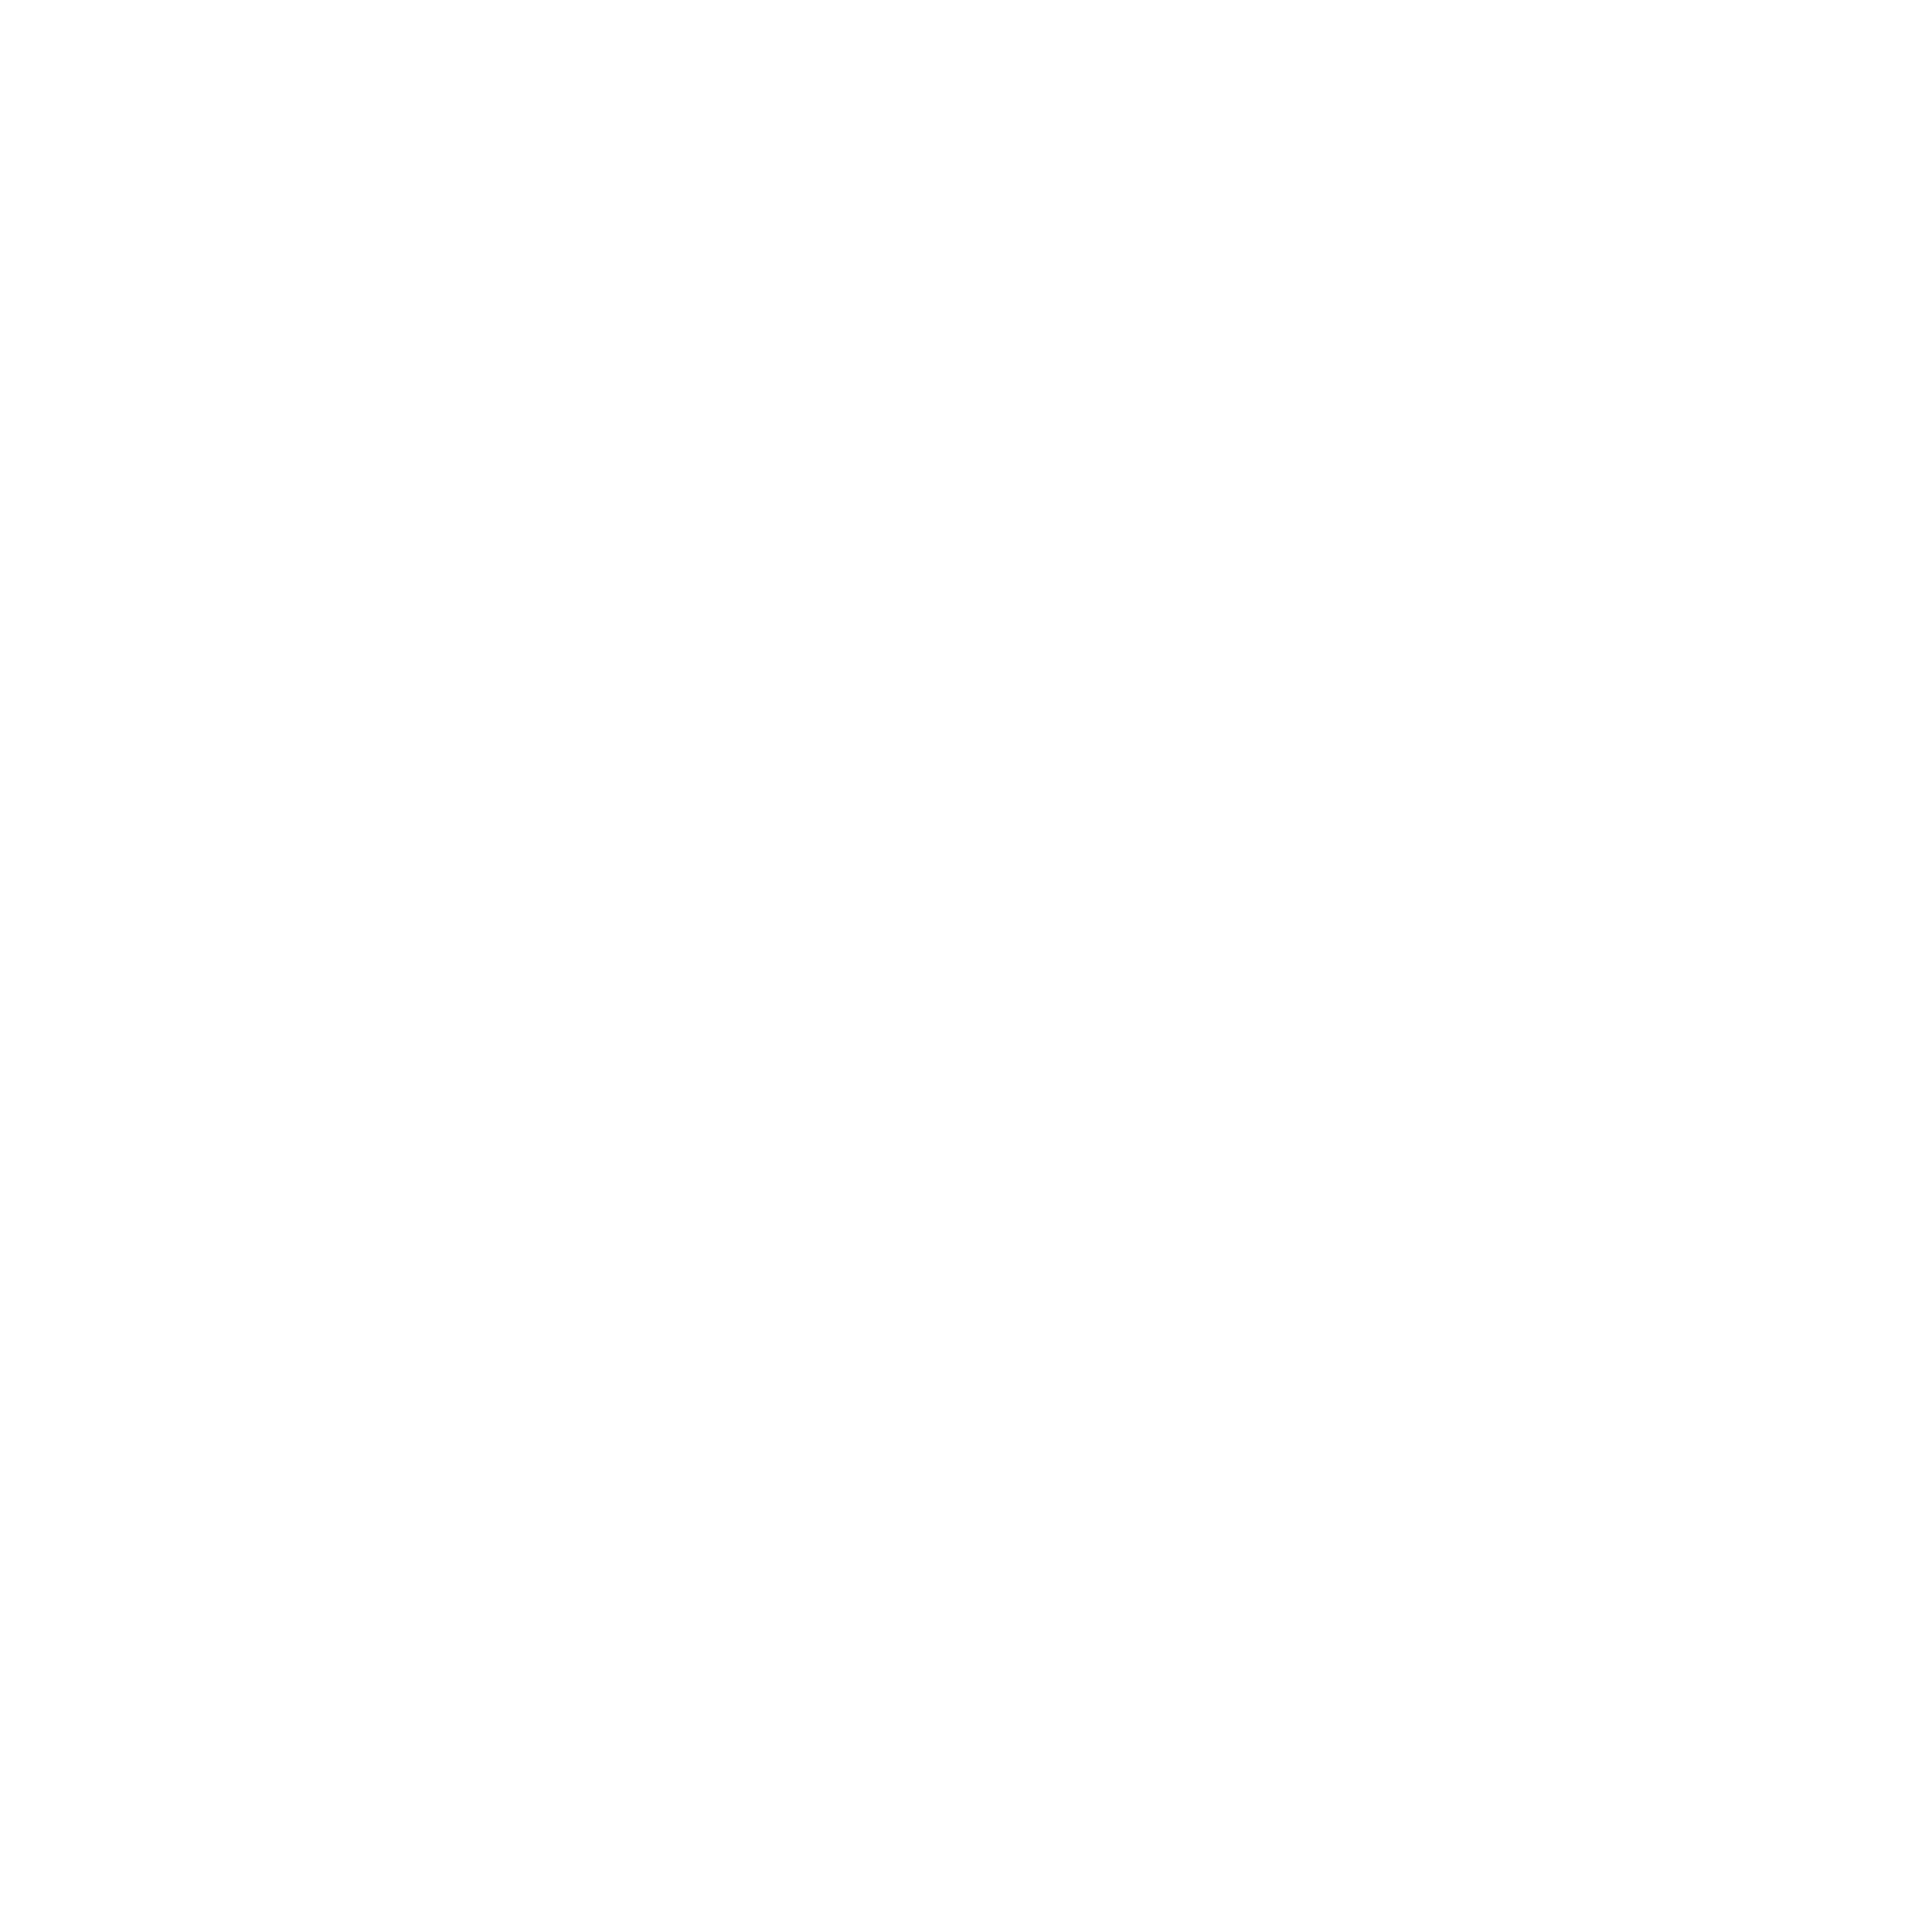

In [145]:
### color by categories: repeat color assignment
import matplotlib.colors as mcolors
%matplotlib notebook

colors = mcolors.CSS4_COLORS
by_hsv = sorted((tuple(mcolors.rgb_to_hsv(mcolors.to_rgb(color))), name)
                for name, color in colors.items())
color_names = [name for hsv, name in by_hsv]

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')

ax.axes.set_xlim3d(left=-30, right=5) 
ax.axes.set_ylim3d(bottom=-5, top=25) 
ax.axes.set_zlim3d(bottom=-20, top=10) 

ax.scatter([0], [0], [0])
groups = mean_concept_in_feat_cat_na[ (mean_concept_in_feat_cat_na['cat_name'] == 'tool') | (mean_concept_in_feat_cat_na['cat_name'] == 'weapon') | (mean_concept_in_feat_cat_na['cat_name'] == 'musical instrument') | (mean_concept_in_feat_cat_na['cat_name'] == 'sports equipment')].groupby('cat_name')
i = 3
for name, group in groups:
#     i = i+7
    ax.scatter(group[0], group[1], group[2], label=name, alpha=0.7)
plt.legend(bbox_to_anchor=(0.13,0.7))

# ax.scatter(mean_feature_embed.T[0], mean_feature_embed.T[1], mean_feature_embed.T[2], color='red')


In [354]:
tool_cluster = mean_concept_in_feat_cat_na[ (mean_concept_in_feat_cat_na['cat_name'] == 'tool') | (mean_concept_in_feat_cat_na['cat_name'] == 'weapon') | (mean_concept_in_feat_cat_na['cat_name'] == 'musical instrument') | (mean_concept_in_feat_cat_na['cat_name'] == 'sports equipment')].merge(typ_coord_cluster[['index', 'typicality']], how='left', right_on='index', left_on='index')
tool_cluster['typ_poincare'] = poincare_dist_vec(tool_cluster[[0,1,2]].values).mean(0)
tool_cluster = tool_cluster[~np.isnan(tool_cluster['typicality'])]
tool_rated = tool_cluster.merge(concept_typicality_rated, how='inner', left_on='index', right_on='concept', suffixes=['_computed', '_rated'])
tool_rated = tool_rated[tool_rated['bigcat'] == tool_rated['cat']]
print(f"Poincare typicality and typicality: {stats.spearmanr(tool_cluster['typ_poincare'], tool_cluster['typicality'])}")
print(f"Poincare typicality and human_rated typicality: {stats.spearmanr(tool_rated['typ_poincare'], tool_rated['typicality_rated'])}")


Poincare typicality and typicality: SpearmanrResult(correlation=-0.4768030145476634, pvalue=4.326290666334462e-13)
Poincare typicality and human_rated typicality: SpearmanrResult(correlation=-0.22751302118655567, pvalue=0.001505341446277038)


In [355]:
# radius predicting typicality
zscore_mem = stats.zscore(tool_cluster['typicality'])
concept_constant = sm.add_constant(np.sqrt((tool_cluster[[0,1,2]]**2).sum(1)), prepend=False)
mod = sm.OLS(zscore_mem, concept_constant)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:             typicality   R-squared:                       0.201
Model:                            OLS   Adj. R-squared:                  0.197
Method:                 Least Squares   F-statistic:                     51.25
Date:                Thu, 03 Nov 2022   Prob (F-statistic):           1.44e-11
Time:                        16:52:13   Log-Likelihood:                -269.21
No. Observations:                 206   AIC:                             542.4
Df Residuals:                     204   BIC:                             549.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.1257      0.018     -7.159      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [356]:
# radius predicting typ_poincare
zscore_mem = stats.zscore(tool_cluster['typ_poincare'])
concept_constant = sm.add_constant(np.sqrt((tool_cluster[[0,1,2]]**2).sum(1)), prepend=False)
mod = sm.OLS(zscore_mem, concept_constant)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:           typ_poincare   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.977
Method:                 Least Squares   F-statistic:                     8776.
Date:                Thu, 03 Nov 2022   Prob (F-statistic):          1.26e-169
Time:                        16:52:23   Log-Likelihood:                 97.516
No. Observations:                 206   AIC:                            -191.0
Df Residuals:                     204   BIC:                            -184.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.2774      0.003     93.680      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [359]:
# radius predicting human_rated typicality
zscore_mem = stats.zscore(tool_rated['typicality_rated'])
concept_constant = sm.add_constant(np.sqrt((tool_rated[[0,1,2]]**2).sum(1)), prepend=False)
mod = sm.OLS(zscore_mem, concept_constant)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:       typicality_rated   R-squared:                       0.059
Model:                            OLS   Adj. R-squared:                  0.054
Method:                 Least Squares   F-statistic:                     11.99
Date:                Thu, 03 Nov 2022   Prob (F-statistic):           0.000662
Time:                        16:53:15   Log-Likelihood:                -266.56
No. Observations:                 192   AIC:                             537.1
Df Residuals:                     190   BIC:                             543.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.0695      0.020     -3.462      0.0

In [360]:
# radius and typicality predicting mem
zscore_mem = stats.zscore(tool_cluster['cr'])
tool_r = pd.concat([np.sqrt((tool_cluster[[0,1,2]]**2).sum(1)), tool_cluster['typicality']], axis=1)
concept_constant = sm.add_constant(tool_r, prepend=False)
mod = sm.OLS(zscore_mem, concept_constant)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     3.208
Date:                Thu, 03 Nov 2022   Prob (F-statistic):             0.0425
Time:                        16:53:20   Log-Likelihood:                -289.10
No. Observations:                 206   AIC:                             584.2
Df Residuals:                     203   BIC:                             594.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.0532      0.022     -2.452      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [361]:
# radius and typ_poincare predicting mem
zscore_mem = stats.zscore(tool_cluster['cr'])
tool_r = pd.concat([np.sqrt((tool_cluster[[0,1,2]]**2).sum(1)), tool_cluster['typ_poincare']], axis=1)
concept_constant = sm.add_constant(tool_r, prepend=False)
mod = sm.OLS(zscore_mem, concept_constant)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.041
Model:                            OLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     4.360
Date:                Thu, 03 Nov 2022   Prob (F-statistic):             0.0140
Time:                        16:53:21   Log-Likelihood:                -287.97
No. Observations:                 206   AIC:                             581.9
Df Residuals:                     203   BIC:                             591.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
0               -0.3211      0.128     -2.509   

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [363]:
# radius and typ_poincare predicting mem
zscore_mem = stats.zscore(tool_rated['cr'])
tool_r = pd.concat([np.sqrt((tool_rated[[0,1,2]]**2).sum(1)), tool_rated['typicality_rated']], axis=1)
concept_constant = sm.add_constant(tool_r, prepend=False)
mod = sm.OLS(zscore_mem, concept_constant)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     2.230
Date:                Thu, 03 Nov 2022   Prob (F-statistic):              0.110
Time:                        16:53:48   Log-Likelihood:                -270.20
No. Observations:                 192   AIC:                             546.4
Df Residuals:                     189   BIC:                             556.2
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
0                   -0.0441      0.021  

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<IPython.core.display.Javascript object>


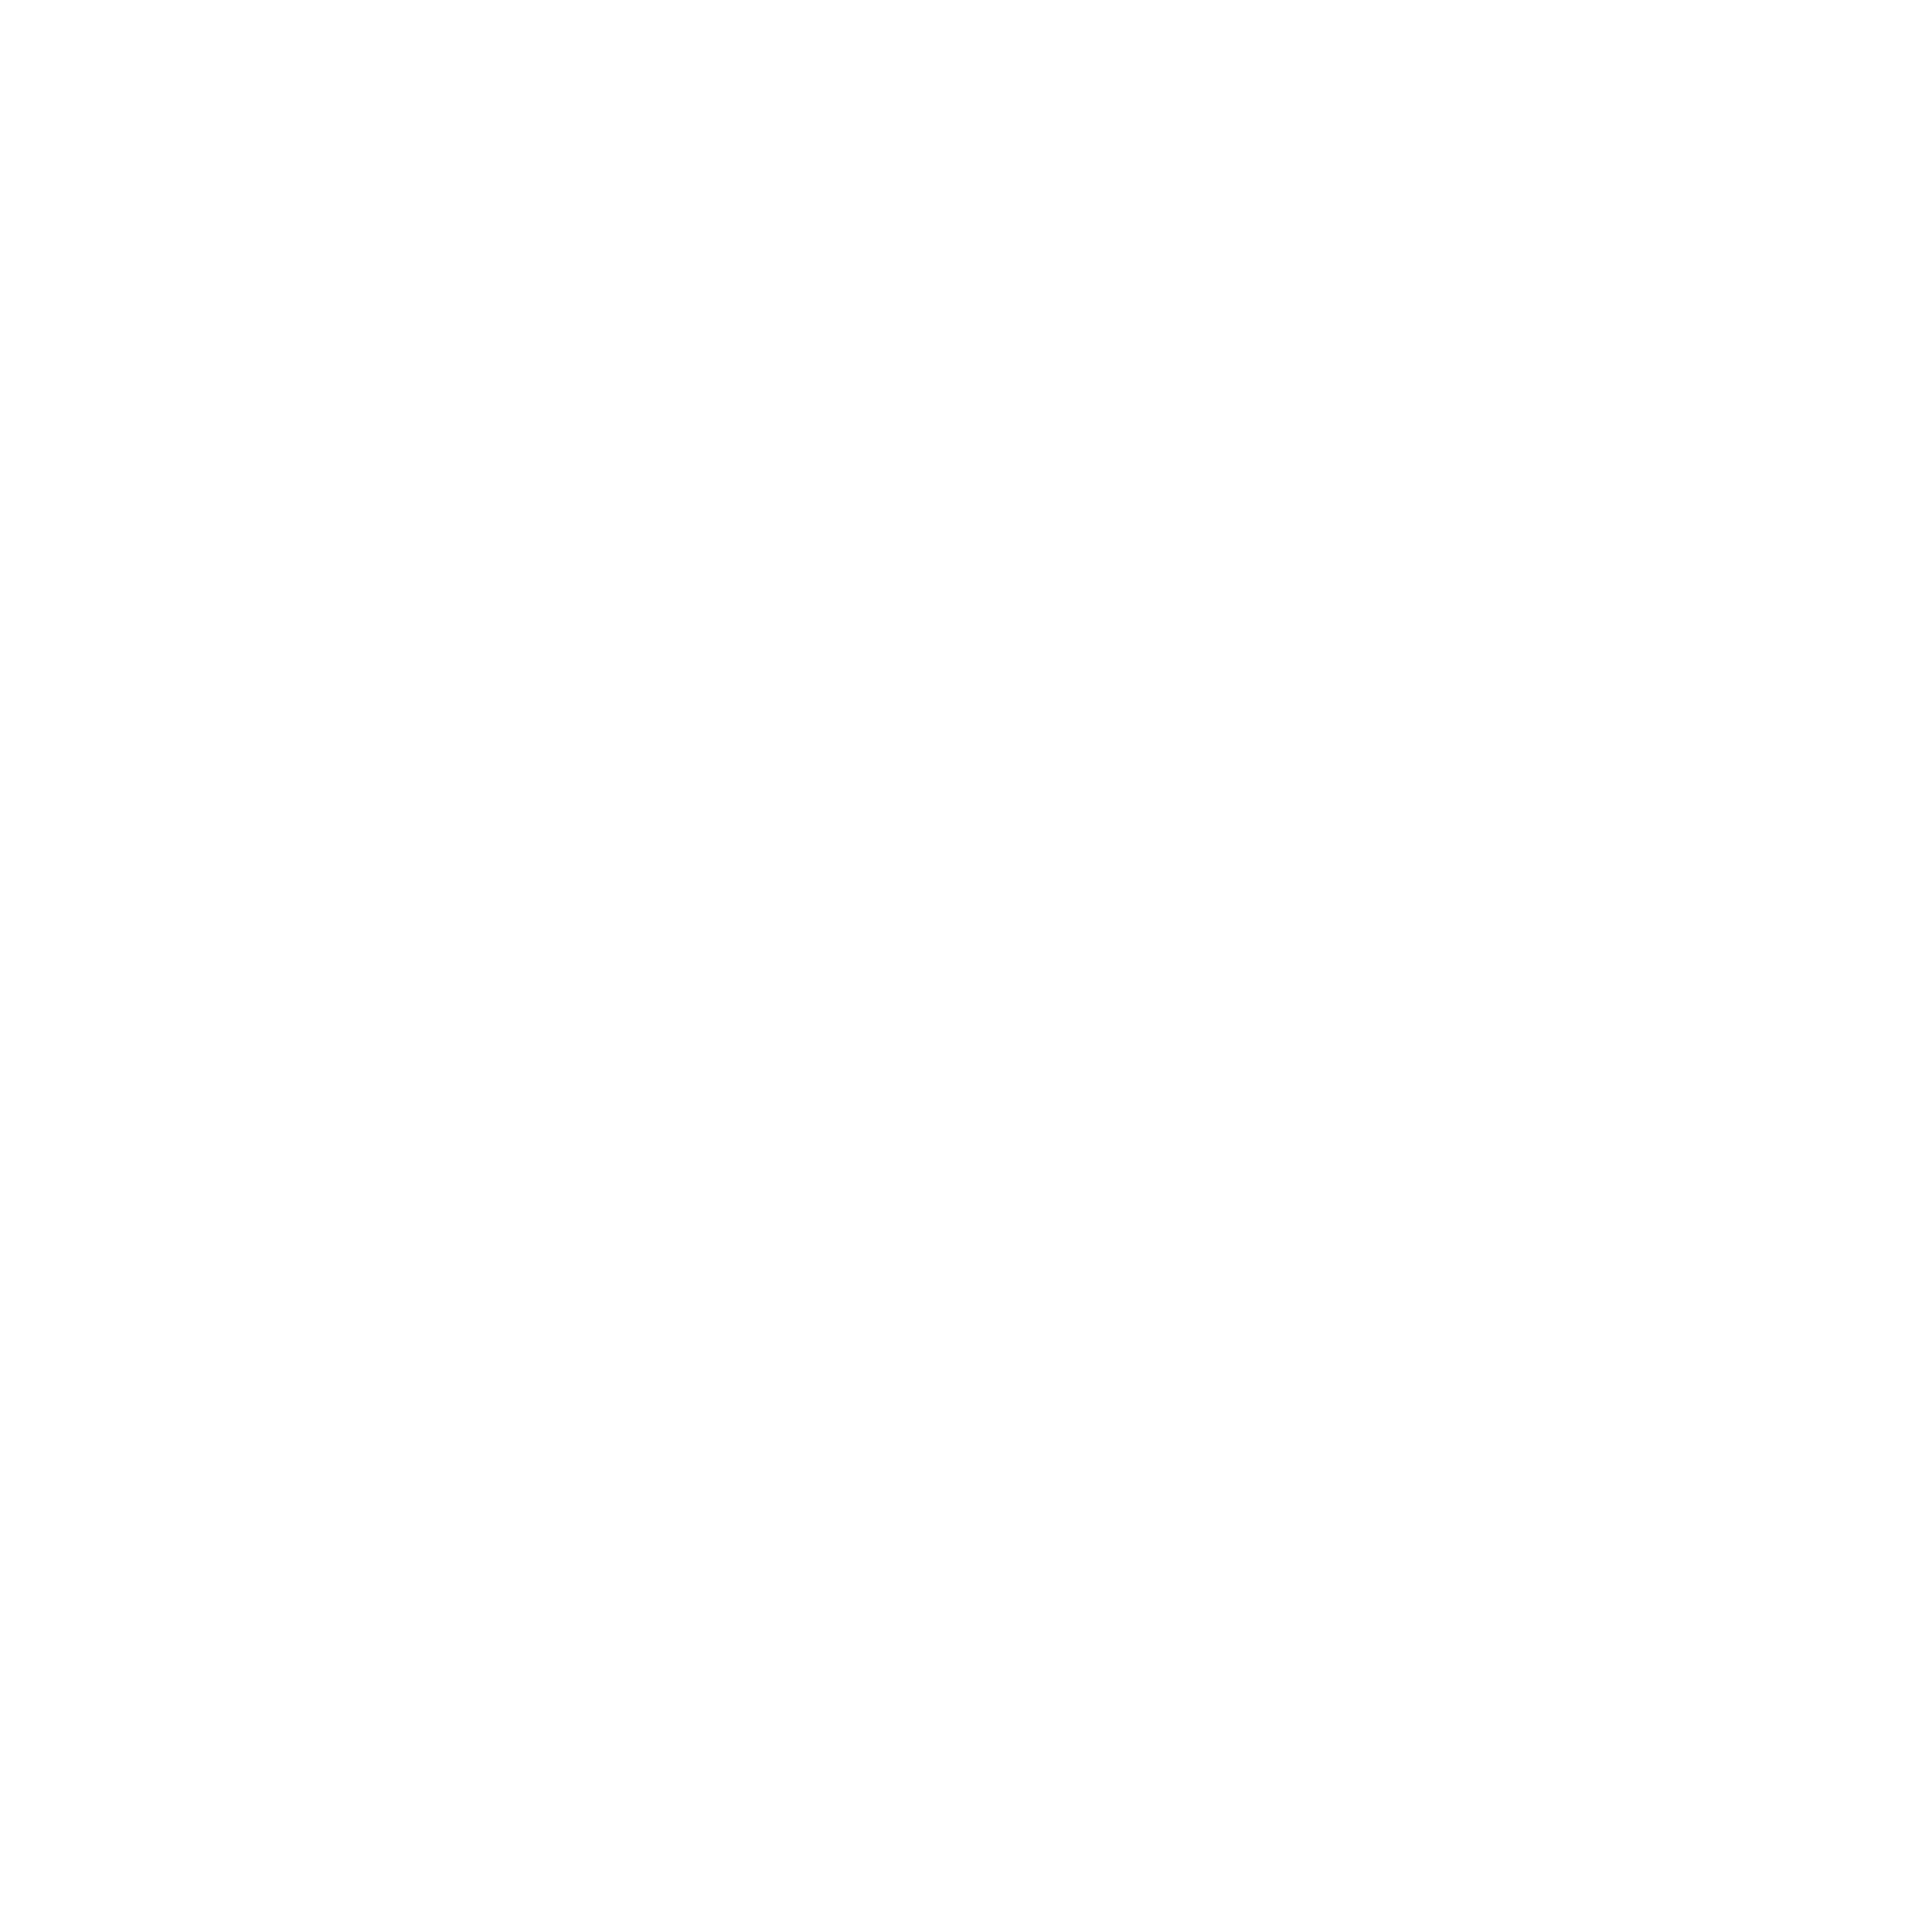

In [151]:
### color by categories: repeat color assignment
import matplotlib.colors as mcolors
%matplotlib notebook

colors = mcolors.CSS4_COLORS
by_hsv = sorted((tuple(mcolors.rgb_to_hsv(mcolors.to_rgb(color))), name)
                for name, color in colors.items())
color_names = [name for hsv, name in by_hsv]

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')

ax.axes.set_xlim3d(left=-30, right=5) 
ax.axes.set_ylim3d(bottom=-5, top=25) 
ax.axes.set_zlim3d(bottom=-20, top=10) 

ax.scatter([0], [0], [0])

# groups = mean_concept_in_feat_cat_na.groupby("cat_name")
groups = mean_concept_in_feat_cat_na[ (mean_concept_in_feat_cat_na['cat_name'] == 'food') | (mean_concept_in_feat_cat_na['cat_name'] == 'dessert') | (mean_concept_in_feat_cat_na['cat_name'] == 'drink') | (mean_concept_in_feat_cat_na['cat_name'] == 'container')].groupby('cat_name')
i = 3
for name, group in groups:
    i = i+6
    ax.scatter(group[0], group[1], group[2], label=name, alpha=0.5, color=color_names[i])
    
groups = mean_concept_in_feat_cat_na[ (mean_concept_in_feat_cat_na['cat_name'] == 'body part') | (mean_concept_in_feat_cat_na['cat_name'] == 'clothing') | (mean_concept_in_feat_cat_na['cat_name'] == 'clothing accessory')].groupby('cat_name')
i = 27
for name, group in groups:
    i = i+6
    ax.scatter(group[0], group[1], group[2], label=name, alpha=0.5, color=color_names[i])
    
backpack = mean_concept_in_feat_cat_na[mean_concept_in_feat_cat_na['concept_name'] == 'backpack']
wok = mean_concept_in_feat_cat_na[mean_concept_in_feat_cat_na['concept_name'] == 'wok']
ax.scatter(backpack[0], backpack[1], backpack[2], label='backpack', color='b')
ax.scatter(wok[0], wok[1], wok[2], label='wok', color='g')


plt.legend(bbox_to_anchor=(0.13,0.7))

# ax.scatter(mean_feature_embed.T[0], mean_feature_embed.T[1], mean_feature_embed.T[2], color='red')


In [364]:
food_cluster = mean_concept_in_feat_cat_na[ (mean_concept_in_feat_cat_na['cat_name'] == 'food') | (mean_concept_in_feat_cat_na['cat_name'] == 'dessert') | (mean_concept_in_feat_cat_na['cat_name'] == 'drink') | (mean_concept_in_feat_cat_na['cat_name'] == 'container')].merge(typ_coord_cluster[['index', 'typicality']], how='left', right_on='index', left_on='index')
food_cluster['typ_poincare'] = poincare_dist_vec(food_cluster[[0,1,2]].values).mean(0)
food_cluster = food_cluster[~np.isnan(food_cluster['typicality'])]
food_rated = food_cluster.merge(concept_typicality_rated, how='inner', left_on='index', right_on='concept', suffixes=['_computed', '_rated'])
food_rated = food_rated[food_rated['bigcat'] == food_rated['cat']]
print(f"Poincare typicality and typicality: {stats.spearmanr(food_cluster['typ_poincare'], food_cluster['typicality'])}")
print(f"Poincare typicality and human_rated typicality: {stats.spearmanr(food_rated['typ_poincare'], food_rated['typicality_rated'])}")


Poincare typicality and typicality: SpearmanrResult(correlation=-0.7358147863424146, pvalue=2.2646889267207983e-69)
Poincare typicality and human_rated typicality: SpearmanrResult(correlation=-0.3689541526929532, pvalue=3.242318922448977e-14)


In [365]:
# radius predicting typicality
zscore_mem = stats.zscore(food_cluster['typicality'])
concept_constant = sm.add_constant(np.sqrt((food_cluster[[0,1,2]]**2).sum(1)), prepend=False)
mod = sm.OLS(zscore_mem, concept_constant)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:             typicality   R-squared:                       0.463
Model:                            OLS   Adj. R-squared:                  0.461
Method:                 Least Squares   F-statistic:                     342.8
Date:                Thu, 03 Nov 2022   Prob (F-statistic):           1.17e-55
Time:                        16:55:25   Log-Likelihood:                -443.31
No. Observations:                 400   AIC:                             890.6
Df Residuals:                     398   BIC:                             898.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.1700      0.009    -18.516      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [366]:
# radius predicting typ_poincare
zscore_mem = stats.zscore(food_cluster['typ_poincare'])
concept_constant = sm.add_constant(np.sqrt((food_cluster[[0,1,2]]**2).sum(1)), prepend=False)
mod = sm.OLS(zscore_mem, concept_constant)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:           typ_poincare   R-squared:                       0.981
Model:                            OLS   Adj. R-squared:                  0.981
Method:                 Least Squares   F-statistic:                 2.080e+04
Date:                Thu, 03 Nov 2022   Prob (F-statistic):               0.00
Time:                        16:55:33   Log-Likelihood:                 227.46
No. Observations:                 400   AIC:                            -450.9
Df Residuals:                     398   BIC:                            -442.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.2476      0.002    144.221      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [367]:
# radius predicting human_rated typicality
zscore_mem = stats.zscore(food_rated['typicality_rated'])
concept_constant = sm.add_constant(np.sqrt((food_rated[[0,1,2]]**2).sum(1)), prepend=False)
mod = sm.OLS(zscore_mem, concept_constant)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:       typicality_rated   R-squared:                       0.138
Model:                            OLS   Adj. R-squared:                  0.136
Method:                 Least Squares   F-statistic:                     63.00
Date:                Thu, 03 Nov 2022   Prob (F-statistic):           2.18e-14
Time:                        16:55:55   Log-Likelihood:                -532.53
No. Observations:                 396   AIC:                             1069.
Df Residuals:                     394   BIC:                             1077.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.0937      0.012     -7.937      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [368]:
# radius and typicality predicting mem
zscore_mem = stats.zscore(food_cluster['cr'])
food_r = pd.concat([np.sqrt((food_cluster[[0,1,2]]**2).sum(1)), food_cluster['typicality']], axis=1)
concept_constant = sm.add_constant(food_r, prepend=False)
mod = sm.OLS(zscore_mem, concept_constant)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.140
Model:                            OLS   Adj. R-squared:                  0.135
Method:                 Least Squares   F-statistic:                     32.24
Date:                Thu, 03 Nov 2022   Prob (F-statistic):           1.06e-13
Time:                        16:56:02   Log-Likelihood:                -537.47
No. Observations:                 400   AIC:                             1081.
Df Residuals:                     397   BIC:                             1093.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.0037      0.016     -0.231      0.8

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [369]:
# radius and typ_poincare predicting mem
zscore_mem = stats.zscore(food_cluster['cr'])
food_r = pd.concat([np.sqrt((food_cluster[[0,1,2]]**2).sum(1)), food_cluster['typ_poincare']], axis=1)
concept_constant = sm.add_constant(food_r, prepend=False)
mod = sm.OLS(zscore_mem, concept_constant)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.109
Model:                            OLS   Adj. R-squared:                  0.104
Method:                 Least Squares   F-statistic:                     24.27
Date:                Thu, 03 Nov 2022   Prob (F-statistic):           1.14e-10
Time:                        16:56:06   Log-Likelihood:                -544.51
No. Observations:                 400   AIC:                             1095.
Df Residuals:                     397   BIC:                             1107.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
0                0.2969      0.086      3.436   

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [370]:
# radius and human_rated typicality predicting mem
zscore_mem = stats.zscore(food_rated['cr'])
food_r = pd.concat([np.sqrt((food_rated[[0,1,2]]**2).sum(1)), food_rated['typicality_rated']], axis=1)
concept_constant = sm.add_constant(food_r, prepend=False)
mod = sm.OLS(zscore_mem, concept_constant)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.068
Model:                            OLS   Adj. R-squared:                  0.063
Method:                 Least Squares   F-statistic:                     14.32
Date:                Thu, 03 Nov 2022   Prob (F-statistic):           9.89e-07
Time:                        16:56:29   Log-Likelihood:                -547.97
No. Observations:                 396   AIC:                             1102.
Df Residuals:                     393   BIC:                             1114.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
0                   -0.0593      0.013  

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<IPython.core.display.Javascript object>


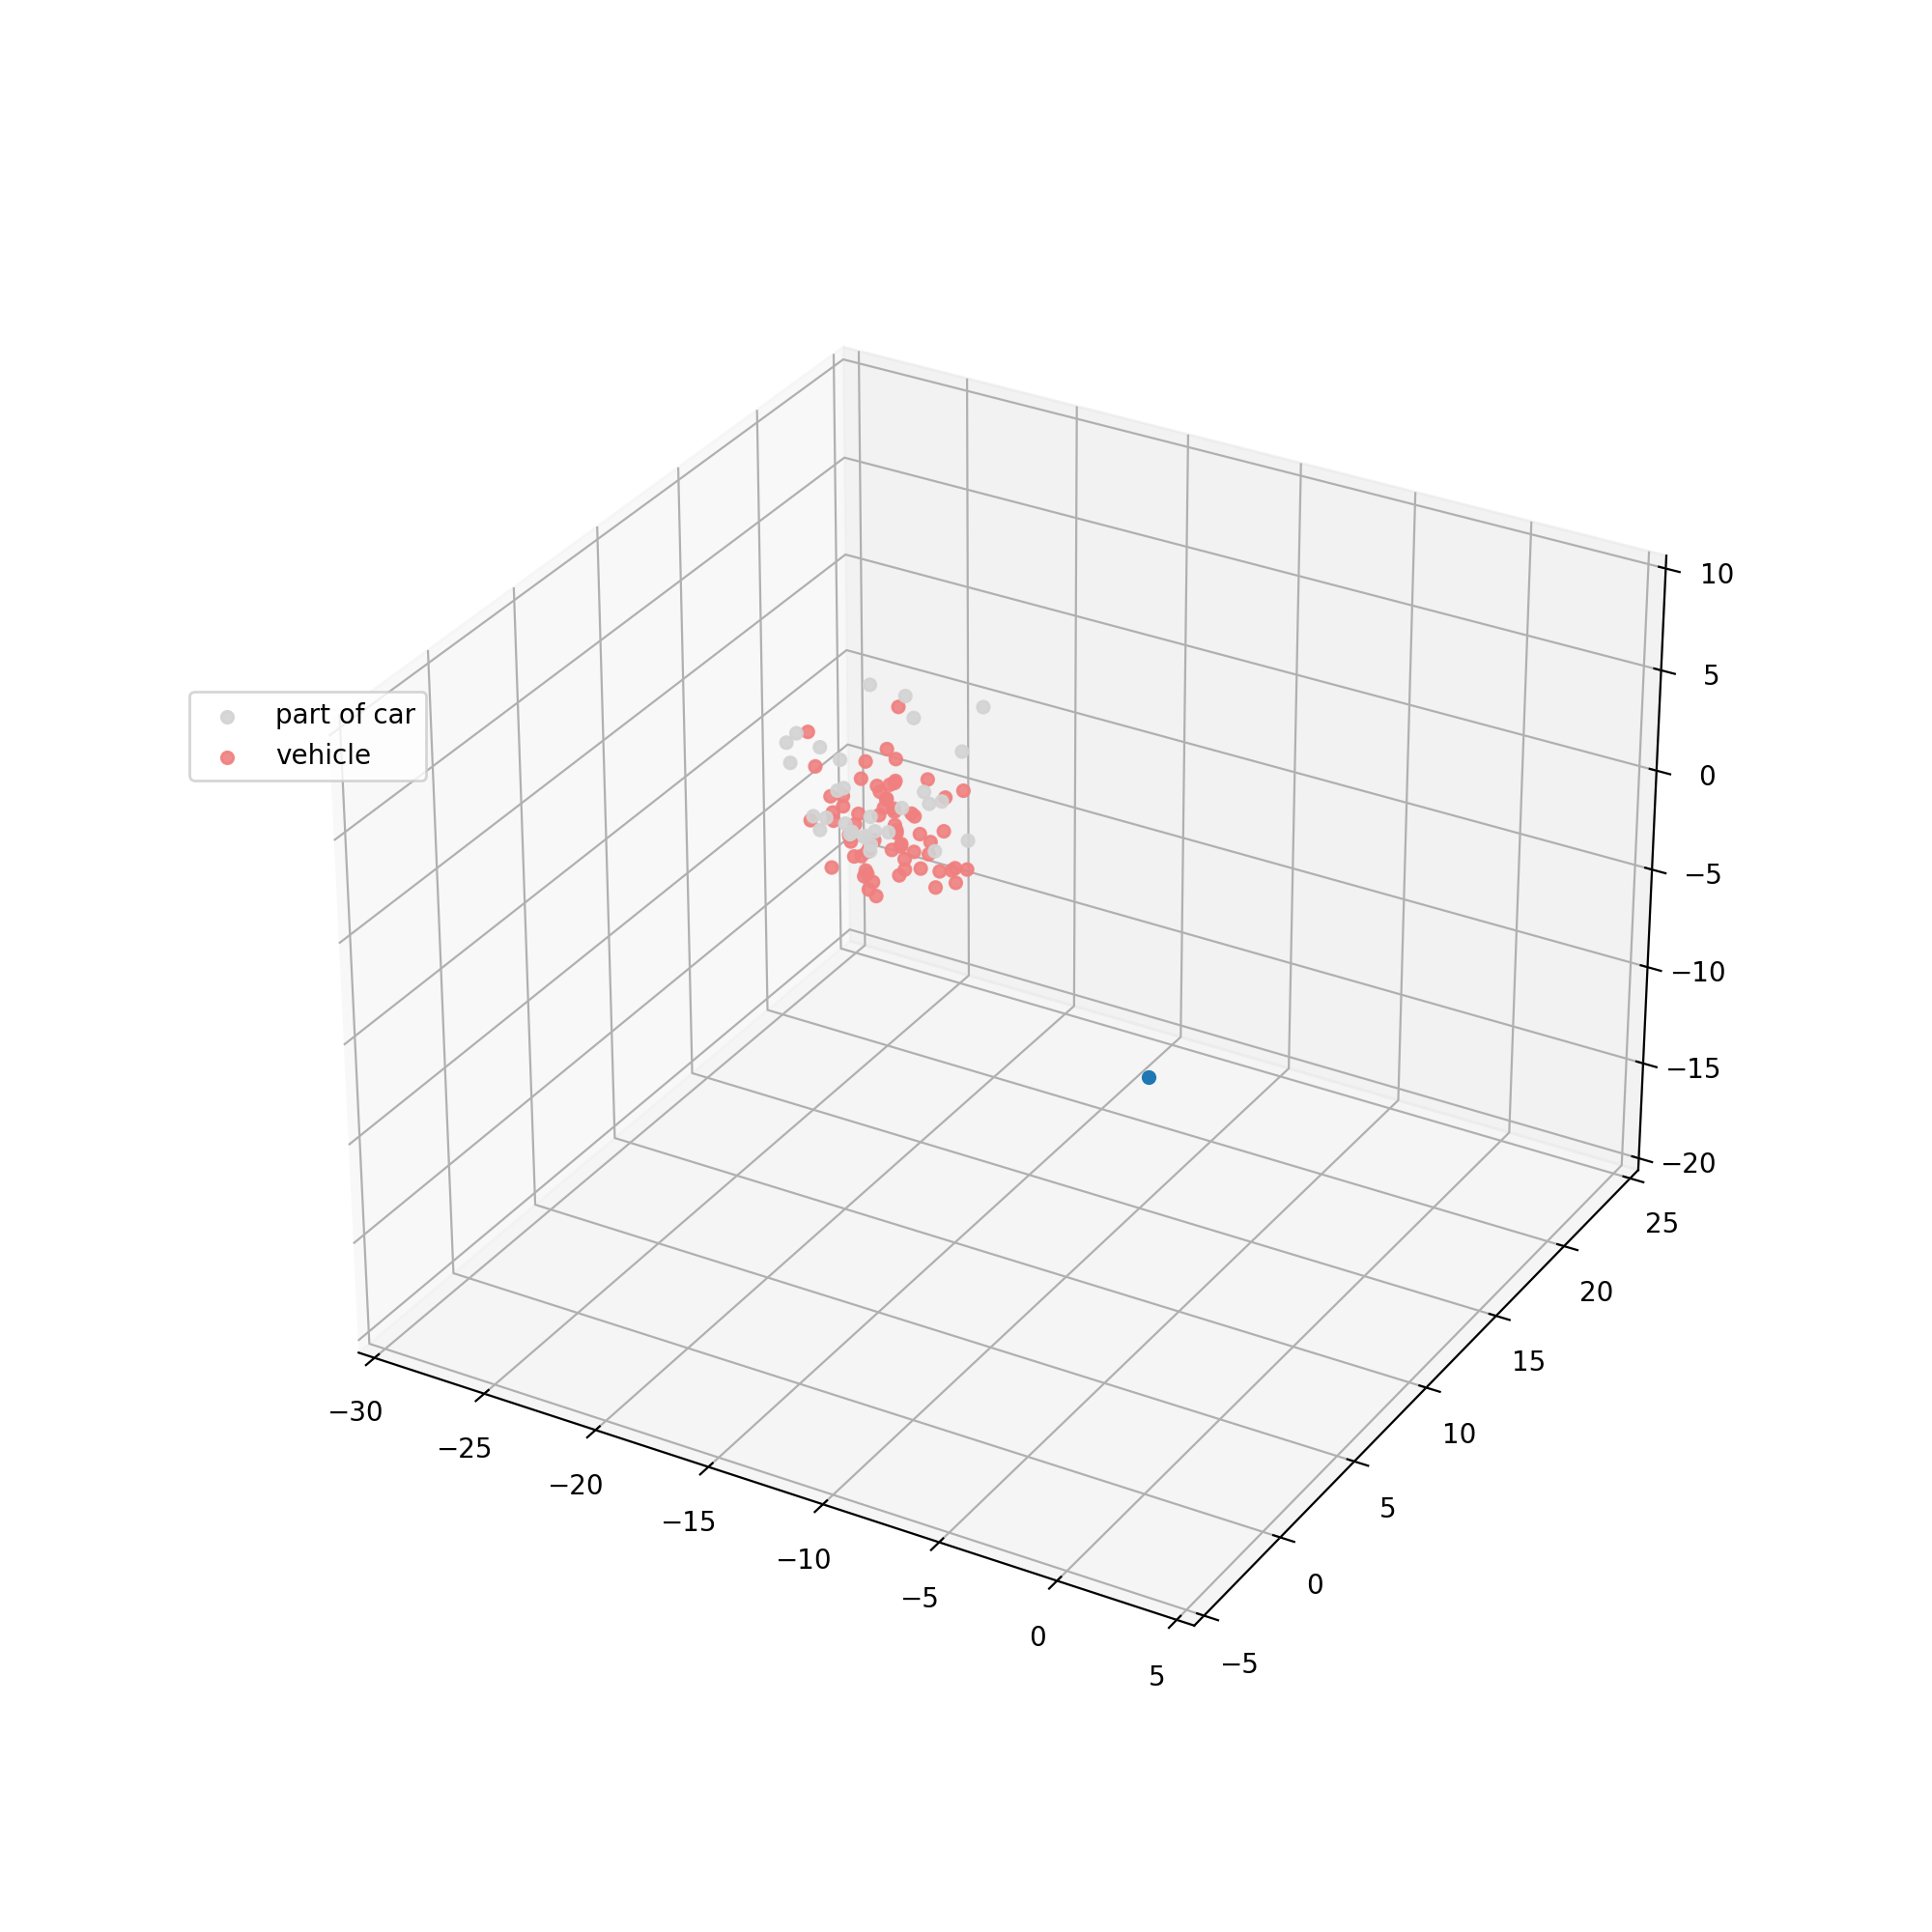

In [157]:
### color by categories: repeat color assignment
import matplotlib.colors as mcolors
%matplotlib notebook

colors = mcolors.CSS4_COLORS
by_hsv = sorted((tuple(mcolors.rgb_to_hsv(mcolors.to_rgb(color))), name)
                for name, color in colors.items())
color_names = [name for hsv, name in by_hsv]

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')

ax.axes.set_xlim3d(left=-30, right=5) 
ax.axes.set_ylim3d(bottom=-5, top=25) 
ax.axes.set_zlim3d(bottom=-20, top=10) 

ax.scatter([0], [0], [0])

# groups = mean_concept_in_feat_cat_na.groupby("cat_name")
groups = mean_concept_in_feat_cat_na[ (mean_concept_in_feat_cat_na['cat_name'] == 'vehicle') | (mean_concept_in_feat_cat_na['cat_name'] == 'part of car')].groupby('cat_name')
i = 3
for name, group in groups:
    i = i+6
    ax.scatter(group[0], group[1], group[2], label=name, alpha=0.9, color=color_names[i])
plt.legend(bbox_to_anchor=(0.13,0.7))

# ax.scatter(mean_feature_embed.T[0], mean_feature_embed.T[1], mean_feature_embed.T[2], color='red')


In [371]:
vehicle_cluster = mean_concept_in_feat_cat_na[ (mean_concept_in_feat_cat_na['cat_name'] == 'vehicle') | (mean_concept_in_feat_cat_na['cat_name'] == 'part of car')].merge(typ_coord_cluster[['index', 'typicality']], how='left', right_on='index', left_on='index')
vehicle_cluster['typ_poincare'] = poincare_dist_vec(vehicle_cluster[[0,1,2]].values).mean(0)
vehicle_cluster = vehicle_cluster[~np.isnan(vehicle_cluster['typicality'])]
vehicle_rated = vehicle_cluster.merge(concept_typicality_rated, how='inner', left_on='index', right_on='concept', suffixes=['_computed', '_rated'])
vehicle_rated = vehicle_rated[vehicle_rated['bigcat'] == vehicle_rated['cat']]
print(f"Poincare typicality and typicality: {stats.spearmanr(vehicle_cluster['typ_poincare'], vehicle_cluster['typicality'])}")
print(f"Poincare typicality and human_rated typicality: {stats.spearmanr(vehicle_rated['typ_poincare'], vehicle_rated['typicality_rated'])}")



Poincare typicality and typicality: SpearmanrResult(correlation=-0.5656204374908351, pvalue=1.2908135046274093e-09)
Poincare typicality and human_rated typicality: SpearmanrResult(correlation=-0.38224362452523064, pvalue=0.00012146098346123823)


In [372]:
# radius predicting typicality
zscore_mem = stats.zscore(vehicle_cluster['typicality'])
concept_constant = sm.add_constant(np.sqrt((vehicle_cluster[[0,1,2]]**2).sum(1)), prepend=False)
mod = sm.OLS(zscore_mem, concept_constant)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:             typicality   R-squared:                       0.195
Model:                            OLS   Adj. R-squared:                  0.187
Method:                 Least Squares   F-statistic:                     23.31
Date:                Thu, 03 Nov 2022   Prob (F-statistic):           5.20e-06
Time:                        16:57:41   Log-Likelihood:                -128.40
No. Observations:                  98   AIC:                             260.8
Df Residuals:                      96   BIC:                             266.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.1321      0.027     -4.828      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [373]:
# radius predicting typ_poincare
zscore_mem = stats.zscore(vehicle_cluster['typ_poincare'])
concept_constant = sm.add_constant(np.sqrt((vehicle_cluster[[0,1,2]]**2).sum(1)), prepend=False)
mod = sm.OLS(zscore_mem, concept_constant)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:           typ_poincare   R-squared:                       0.963
Model:                            OLS   Adj. R-squared:                  0.963
Method:                 Least Squares   F-statistic:                     2515.
Date:                Thu, 03 Nov 2022   Prob (F-statistic):           1.15e-70
Time:                        16:57:43   Log-Likelihood:                 22.798
No. Observations:                  98   AIC:                            -41.60
Df Residuals:                      96   BIC:                            -36.43
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0              0.2934      0.006     50.150      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [374]:
# radius predicting human_rated typicality
zscore_mem = stats.zscore(vehicle_rated['typicality_rated'])
concept_constant = sm.add_constant(np.sqrt((vehicle_rated[[0,1,2]]**2).sum(1)), prepend=False)
mod = sm.OLS(zscore_mem, concept_constant)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:       typicality_rated   R-squared:                       0.143
Model:                            OLS   Adj. R-squared:                  0.134
Method:                 Least Squares   F-statistic:                     15.66
Date:                Thu, 03 Nov 2022   Prob (F-statistic):           0.000147
Time:                        16:58:09   Log-Likelihood:                -128.82
No. Observations:                  96   AIC:                             261.6
Df Residuals:                      94   BIC:                             266.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.1121      0.028     -3.958      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [375]:
# radius and typicality predicting mem
zscore_mem = stats.zscore(vehicle_cluster['cr'])
vehicle_r = pd.concat([np.sqrt((vehicle_cluster[[0,1,2]]**2).sum(1)), vehicle_cluster['typicality']], axis=1)
concept_constant = sm.add_constant(vehicle_r, prepend=False)
mod = sm.OLS(zscore_mem, concept_constant)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.018
Method:                 Least Squares   F-statistic:                    0.1536
Date:                Thu, 03 Nov 2022   Prob (F-statistic):              0.858
Time:                        16:58:15   Log-Likelihood:                -138.90
No. Observations:                  98   AIC:                             283.8
Df Residuals:                      95   BIC:                             291.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.0165      0.034     -0.484      0.6

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [376]:
# radius and poincare_typ predicting mem
zscore_mem = stats.zscore(vehicle_cluster['cr'])
vehicle_r = pd.concat([np.sqrt((vehicle_cluster[[0,1,2]]**2).sum(1)), vehicle_cluster['typ_poincare']], axis=1)
concept_constant = sm.add_constant(vehicle_r, prepend=False)
mod = sm.OLS(zscore_mem, concept_constant)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.9470
Date:                Thu, 03 Nov 2022   Prob (F-statistic):              0.392
Time:                        16:58:20   Log-Likelihood:                -138.09
No. Observations:                  98   AIC:                             282.2
Df Residuals:                      95   BIC:                             289.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
0                0.1786      0.158      1.128   

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [377]:
# radius and human-rated typicality predicting mem
zscore_mem = stats.zscore(vehicle_rated['cr'])
vehicle_r = pd.concat([np.sqrt((vehicle_rated[[0,1,2]]**2).sum(1)), vehicle_rated['typicality_rated']], axis=1)
concept_constant = sm.add_constant(vehicle_r, prepend=False)
mod = sm.OLS(zscore_mem, concept_constant)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.9821
Date:                Thu, 03 Nov 2022   Prob (F-statistic):              0.378
Time:                        16:58:53   Log-Likelihood:                -135.21
No. Observations:                  96   AIC:                             276.4
Df Residuals:                      93   BIC:                             284.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
0                   -0.0351      0.033  

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [168]:
### poincare radius from root of cat --> predict mem
cloth_cluster['radius'] = np.sqrt((cloth_cluster[[0,1,2]]**2).sum(1))
cloth_sorted = cloth_cluster.sort_values(by='radius')
cloth_sorted['poincare_r'] = poincare_dist_vec(cloth_sorted[[0,1,2]].values)[0]
cloth_sorted

index          0          1         2        cr  bigcat  \
150   1560  -9.663094  13.605064 -3.294592  0.881836       3   
92     877  -8.132231  14.928945 -3.674201  0.872757       3   
33     210 -13.785175  10.796974  0.728534  0.774106       5   
41     330  -9.975854  14.095781 -3.589502  0.872313       3   
116   1108 -10.119819  14.529408 -0.360148  0.807747       4   
..     ...        ...        ...       ...       ...     ...   
80     763 -24.114868  18.775078 -2.606424  0.822964       4   
70     680 -23.142782  20.646128  0.329589  0.801968       4   
71     680 -23.142782  20.646128  0.329589  0.801968       4   
105   1034 -24.224084  19.396683 -5.843538  0.842298       4   
106   1034 -24.224084  19.396683 -5.843538  0.842298       4   

               cat_name concept_name  cat  concept  typicality  typ_poincare  \
150           body part      stomach  3.0   1560.0    6.742281     36.362051   
92            body part         knee  3.0    877.0    7.753013     37.694818   
33   clothing accessory       buckle  5.0    210.0    6.308226     37.040501   
41            body part         chin  3.0    330.0    6.370240     37.067184   
116            clothing        pants  4.0   1108.0    8.398625     37.036196   
..                  ...          ...  ...      ...         ...           ...   
80             clothing    headdress  5.0    763.0    4.510177     49.486431   
70             clothing        glove  4.0    680.0    5.584715     49.492763   
71             clothing        glove  5.0    680.0    6.961496     49.492763   
105            clothing         muff  4.0   1034.0    3.642884     50.610438   
106            clothing         muff  5.0   1034.0    4.171754     50.610438   

        radius  poincare_r  
150  17.009629    0.000000  
92   17.392710   28.735628  
33   17.525309   31.159816  
41   17.637835   24.082003  
116  17.710001   29.842830  
..         ...         ...  
80   30.672852   43.938427  
70   31.015474   44.246930  
71   31.015474   44.246930  
105  31.578228   44.599643  
106  31.578228   44.599643  

[184 rows x 14 columns]

In [169]:
# radius predicting memorability
zscore_mem = stats.zscore(cloth_cluster['cr'])
concept_constant = sm.add_constant(cloth_cluster['radius'], prepend=False)
mod = sm.OLS(zscore_mem, concept_constant)

res = mod.fit()
print(res.summary())

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.072
Model:                            OLS   Adj. R-squared:                  0.067
Method:                 Least Squares   F-statistic:                     14.21
Date:                Thu, 03 Nov 2022   Prob (F-statistic):           0.000221
Time:                        14:02:01   Log-Likelihood:                -254.17
No. Observations:                 184   AIC:                             512.3
Df Residuals:                     182   BIC:                             518.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
radius        -0.0795      0.021     -3.770      0.0

In [170]:
# poincare radius predicting memorability
zscore_mem = stats.zscore(cloth_sorted['cr'])
concept_constant = sm.add_constant(cloth_sorted['poincare_r'], prepend=False)
mod = sm.OLS(zscore_mem, concept_constant)

res = mod.fit()
print(res.summary())

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.123
Model:                            OLS   Adj. R-squared:                  0.118
Method:                 Least Squares   F-statistic:                     25.57
Date:                Thu, 03 Nov 2022   Prob (F-statistic):           1.03e-06
Time:                        14:02:01   Log-Likelihood:                -248.99
No. Observations:                 184   AIC:                             502.0
Df Residuals:                     182   BIC:                             508.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
poincare_r    -0.0720      0.014     -5.057      0.0

In [171]:
### poincare radius from root of cat --> predict mem
food_cluster['radius'] = np.sqrt((food_cluster[[0,1,2]]**2).sum(1))
food_sorted = food_cluster.sort_values(by='radius')
food_sorted['poincare_r'] = poincare_dist_vec(food_sorted[[0,1,2]].values)[0]
food_sorted

index          0          1         2        cr  bigcat   cat_name  \
467   1521 -12.273691   0.213807 -1.641821  0.832462      10       food   
118    313 -12.986149  -0.466793 -1.238717  0.843931      10       food   
108    282 -13.253345  -0.075288 -1.616391  0.774958      10       food   
24      57 -13.436359   0.431454 -1.527457  0.804035       7    dessert   
23      57 -13.436359   0.431454 -1.527457  0.804035       7    dessert   
..     ...        ...        ...       ...       ...     ...        ...   
304    960 -26.930264  14.544919 -5.528165  0.791658       6  container   
34      82 -28.342962  12.312885 -3.533959  0.750885       6  container   
488   1596 -25.616127  15.817756 -8.902365  0.771710       6  container   
433   1353 -30.067922  16.040950 -5.989393  0.773898       6  container   
499   1643 -31.028969  19.178901 -6.577356  0.807419       6  container   

      concept_name   cat  concept  typicality  typ_poincare     radius  \
467    spring_roll  10.0   1521.0    5.805656     28.971162  12.384861   
118   cheeseburger  10.0    313.0    8.206646     30.077872  13.053443   
108      casserole  10.0    282.0    7.201463     30.130370  13.351762   
24         baklava  10.0     57.0    4.253757     29.945396  13.529782   
23         baklava   7.0     57.0    4.954933     29.945396  13.529782   
..             ...   ...      ...         ...           ...        ...   
304        mailbox   6.0    960.0    5.599361     47.506352  31.102322   
34          basket   6.0     82.0    7.814013     47.106375  31.103367   
488  swimming_pool   6.0   1596.0    3.757103     48.487654  31.394896   
433        sandbag   6.0   1353.0    3.664072     50.959056  34.601515   
499           tent   6.0   1643.0    3.182639     53.868159  37.066005   

     poincare_r  
467    0.001953  
118   18.590048  
108   17.026235  
24    17.118303  
23    17.118303  
..          ...  
304   40.589267  
34    40.205250  
488   41.156294  
433   44.066429  
499   46.776712  

[548 rows x 14 columns]

In [172]:
# radius predicting memorability
zscore_mem = stats.zscore(food_cluster['cr'])
concept_constant = sm.add_constant(food_cluster['radius'], prepend=False)
mod = sm.OLS(zscore_mem, concept_constant)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.073
Model:                            OLS   Adj. R-squared:                  0.071
Method:                 Least Squares   F-statistic:                     42.77
Date:                Thu, 03 Nov 2022   Prob (F-statistic):           1.42e-10
Time:                        14:02:01   Log-Likelihood:                -756.92
No. Observations:                 548   AIC:                             1518.
Df Residuals:                     546   BIC:                             1526.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
radius        -0.0722      0.011     -6.540      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [173]:
# poincare radius predicting memorability
zscore_mem = stats.zscore(food_sorted['cr'])
concept_constant = sm.add_constant(food_sorted['poincare_r'], prepend=False)
mod = sm.OLS(zscore_mem, concept_constant)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.081
Model:                            OLS   Adj. R-squared:                  0.079
Method:                 Least Squares   F-statistic:                     47.81
Date:                Thu, 03 Nov 2022   Prob (F-statistic):           1.32e-11
Time:                        14:02:01   Log-Likelihood:                -754.58
No. Observations:                 548   AIC:                             1513.
Df Residuals:                     546   BIC:                             1522.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
poincare_r    -0.0589      0.009     -6.915      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [174]:
### poincare radius from root of cat --> predict mem
tool_cluster['radius'] = np.sqrt((tool_cluster[[0,1,2]]**2).sum(1))
tool_sorted = tool_cluster.sort_values(by='radius')
tool_sorted['poincare_r'] = poincare_dist_vec(tool_sorted[[0,1,2]].values)[0]
tool_sorted

index          0          1         2        cr  bigcat  \
221   1841 -10.378678   6.221235  5.228385  0.831694      23   
152   1286 -10.401544   7.025527  5.941792  0.779476      23   
60     469 -12.943299   7.749766  6.779320  0.800144      27   
216   1765 -13.964608   8.499761  2.585783  0.755901      23   
91     741 -13.301323   8.906843  5.875909  0.793599      23   
..     ...        ...        ...       ...       ...     ...   
101    800 -26.607713  14.724891  0.025493  0.790969      23   
185   1481 -25.264845  17.347093  0.128072  0.741545      22   
181   1460 -27.178844  17.226218 -2.675515  0.744097      22   
182   1460 -27.178844  17.226218 -2.675515  0.744097      22   
149   1263 -28.216737  16.862424 -2.253997  0.784657      23   

             cat_name concept_name   cat  concept  typicality  typ_poincare  \
221              tool       wrench  23.0   1841.0    8.226686     33.034960   
152              tool      ratchet  23.0   1286.0    6.408945     33.982801   
60             weapon       dagger  27.0    469.0    6.970438     36.466359   
216              tool         vise  23.0   1765.0    6.156665     34.519540   
91               tool       hammer  27.0    741.0    4.668525     36.309040   
..                ...          ...   ...      ...         ...           ...   
101              tool         hose  23.0    800.0    5.527597     48.867155   
185  sports equipment    snowboard  22.0   1481.0    6.624510     49.159676   
181  sports equipment         sled  22.0   1460.0    5.054216     51.277344   
182  sports equipment         sled  26.0   1460.0    3.900814     51.277344   
149              tool        quill  23.0   1263.0    2.948353     51.805643   

        radius  poincare_r  
221  13.181682    0.000000  
152  13.887226   20.055125  
60   16.539258   19.865981  
216  16.551208   25.577259  
91   17.052371   23.607769  
..         ...         ...  
101  30.410417   40.400853  
185  30.647193   40.636182  
181  32.289171   42.643450  
182  32.289171   42.643450  
149  32.948537   43.241646  

[209 rows x 14 columns]

In [175]:
# poincare radius predicting memorability
zscore_mem = stats.zscore(tool_sorted['cr'])
concept_constant = sm.add_constant(tool_sorted[['poincare_r']], prepend=False)
mod = sm.OLS(zscore_mem, concept_constant)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     5.352
Date:                Thu, 03 Nov 2022   Prob (F-statistic):             0.0217
Time:                        14:02:01   Log-Likelihood:                -293.89
No. Observations:                 209   AIC:                             591.8
Df Residuals:                     207   BIC:                             598.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
poincare_r    -0.0340      0.015     -2.313      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [176]:
### poincare radius from root of cat --> predict mem
vehicle_cluster['radius'] = np.sqrt((vehicle_cluster[[0,1,2]]**2).sum(1))
vehicle_sorted = vehicle_cluster.sort_values(by='radius')
vehicle_sorted['poincare_r'] = poincare_dist_vec(vehicle_sorted[[0,1,2]].values)[0]
vehicle_sorted

index          0          1         2        cr  bigcat     cat_name  \
54   1136 -12.638401   7.493592  2.298531  0.710764      20  part of car   
45    843 -14.082666   8.817262 -1.104189  0.753736      26      vehicle   
72   1506 -14.797389   8.187508  2.974654  0.732871      20  part of car   
56   1260 -14.744498   9.530073 -1.164308  0.760748      26      vehicle   
7     191 -14.962126   9.228333  2.371723  0.689273      20  part of car   
..    ...        ...        ...       ...       ...     ...          ...   
68   1421 -24.849882  14.888507 -5.315476  0.727945      26      vehicle   
1       8 -25.430577  16.043596 -3.472097  0.743505      26      vehicle   
58   1293 -21.396469  21.377921 -2.516656  0.688496      20  part of car   
64   1347 -24.898612  16.430712 -6.343020  0.685513      26      vehicle   
0       7 -25.589539  16.579963 -2.877281  0.795156      20  part of car   

       concept_name   cat  concept  typicality  typ_poincare     radius  \
54            pedal  20.0   1136.0    6.364814     33.587667  14.871663   
45             jeep  26.0    843.0    7.898190     33.245509  16.651872   
72       spark_plug  20.0   1506.0    6.803830     36.032663  17.171097   
56             quad  26.0   1260.0    3.703370     34.219566  17.594833   
7             brake  20.0    191.0    7.848867     36.231953  17.738445   
..              ...   ...      ...         ...           ...        ...   
68             ship  26.0   1421.0    5.463032     46.591737  29.452310   
1           airboat  26.0      8.0    3.951622     46.761560  30.268245   
58  rearview_mirror  20.0   1293.0    7.235397     48.971393  30.350584   
64         sailboat  26.0   1347.0    5.130551     47.811140  30.498247   
0            airbag  20.0      7.0    6.718932     47.000569  30.626760   

    poincare_r  
54    0.000000  
45   27.130570  
72   23.950603  
56   28.090206  
7    24.018683  
..         ...  
68   40.750993  
1    41.140192  
58   41.695241  
64   41.971957  
0    41.353254  

[96 rows x 14 columns]

In [177]:
# poincare radius predicting memorability
zscore_mem = stats.zscore(vehicle_sorted['cr'])
concept_constant = sm.add_constant(vehicle_sorted[['poincare_r']], prepend=False)
mod = sm.OLS(zscore_mem, concept_constant)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.010
Method:                 Least Squares   F-statistic:                   0.05665
Date:                Thu, 03 Nov 2022   Prob (F-statistic):              0.812
Time:                        14:02:01   Log-Likelihood:                -136.19
No. Observations:                  96   AIC:                             276.4
Df Residuals:                      94   BIC:                             281.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
poincare_r     0.0048      0.020      0.238      0.8

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [178]:
mean_concept_in_feat_cat_na

index          0          1         2        cr  bigcat  \
0         0  -8.362256   5.447828 -8.557188  0.779739       1   
1         1 -26.123590  12.240625  0.518939  0.798485      13   
2         2 -24.385152  14.180849  0.693800  0.752845      18   
4         4 -20.330699  11.947785 -4.992442  0.794466       9   
5         5 -24.493047  16.661652 -4.482670  0.806000      12   
...     ...        ...        ...       ...       ...     ...   
1847   1847 -18.208906   9.885611  3.776987  0.803129      24   
1848   1848 -19.281246   4.272460 -1.785376  0.765881      10   
1850   1850 -19.551059   2.813812 -2.150868  0.843158      10   
1851   1851 -14.748351   9.486465 -8.609210  0.800163       1   
1853   1853 -18.651758   5.749045 -4.932768  0.823237      10   

                cat_name     concept_name  
0                 animal         aardvark  
1             home decor           abacus  
2     musical instrument        accordion  
4      electronic device  air_conditioner  
5              furniture     air_mattress  
...                  ...              ...  
1847                 toy            yo-yo  
1848                food           yogurt  
1850                food             yolk  
1851              animal            zebra  
1853                food         zucchini  

[1324 rows x 8 columns]

In [179]:
def get_poincare_dist(group):
    sort_group = group.sort_values(by='radius')
    sort_group['poincare_r'] = poincare_dist_vec(sort_group[[0,1,2]].values)[0]
    return sort_group

tmp = mean_concept_in_feat_cat_na.copy(deep=True)
tmp['radius'] = np.sqrt((mean_concept_in_feat_cat_na[[0,1,2]]**2).sum(1))
poincare_r_cat = tmp.groupby('cat_name').apply(get_poincare_dist)
poincare_r_cat

index          0          1         2        cr  bigcat  \
cat_name                                                                 
animal   1285   1285  -8.710363   4.929255 -8.255301  0.803736       1   
         0         0  -8.362256   5.447828 -8.557188  0.779739       1   
         992     992  -8.121311   6.730177 -8.419289  0.830387       1   
         694     694  -8.551094   6.291162 -8.419002  0.797515       1   
         427     427  -8.315803   7.001237 -8.616343  0.780215       1   
...              ...        ...        ...       ...       ...     ...   
weapon   1809   1809 -22.187384  16.142530  3.371813  0.781473      27   
         38       38 -24.848865  14.393052  5.351830  0.815902      27   
         261     261 -27.655631  10.435148 -0.383558  0.778657      27   
         285     285 -25.348618  15.306474  1.992082  0.746606      27   
         175     175 -25.066508  16.836813 -0.661521  0.828852      27   

              cat_name concept_name     radius  poincare_r  
cat_name                                                    
animal   1285   animal          rat  12.973742    0.003906  
         0      animal     aardvark  13.146544   18.799442  
         992    animal      meerkat  13.495755   21.125276  
         694    animal       gopher  13.549153   20.422149  
         427    animal       coyote  13.871238   21.593981  
...                ...          ...        ...         ...  
weapon   1809   weapon         whip  27.644717   40.460588  
         38     weapon        arrow  29.210753   41.492038  
         261    weapon   cannonball  29.561349   43.179832  
         285    weapon     catapult  29.678427   42.750616  
         175    weapon         bow2  30.203406   43.729723  

[1324 rows x 10 columns]

In [180]:
# poincare radius predicting memorability
zscore_mem = stats.zscore(poincare_r_cat['cr'])
concept_constant = sm.add_constant(poincare_r_cat[['poincare_r']], prepend=False)
mod = sm.OLS(zscore_mem, concept_constant)

res = mod.fit()
print(res.summary())

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     38.11
Date:                Thu, 03 Nov 2022   Prob (F-statistic):           8.87e-10
Time:                        14:02:02   Log-Likelihood:                -1859.9
No. Observations:                1324   AIC:                             3724.
Df Residuals:                    1322   BIC:                             3734.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
poincare_r    -0.0218      0.004     -6.174      0.0

In [259]:
#  radius predicting memorability
zscore_mem = stats.zscore(poincare_r_cat['cr'])
concept_constant = sm.add_constant(poincare_r_cat[['radius']], prepend=False)
mod = sm.OLS(zscore_mem, concept_constant)

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     cr   R-squared:                       0.041
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     57.05
Date:                Thu, 03 Nov 2022   Prob (F-statistic):           7.88e-14
Time:                        15:22:34   Log-Likelihood:                -1850.7
No. Observations:                1324   AIC:                             3705.
Df Residuals:                    1322   BIC:                             3716.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
radius        -0.0488      0.006     -7.553      0.0

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [269]:
r2 = {'zscore_mem': [], 'fittedvalues': [], 'rsquared': []}
poincare_r2 = {'zscore_mem': [], 'fittedvalues': [], 'rsquared': []}

def record_r_2(group, r_col, record_list):
    zscore_mem = stats.zscore(group['cr'])
    concept_constant = sm.add_constant(group[[r_col]], prepend=False)
    mod = sm.OLS(zscore_mem, concept_constant)
    res = mod.fit()
    record_list['rsquared'].append(res.rsquared)
    record_list['zscore_mem'].append(zscore_mem)
    record_list['fittedvalues'].append(res.fittedvalues)

poincare_r_cat.groupby('bigcat').apply(lambda x: record_r_2(x, 'poincare_r', poincare_r2))
# poincare_r2

Empty DataFrame
Columns: []
Index: []

0.028675163379455637


<IPython.core.display.Javascript object>


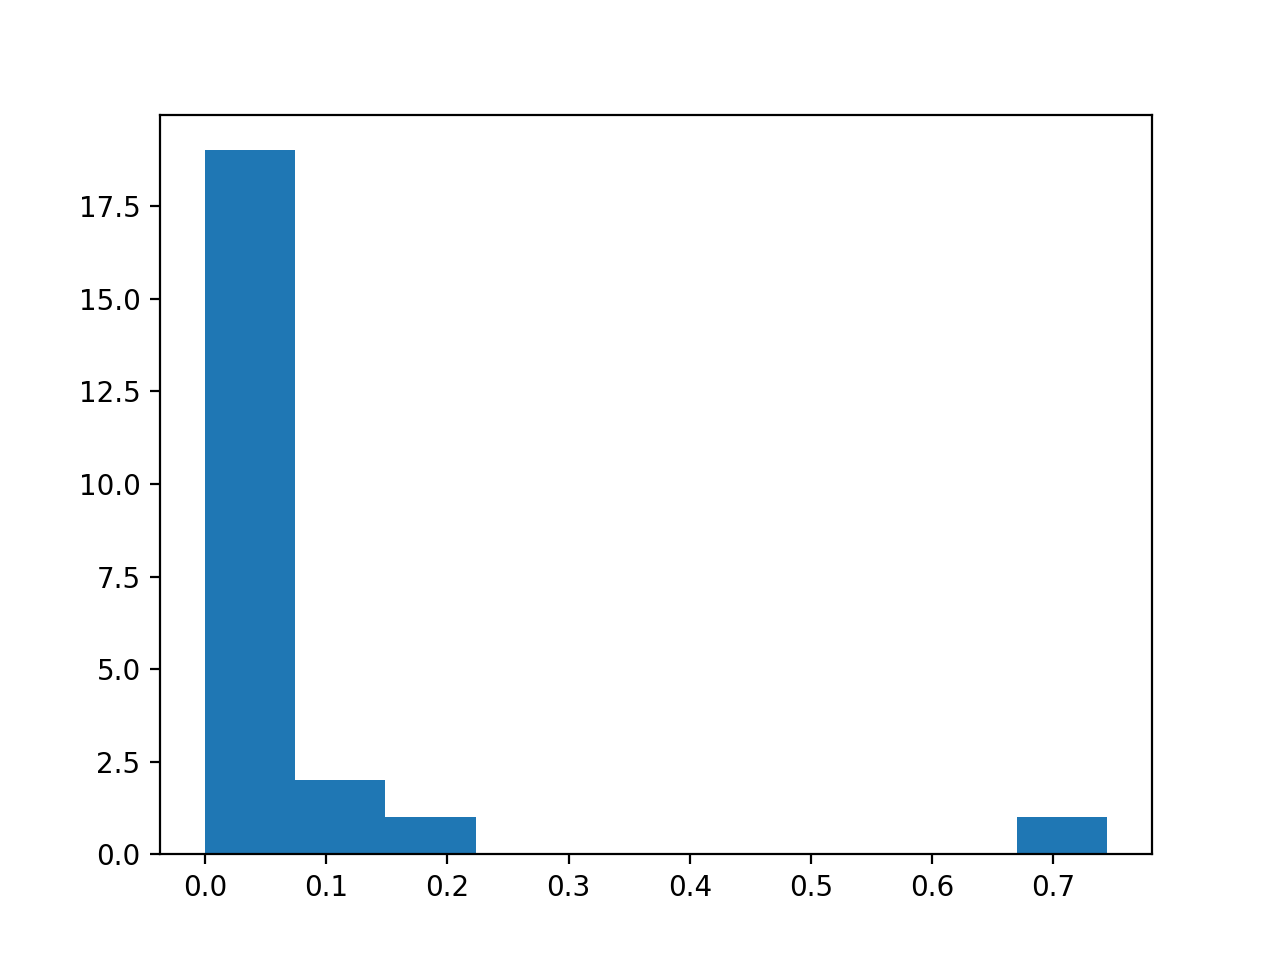

(array([19.,  2.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([7.14023744e-06, 7.44360806e-02, 1.48865021e-01, 2.23293961e-01,
        2.97722902e-01, 3.72151842e-01, 4.46580782e-01, 5.21009723e-01,
        5.95438663e-01, 6.69867604e-01, 7.44296544e-01]),
 <BarContainer object of 10 artists>)

In [272]:
%matplotlib notebook

numerator = 0
denominator = 0
for i in range(len(poincare_r2['rsquared'])):
    numerator += sum((poincare_r2['zscore_mem'][i] - poincare_r2['fittedvalues'][i])**2)
    denominator += sum((poincare_r2['zscore_mem'][i] - poincare_r2['zscore_mem'][i].mean())**2)
    
# print(1 - (sum((zscore_mem_0 - res_0.fittedvalues)**2) + sum((zscore_mem_1 - res_1.fittedvalues)**2) + sum((zscore_mem_2 - res_2.fittedvalues)**2) + sum((zscore_mem_3 - res_3.fittedvalues)**2)) / (sum((zscore_mem_0 - zscore_mem_0.mean())**2) + sum((zscore_mem_1 - zscore_mem_1.mean())**2) + sum((zscore_mem_2 - zscore_mem_2.mean())**2) + sum((zscore_mem_3 - zscore_mem_3.mean())**2)))
print(1-(numerator/denominator))
plt.hist(poincare_r2['rsquared'])

0.03728301798236178


<IPython.core.display.Javascript object>


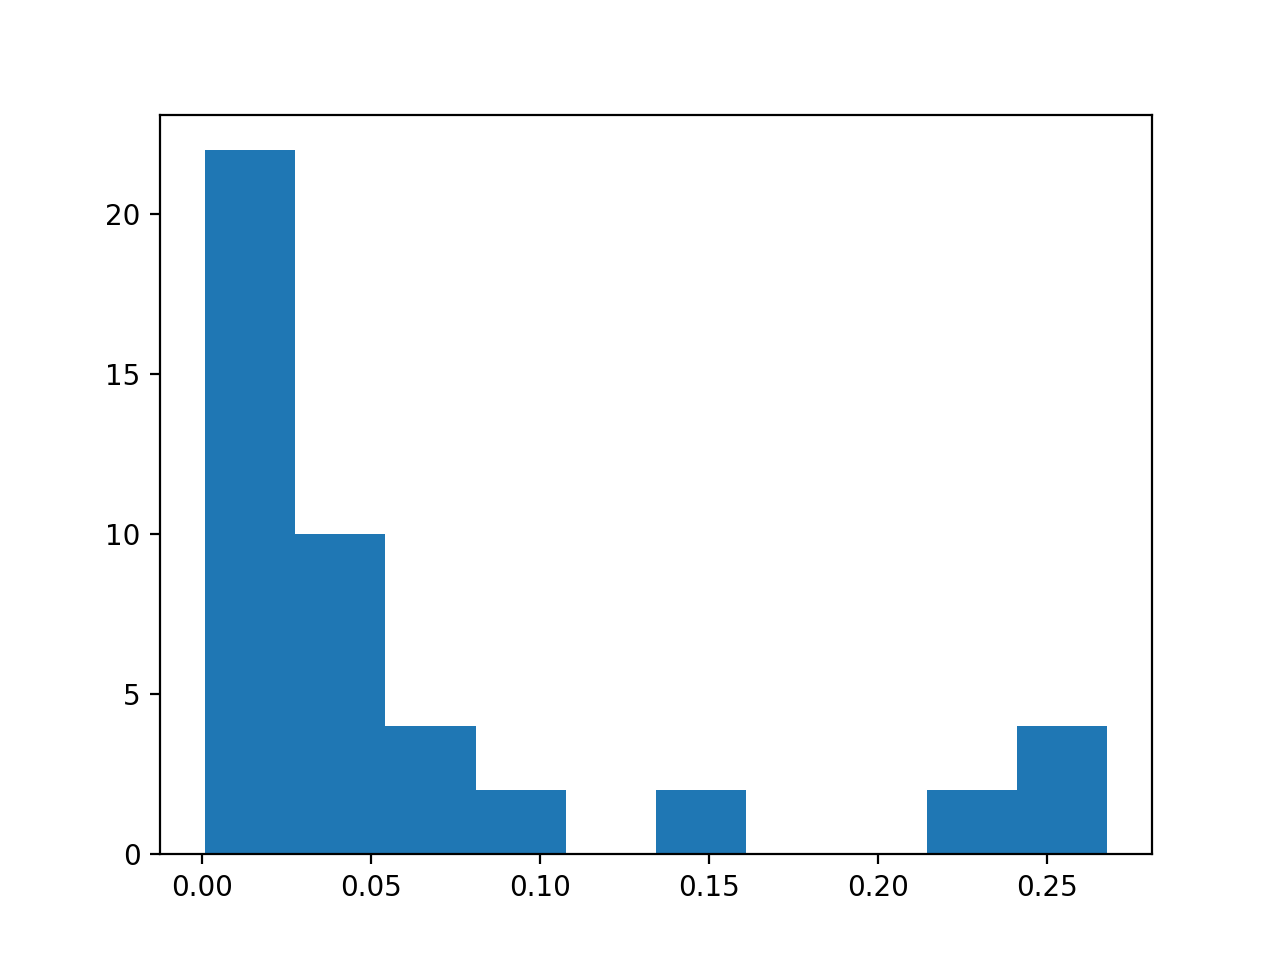

(array([22., 10.,  4.,  2.,  0.,  2.,  0.,  0.,  2.,  4.]),
 array([0.00085796, 0.02753965, 0.05422134, 0.08090303, 0.10758473,
        0.13426642, 0.16094811, 0.18762981, 0.2143115 , 0.24099319,
        0.26767489]),
 <BarContainer object of 10 artists>)

In [273]:
poincare_r_cat.groupby('bigcat').apply(lambda x: record_r_2(x, 'radius', r2))
%matplotlib notebook

numerator = 0
denominator = 0
for i in range(len(r2['rsquared'])):
    numerator += sum((r2['zscore_mem'][i] - r2['fittedvalues'][i])**2)
    denominator += sum((r2['zscore_mem'][i] - r2['zscore_mem'][i].mean())**2)
    
# print(1 - (sum((zscore_mem_0 - res_0.fittedvalues)**2) + sum((zscore_mem_1 - res_1.fittedvalues)**2) + sum((zscore_mem_2 - res_2.fittedvalues)**2) + sum((zscore_mem_3 - res_3.fittedvalues)**2)) / (sum((zscore_mem_0 - zscore_mem_0.mean())**2) + sum((zscore_mem_1 - zscore_mem_1.mean())**2) + sum((zscore_mem_2 - zscore_mem_2.mean())**2) + sum((zscore_mem_3 - zscore_mem_3.mean())**2)))
print(1-(numerator/denominator))

plt.hist(r2['rsquared'])

#### Agglomerative cluster analysis

In [220]:
from sklearn.cluster import AgglomerativeClustering

n = mean_concept_in_feat_cat_na['bigcat'].nunique()
X = mean_concept_in_feat_cat_na[[0,1,2]]
ward = AgglomerativeClustering(n_clusters=n, affinity='euclidean', linkage='ward').fit(X)
label = ward.labels_

In [242]:
tmp = mean_concept_in_feat_cat_na.copy(deep=True).reset_index()
tmp['label'] = pd.Series(label)
tmp[tmp['label'] != tmp['bigcat']]


level_0  index          0          1         2        cr  bigcat  \
0           0      0  -8.362256   5.447828 -8.557188  0.779739       1   
1           1      1 -26.123590  12.240625  0.518939  0.798485      13   
2           2      2 -24.385152  14.180849  0.693800  0.752845      18   
3           4      4 -20.330699  11.947785 -4.992442  0.794466       9   
4           5      5 -24.493047  16.661652 -4.482670  0.806000      12   
...       ...    ...        ...        ...       ...       ...     ...   
1319     1847   1847 -18.208906   9.885611  3.776987  0.803129      24   
1320     1848   1848 -19.281246   4.272460 -1.785376  0.765881      10   
1321     1850   1850 -19.551059   2.813812 -2.150868  0.843158      10   
1322     1851   1851 -14.748351   9.486465 -8.609210  0.800163       1   
1323     1853   1853 -18.651758   5.749045 -4.932768  0.823237      10   

                cat_name     concept_name  label  
0                 animal         aardvark     21  
1             home decor           abacus     16  
2     musical instrument        accordion     19  
3      electronic device  air_conditioner     20  
4              furniture     air_mattress      1  
...                  ...              ...    ...  
1319                 toy            yo-yo      8  
1320                food           yogurt      3  
1321                food             yolk      3  
1322              animal            zebra      9  
1323                food         zucchini      3  

[1294 rows x 10 columns]

In [245]:
from sklearn.metrics.cluster import rand_score

# agglomerative is doing great in clustering concepts in the same category together
rand_score(label, mean_concept_in_feat_cat_na['bigcat'])

0.9084213074286445

<IPython.core.display.Javascript object>


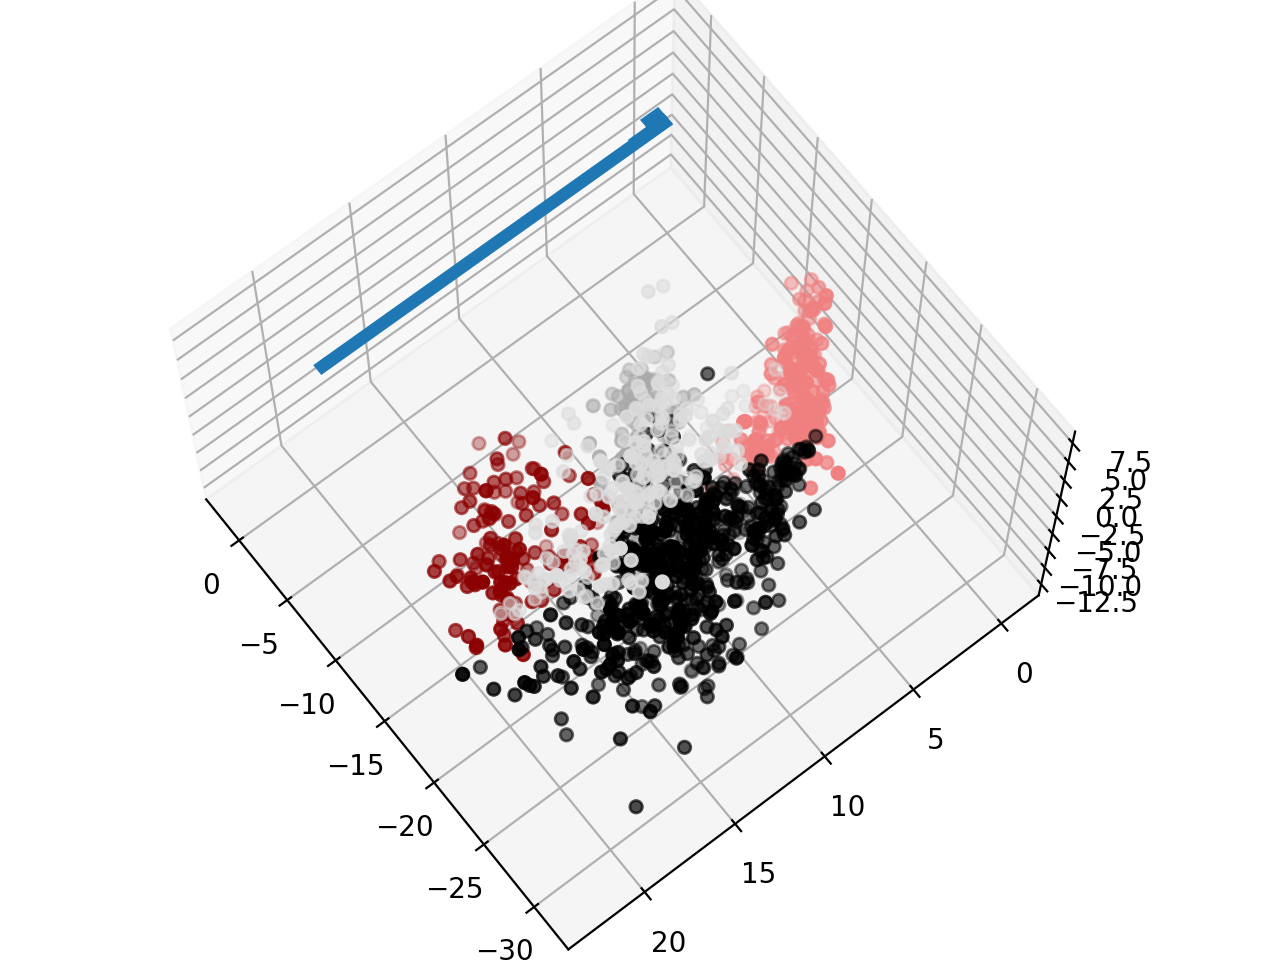

In [247]:
ward = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward').fit(X)
label = ward.labels_

colors = mcolors.CSS4_COLORS
by_hsv = sorted((tuple(mcolors.rgb_to_hsv(mcolors.to_rgb(color))), name)
                for name, color in colors.items())
color_names = [name for hsv, name in by_hsv]

fig1 = plt.figure()
ax1 = fig1.add_subplot(111, projection="3d", elev=7, azim=-80)
ax1.set_position([0, 0, 0.95, 1])
for l in np.unique(label):
    ax1.scatter(
        X[label == l][0],
        X[label == l][1],
        X[label == l][2],
        color=color_names[l*5],
        s=20,
    )

<IPython.core.display.Javascript object>


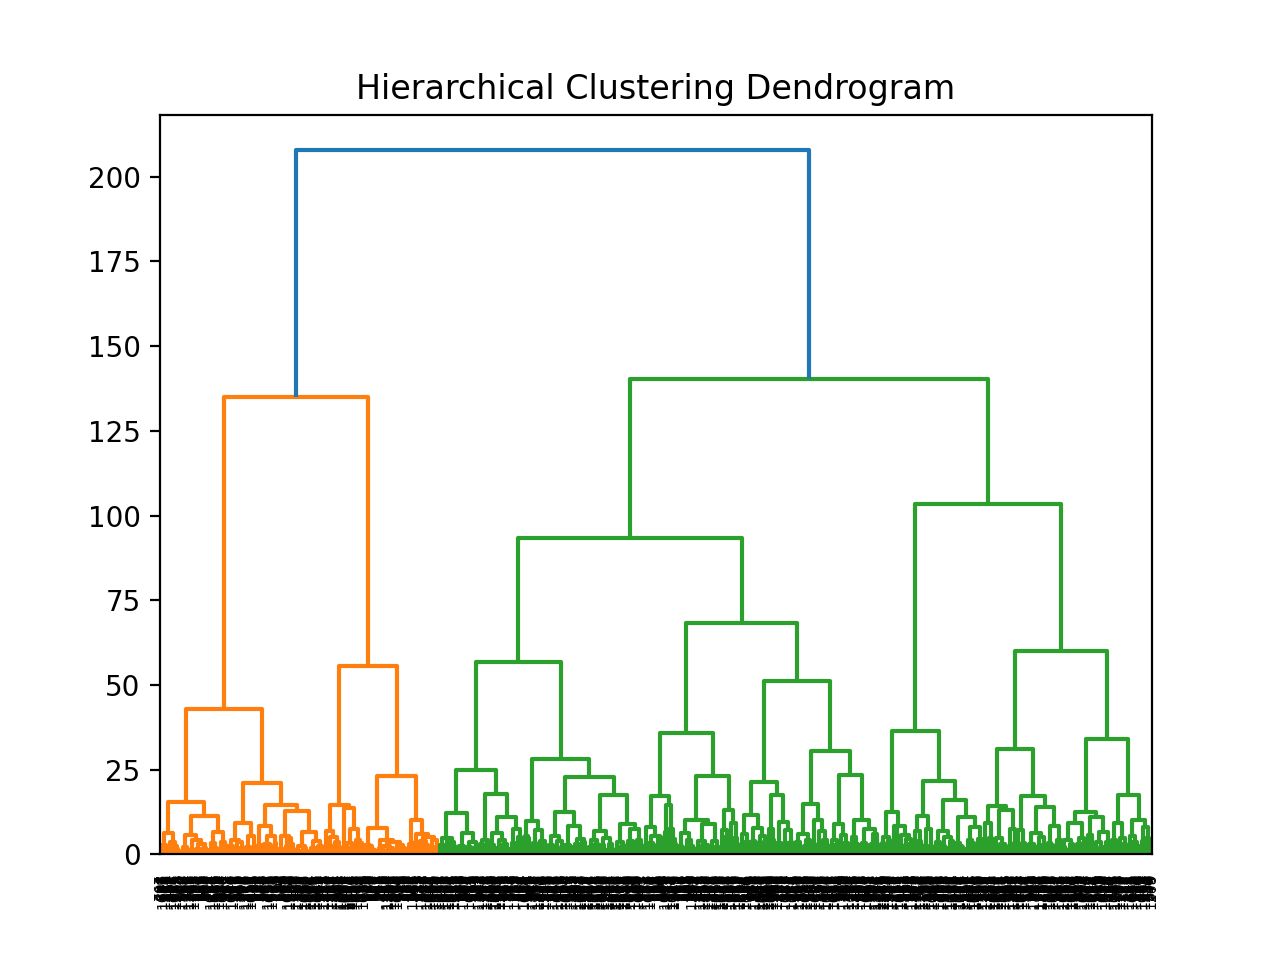

In [204]:
from scipy.cluster.hierarchy import dendrogram
%matplotlib notebook

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model = model.fit(X)
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode="level")
plt.show()

<IPython.core.display.Javascript object>


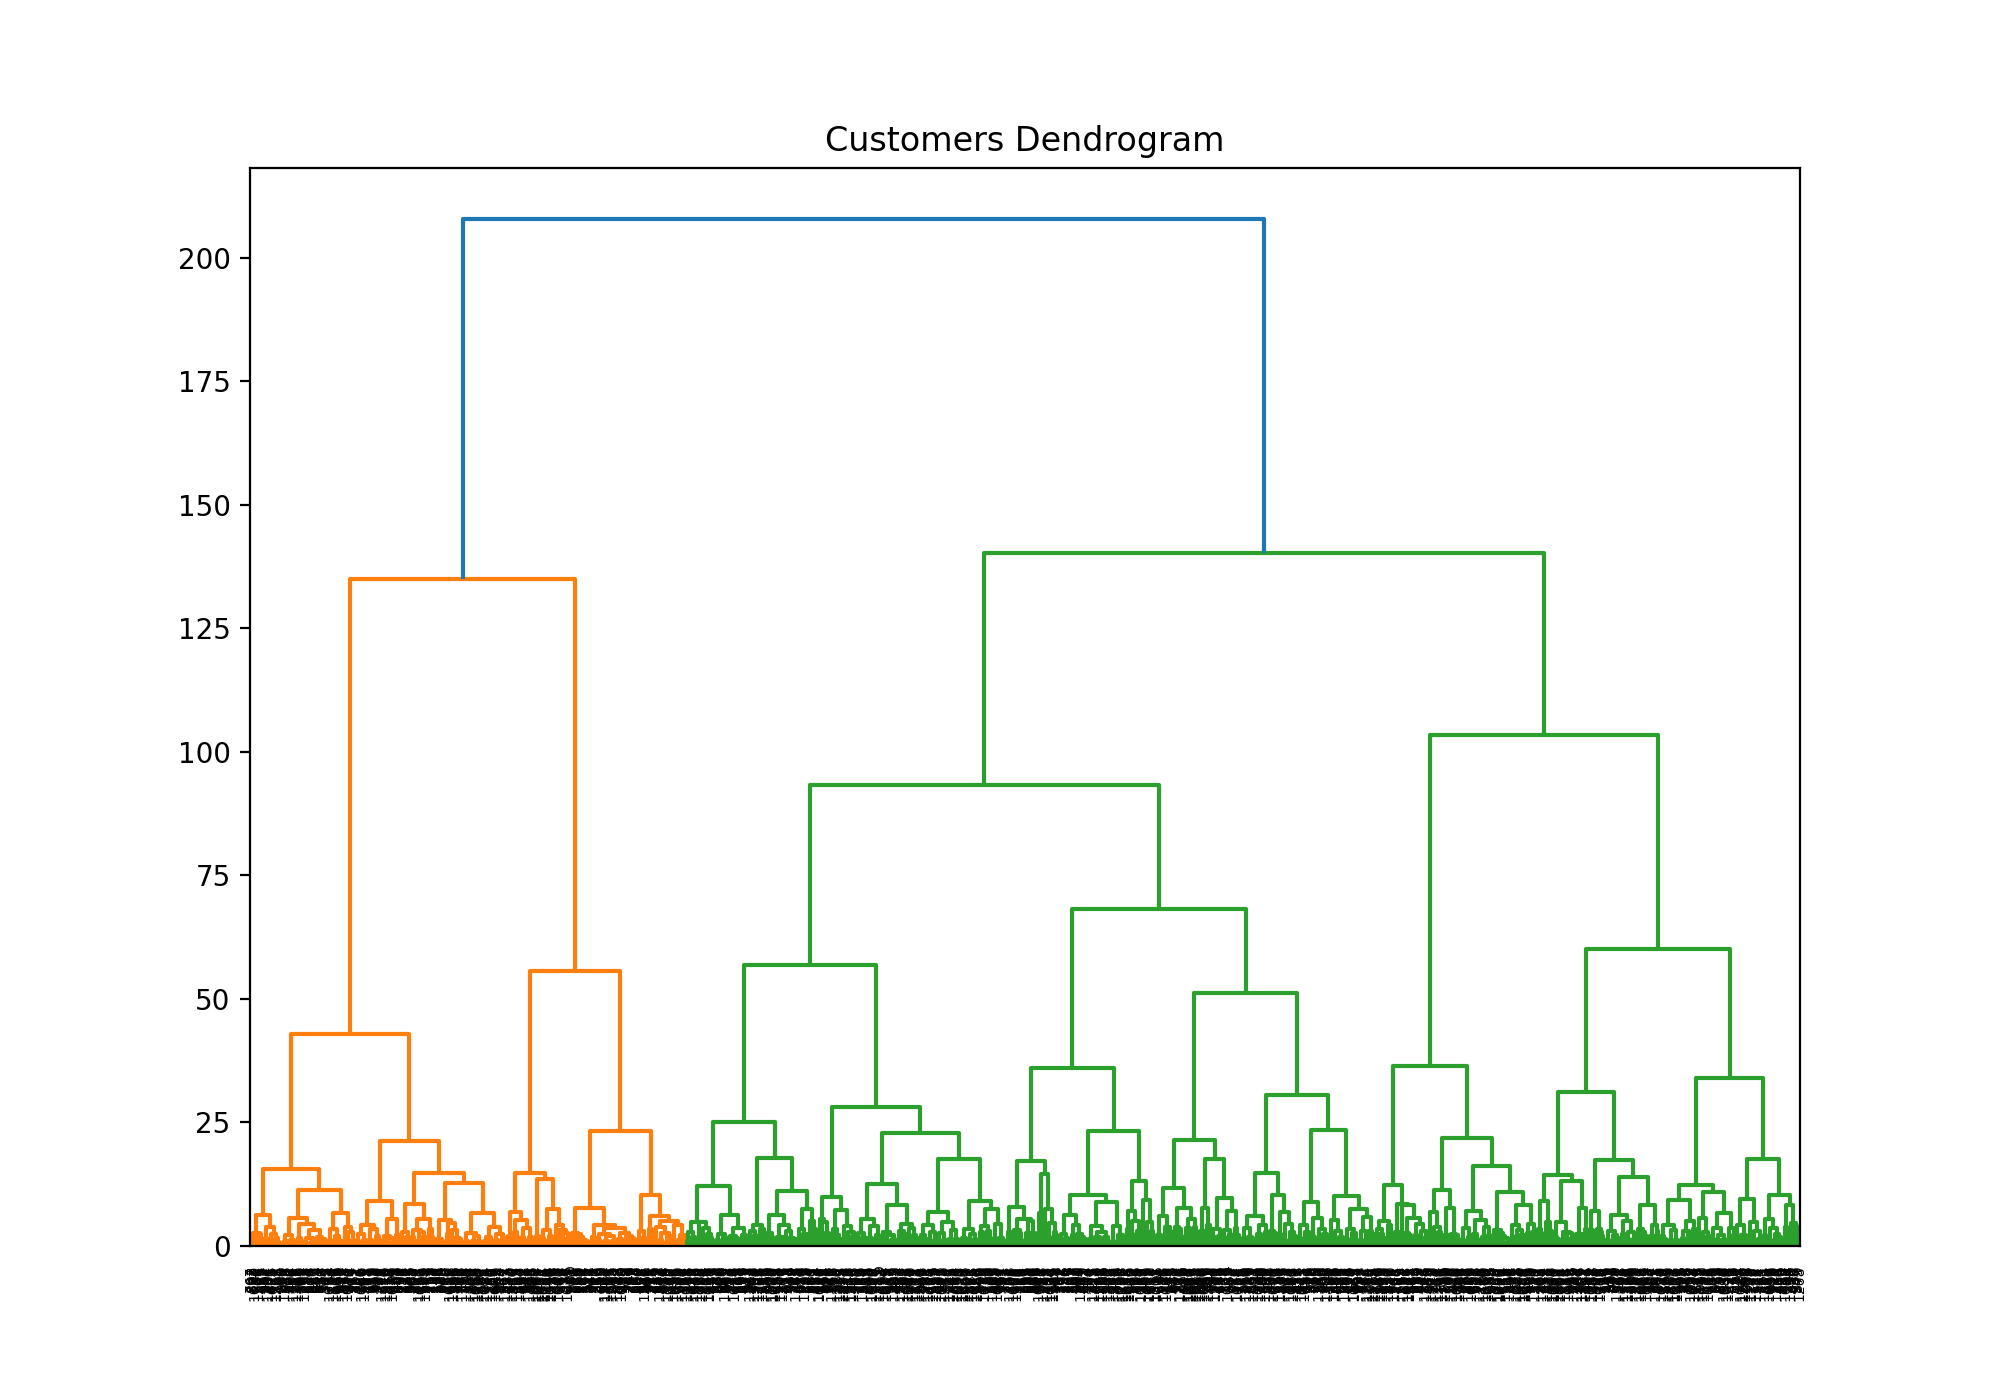

In [219]:
import scipy.cluster.hierarchy as shc

plt.figure(figsize=(10, 7))
plt.title("Customers Dendrogram")

# Selecting Annual Income and Spending Scores by index
clusters = shc.linkage(X, 
            method='ward', 
            metric="euclidean")
shc.dendrogram(Z=clusters)
plt.show()